In [1]:
# Load libraries

# # Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.ticker as ticker 
import matplotlib.patches as patches
import matplotlib as matplotlib
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Analysis
import numpy as np 
import xarray as xr
import datetime
from   datetime import date, timedelta
import pandas as pd 
import scipy.stats as stats
## Need to use metPy conda env
import metpy.calc as mpc
from metpy.units import units



In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:

# Grabbed from Brian M. to use time midpoints, not end periods
def cesm_correct_time(ds):
    """Given a Dataset, check for time_bnds,
       and use avg(time_bnds) to replace the time coordinate.
       Purpose is to center the timestamp on the averaging inverval.   
       NOTE: ds should have been loaded using `decode_times=False`
    """
    assert 'time_bnds' in ds
    assert 'time' in ds
    correct_time_values = ds['time_bnds'].mean(dim='nbnd')
    # copy any metadata:
    correct_time_values.attrs = ds['time'].attrs
    ds = ds.assign_coords({"time": correct_time_values})
    ds = xr.decode_cf(ds)  # decode to datetime objects
    return ds


## Read in data from SCAM runs 
* Idealized surface 
* 3 month free running simulations 
* Current option reads in CAM data that's been converted to height above the surface and interpolated to constant heights for clear plotting/averaging. 


### Section that computed PBLdepth (as height of max gradient of some variable), and converted everything to a constant vertical (height above sea level) 
* So this reads in all the atmospheric files and concats the dataset accordingly, does some processing, and generates the saved .nc file that's loaded above 
* Admittedly, this is an earlier version of the code and is a *lot* messier accordingly. So each year's files are read in individually below and then added together: 

In [4]:
### 
#   Prescribing thlp2, rtp2, and thlprtp. w* computed in FluxMods, set to 0.5 if stable.
#   This version uses an finidat file from June, not January 
#   This version also prescribes u'2, v'2, and w'2.
#   This version uses the reordering propsed by Adam H. to get around 2dt oscillations 
###

## Version without Adam's reordering
dataDir      = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/betterFinidat4_MoreMomentsNoReorder/'
caseName_HMG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsNoReorder_artificialSfc_2015jja'
caseName_HTG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsNoReorder_artificialSfc_2015jja'

## Version with Adam's reordering
# dataDir      = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/'
# caseName_HMG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_artificialSfc_2015jja'
# caseName_HTG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_artificialSfc_2015jja'


## SCAM Nudging options included
# caseName_HMG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_moreSCAMoptions_artificialSfc_2015jja'
# caseName_HTG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_moreSCAMoptions_artificialSfc_2015jja'


# Define file names of cam history files
hmgATMfiles = np.asarray([caseName_HMG+'.cam.h0.2015-05-31-84585.nc',
                          caseName_HMG+'.cam.h0.2015-07-05-60585.nc',
                          caseName_HMG+'.cam.h0.2015-08-09-36585.nc'])

htgATMfiles = np.asarray([caseName_HTG+'.cam.h0.2015-05-31-84585.nc',
                          caseName_HTG+'.cam.h0.2015-07-05-60585.nc',
                          caseName_HTG+'.cam.h0.2015-08-09-36585.nc'])

# Define file names of clm history files 
hmgLNDfiles = np.asarray([caseName_HMG+'.clm2.h0.2015-05-31-84585.nc',
                          caseName_HMG+'.clm2.h0.2015-07-05-60585.nc',
                          caseName_HMG+'.clm2.h0.2015-08-09-36585.nc'])

htgLNDfiles = np.asarray([caseName_HTG+'.clm2.h0.2015-05-31-84585.nc',
                          caseName_HTG+'.clm2.h0.2015-07-05-60585.nc',
                          caseName_HTG+'.clm2.h0.2015-08-09-36585.nc'])

# Define file names of clm patch files 
hmgLNDfilesPatch = np.asarray([caseName_HMG+'.clm2.h1.2015-05-31-84585.nc',
                               caseName_HMG+'.clm2.h1.2015-07-05-60585.nc',
                               caseName_HMG+'.clm2.h1.2015-08-09-36585.nc'])

htgLNDfilesPatch = np.asarray([caseName_HTG+'.clm2.h1.2015-05-31-84585.nc',
                               caseName_HTG+'.clm2.h1.2015-07-05-60585.nc',
                               caseName_HTG+'.clm2.h1.2015-08-09-36585.nc'])


for iFile in range(len(hmgLNDfiles)): 
    
    with xr.open_dataset(dataDir+htgATMfiles[iFile], decode_times=False) as HTGcamDS:
        HTGcamDS = cesm_correct_time(HTGcamDS)
        HTGcamDS['time'] = HTGcamDS.indexes['time'].to_datetimeindex()
    with xr.open_dataset(dataDir+hmgATMfiles[iFile], decode_times=False) as HMGcamDS:
        HMGcamDS = cesm_correct_time(HMGcamDS)
        HMGcamDS['time'] = HMGcamDS.indexes['time'].to_datetimeindex()
        print('Length of CAM file times: ', len(HTGcamDS.time.values))
        
    with xr.open_dataset(dataDir+htgLNDfiles[iFile], decode_times=True) as HTGclmDS:
        print('Length of CLM file times: ', len(HTGclmDS.time.values))
        HTGclmDS['time'] = HTGcamDS.time

    with xr.open_dataset(dataDir+hmgLNDfiles[iFile], decode_times=True) as HMGclmDS:
        HMGclmDS['time'] = HMGcamDS.time

        
    with xr.open_dataset(dataDir+htgLNDfilesPatch[iFile], decode_times=True) as HTGclmDS_patch:
        HTGclmDS_patch['time'] = HTGcamDS.time

    with xr.open_dataset(dataDir+hmgLNDfilesPatch[iFile], decode_times=True) as HMGclmDS_patch:
        HMGclmDS_patch['time'] = HMGcamDS.time

    
    if iFile==0:
        HTGcamDS_all2015 = HTGcamDS 
        HMGcamDS_all2015 = HMGcamDS
        HTGclmDS_all2015 = HTGclmDS
        HMGclmDS_all2015 = HMGclmDS 
        HTGclmDSpatch_all2015 = HTGclmDS_patch
        HMGclmDSpatch_all2015 = HMGclmDS_patch
    else: 
        HTGcamDS_all2015 = xr.concat([HTGcamDS_all2015, HTGcamDS], dim='time')
        HMGcamDS_all2015 = xr.concat([HMGcamDS_all2015, HMGcamDS], dim='time')
        HTGclmDS_all2015 = xr.concat([HTGclmDS_all2015,HTGclmDS], dim='time', data_vars='minimal')
        HMGclmDS_all2015 = xr.concat([HMGclmDS_all2015,HMGclmDS], dim='time', data_vars='minimal')
        HTGclmDSpatch_all2015 = xr.concat([HTGclmDSpatch_all2015,HTGclmDS_patch], dim='time', data_vars='minimal')
        HMGclmDSpatch_all2015 = xr.concat([HMGclmDSpatch_all2015,HMGclmDS_patch], dim='time', data_vars='minimal')
        
    print('Done reading in file %i of %i' % (iFile+1, len(hmgLNDfiles)))
    
# print('Resampling to hourly means... ')
# HTGcamDS_all2015 = HTGcamDS_all2015.resample(time='1H').mean()
# HMGcamDS_all2015 = HMGcamDS_all2015.resample(time='1H').mean()
# HTGclmDS_all2015 = HTGclmDS_all2015.resample(time='1H').mean()
# HMGclmDS_all2015 = HMGclmDS_all2015.resample(time='1H').mean()
# HTGclmDSpatch_all2015 = HTGclmDSpatch_all2015.resample(time='1H').mean()
# HMGclmDSpatch_all2015 = HMGclmDSpatch_all2015.resample(time='1H').mean()
    

Length of CAM file times:  2500
Length of CLM file times:  2500
Done reading in file 1 of 3
Length of CAM file times:  2500
Length of CLM file times:  2500
Done reading in file 2 of 3
Length of CAM file times:  1409
Length of CLM file times:  1409
Done reading in file 3 of 3
Resampling to hourly means... 


In [7]:
### 
#   Prescribing thlp2, rtp2, and thlprtp. w* computed in FluxMods, set to 0.5 if stable.
#   This version uses an finidat file from June, not January 
#   This version also prescribes u'2, v'2, and w'2.
#   This version uses the reordering propsed by Adam H. to get around 2dt oscillations 
#
#   TEST JJA in 2016
#
###


## Version without Adam's reordering
dataDir      = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/betterFinidat4_MoreMomentsNoReorder/'
caseName_HMG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsNoReorder_artificialSfc_2016jja'
caseName_HTG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsNoReorder_artificialSfc_2016jja'

## Version with Adam's reordering
# dataDir = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/'

# caseName_HMG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_artificialSfc_2016jja'
# caseName_HTG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_artificialSfc_2016jja'

## Files with temperature relaxation on:
# caseName_HMG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_moreSCAMoptions_artificialSfc_2016jja'
# caseName_HTG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_moreSCAMoptions_artificialSfc_2016jja'


# Define file names of cam history files
hmgATMfiles = np.asarray([caseName_HMG+'.cam.h0.2016-05-31-84585.nc',
                          caseName_HMG+'.cam.h0.2016-07-05-60585.nc',
                          caseName_HMG+'.cam.h0.2016-08-09-36585.nc'])

htgATMfiles = np.asarray([caseName_HTG+'.cam.h0.2016-05-31-84585.nc',
                          caseName_HTG+'.cam.h0.2016-07-05-60585.nc',
                          caseName_HTG+'.cam.h0.2016-08-09-36585.nc'])

# Define file names of clm history files 
hmgLNDfiles = np.asarray([caseName_HMG+'.clm2.h0.2016-05-31-84585.nc',
                          caseName_HMG+'.clm2.h0.2016-07-05-60585.nc',
                          caseName_HMG+'.clm2.h0.2016-08-09-36585.nc'])

htgLNDfiles = np.asarray([caseName_HTG+'.clm2.h0.2016-05-31-84585.nc',
                          caseName_HTG+'.clm2.h0.2016-07-05-60585.nc',
                          caseName_HTG+'.clm2.h0.2016-08-09-36585.nc'])

# Define file names of clm patch files 
hmgLNDfilesPatch = np.asarray([caseName_HMG+'.clm2.h1.2016-05-31-84585.nc',
                               caseName_HMG+'.clm2.h1.2016-07-05-60585.nc',
                               caseName_HMG+'.clm2.h1.2016-08-09-36585.nc'])

htgLNDfilesPatch = np.asarray([caseName_HTG+'.clm2.h1.2016-05-31-84585.nc',
                               caseName_HTG+'.clm2.h1.2016-07-05-60585.nc',
                               caseName_HTG+'.clm2.h1.2016-08-09-36585.nc'])


for iFile in range(len(hmgLNDfiles)): 
    
    with xr.open_dataset(dataDir+htgATMfiles[iFile], decode_times=False) as HTGcamDS:
        HTGcamDS = cesm_correct_time(HTGcamDS)
        HTGcamDS['time'] = HTGcamDS.indexes['time'].to_datetimeindex()
    with xr.open_dataset(dataDir+hmgATMfiles[iFile], decode_times=False) as HMGcamDS:
        HMGcamDS = cesm_correct_time(HMGcamDS)
        HMGcamDS['time'] = HMGcamDS.indexes['time'].to_datetimeindex()
        
    with xr.open_dataset(dataDir+htgLNDfiles[iFile], decode_times=True) as HTGclmDS:
        HTGclmDS['time'] = HTGcamDS.time.values
    with xr.open_dataset(dataDir+hmgLNDfiles[iFile], decode_times=True) as HMGclmDS:
        HMGclmDS['time'] = HMGcamDS.time.values
    
    with xr.open_dataset(dataDir+htgLNDfilesPatch[iFile], decode_times=True) as HTGclmDS_patch:
        HTGclmDS_patch['time'] = HTGcamDS.time
    with xr.open_dataset(dataDir+hmgLNDfilesPatch[iFile], decode_times=True) as HMGclmDS_patch:
        HMGclmDS_patch['time'] = HMGcamDS.time
    
    if iFile==0:
        HTGcamDS_all2016 = HTGcamDS 
        HMGcamDS_all2016 = HMGcamDS
        HTGclmDS_all2016 = HTGclmDS
        HMGclmDS_all2016 = HMGclmDS 
        HTGclmDSpatch_all2016 = HTGclmDS_patch
        HMGclmDSpatch_all2016 = HMGclmDS_patch
    else: 
        HTGcamDS_all2016 = xr.concat([HTGcamDS_all2016, HTGcamDS], dim='time')
        HMGcamDS_all2016 = xr.concat([HMGcamDS_all2016, HMGcamDS], dim='time')
        HTGclmDS_all2016 = xr.concat([HTGclmDS_all2016,HTGclmDS], dim='time', data_vars='minimal')
        HMGclmDS_all2016 = xr.concat([HMGclmDS_all2016,HMGclmDS], dim='time', data_vars='minimal')
        HTGclmDSpatch_all2016 = xr.concat([HTGclmDSpatch_all2016,HTGclmDS_patch], dim='time', data_vars='minimal')
        HMGclmDSpatch_all2016 = xr.concat([HMGclmDSpatch_all2016,HMGclmDS_patch], dim='time', data_vars='minimal')
        
    print('Done reading in file %i of %i' % (iFile+1, len(hmgLNDfiles)))
    
# print('Resampling to hourly means... ')
# HTGcamDS_all2016 = HTGcamDS_all2016.resample(time='1H').mean()
# HMGcamDS_all2016 = HMGcamDS_all2016.resample(time='1H').mean()
# HTGclmDS_all2016 = HTGclmDS_all2016.resample(time='1H').mean()
# HMGclmDS_all2016 = HMGclmDS_all2016.resample(time='1H').mean()
# HTGclmDSpatch_all2016 = HTGclmDSpatch_all2016.resample(time='1H').mean()
# HMGclmDSpatch_all2016 = HMGclmDSpatch_all2016.resample(time='1H').mean()
# print('Done with resampling')
    

Done reading in file 1 of 3
Done reading in file 2 of 3
Done reading in file 3 of 3
Resampling to hourly means... 
Done with resampling


In [8]:
### 
#   Prescribing thlp2, rtp2, and thlprtp. w* computed in FluxMods, set to 0.5 if stable.
#   This version uses an finidat file from June, not January 
#   This version also prescribes u'2, v'2, and w'2.
#   This version uses the reordering propsed by Adam H. to get around 2dt oscillations 
#
#   TEST JJA in 2017
#
###

## Version without Adam's reordering
dataDir      = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/betterFinidat4_MoreMomentsNoReorder/'
caseName_HMG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsNoReorder_artificialSfc_2017jja'
caseName_HTG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsNoReorder_artificialSfc_2017jja'

## Version with Adam's reordering
# dataDir = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/'
# caseName_HMG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_artificialSfc_2017jja'
# caseName_HTG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_artificialSfc_2017jja'

## Files with temperature relaxation on:
# caseName_HMG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_moreSCAMoptions_artificialSfc_2017jja'
# caseName_HTG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_moreSCAMoptions_artificialSfc_2017jja'


# Define file names of cam history files
hmgATMfiles = np.asarray([caseName_HMG+'.cam.h0.2017-05-31-84585.nc',
                          caseName_HMG+'.cam.h0.2017-07-05-60585.nc',
                          caseName_HMG+'.cam.h0.2017-08-09-36585.nc'])

htgATMfiles = np.asarray([caseName_HTG+'.cam.h0.2017-05-31-84585.nc',
                          caseName_HTG+'.cam.h0.2017-07-05-60585.nc',
                          caseName_HTG+'.cam.h0.2017-08-09-36585.nc'])

# Define file names of clm history files 
hmgLNDfiles = np.asarray([caseName_HMG+'.clm2.h0.2017-05-31-84585.nc',
                          caseName_HMG+'.clm2.h0.2017-07-05-60585.nc',
                          caseName_HMG+'.clm2.h0.2017-08-09-36585.nc'])

htgLNDfiles = np.asarray([caseName_HTG+'.clm2.h0.2017-05-31-84585.nc',
                          caseName_HTG+'.clm2.h0.2017-07-05-60585.nc',
                          caseName_HTG+'.clm2.h0.2017-08-09-36585.nc'])

# Define file names of clm patch files 
hmgLNDfilesPatch = np.asarray([caseName_HMG+'.clm2.h1.2017-05-31-84585.nc',
                               caseName_HMG+'.clm2.h1.2017-07-05-60585.nc',
                               caseName_HMG+'.clm2.h1.2017-08-09-36585.nc'])

htgLNDfilesPatch = np.asarray([caseName_HTG+'.clm2.h1.2017-05-31-84585.nc',
                               caseName_HTG+'.clm2.h1.2017-07-05-60585.nc',
                               caseName_HTG+'.clm2.h1.2017-08-09-36585.nc'])


for iFile in range(len(hmgLNDfiles)): 
    
    with xr.open_dataset(dataDir+htgATMfiles[iFile], decode_times=False) as HTGcamDS:
        HTGcamDS = cesm_correct_time(HTGcamDS)
        HTGcamDS['time'] = HTGcamDS.indexes['time'].to_datetimeindex()
    with xr.open_dataset(dataDir+hmgATMfiles[iFile], decode_times=False) as HMGcamDS:
        HMGcamDS = cesm_correct_time(HMGcamDS)
        HMGcamDS['time'] = HMGcamDS.indexes['time'].to_datetimeindex()
        
    with xr.open_dataset(dataDir+htgLNDfiles[iFile], decode_times=True) as HTGclmDS:
        HTGclmDS['time'] = HTGcamDS.time
    with xr.open_dataset(dataDir+hmgLNDfiles[iFile], decode_times=True) as HMGclmDS:
        HMGclmDS['time'] = HMGcamDS.time
        
    with xr.open_dataset(dataDir+htgLNDfilesPatch[iFile], decode_times=True) as HTGclmDS_patch:
        HTGclmDS_patch['time'] = HTGcamDS.time
    with xr.open_dataset(dataDir+hmgLNDfilesPatch[iFile], decode_times=True) as HMGclmDS_patch:
        HMGclmDS_patch['time'] = HMGcamDS.time
    
    if iFile==0:
        HTGcamDS_all2017 = HTGcamDS 
        HMGcamDS_all2017 = HMGcamDS
        HTGclmDS_all2017 = HTGclmDS
        HMGclmDS_all2017 = HMGclmDS 
        HTGclmDSpatch_all2017 = HTGclmDS_patch
        HMGclmDSpatch_all2017 = HMGclmDS_patch
    else: 
        HTGcamDS_all2017 = xr.concat([HTGcamDS_all2017, HTGcamDS], dim='time')
        HMGcamDS_all2017 = xr.concat([HMGcamDS_all2017, HMGcamDS], dim='time')
        HTGclmDS_all2017 = xr.concat([HTGclmDS_all2017,HTGclmDS], dim='time', data_vars='minimal')
        HMGclmDS_all2017 = xr.concat([HMGclmDS_all2017,HMGclmDS], dim='time', data_vars='minimal')
        HTGclmDSpatch_all2017 = xr.concat([HTGclmDSpatch_all2017,HTGclmDS_patch], dim='time', data_vars='minimal')
        HMGclmDSpatch_all2017 = xr.concat([HMGclmDSpatch_all2017,HMGclmDS_patch], dim='time', data_vars='minimal')
        
    print('Done reading in file %i of %i' % (iFile+1, len(hmgLNDfiles)))
    
# print('Resampling to hourly means... ')
# HTGcamDS_all2017 = HTGcamDS_all2017.resample(time='1H').mean()
# HMGcamDS_all2017 = HMGcamDS_all2017.resample(time='1H').mean()
# HTGclmDS_all2017 = HTGclmDS_all2017.resample(time='1H').mean()
# HMGclmDS_all2017 = HMGclmDS_all2017.resample(time='1H').mean()
# HTGclmDSpatch_all2017 = HTGclmDSpatch_all2017.resample(time='1H').mean()
# HMGclmDSpatch_all2017 = HMGclmDSpatch_all2017.resample(time='1H').mean()    
# print('Done with resampling')  
    

Done reading in file 1 of 3
Done reading in file 2 of 3
Done reading in file 3 of 3
Resampling to hourly means... 
Done with resampling


In [9]:
### 
#   Prescribing thlp2, rtp2, and thlprtp. w* computed in FluxMods, set to 0.5 if stable.
#   This version uses an finidat file from June, not January 
#   This version also prescribes u'2, v'2, and w'2.
#   This version uses the reordering propsed by Adam H. to get around 2dt oscillations 
#
#   TEST JJA in 2018
#
###

## Version without Adam's reordering
dataDir      = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/betterFinidat4_MoreMomentsNoReorder/'
caseName_HMG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsNoReorder_artificialSfc_2018jja'
caseName_HTG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsNoReorder_artificialSfc_2018jja'

## Version with Adam's reordering
# dataDir = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/'
# caseName_HMG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_artificialSfc_2018jja'
# caseName_HTG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_artificialSfc_2018jja'

## Files with temperature relaxation on:
# caseName_HMG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_moreSCAMoptions_artificialSfc_2018jja'
# caseName_HTG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_moreSCAMoptions_artificialSfc_2018jja'


# Define file names of cam history files
hmgATMfiles = np.asarray([caseName_HMG+'.cam.h0.2018-05-31-84585.nc',
                          caseName_HMG+'.cam.h0.2018-07-05-60585.nc',
                          caseName_HMG+'.cam.h0.2018-08-09-36585.nc'])

htgATMfiles = np.asarray([caseName_HTG+'.cam.h0.2018-05-31-84585.nc',
                          caseName_HTG+'.cam.h0.2018-07-05-60585.nc',
                          caseName_HTG+'.cam.h0.2018-08-09-36585.nc'])

# Define file names of clm history files 
hmgLNDfiles = np.asarray([caseName_HMG+'.clm2.h0.2018-05-31-84585.nc',
                          caseName_HMG+'.clm2.h0.2018-07-05-60585.nc',
                          caseName_HMG+'.clm2.h0.2018-08-09-36585.nc'])

htgLNDfiles = np.asarray([caseName_HTG+'.clm2.h0.2018-05-31-84585.nc',
                          caseName_HTG+'.clm2.h0.2018-07-05-60585.nc',
                          caseName_HTG+'.clm2.h0.2018-08-09-36585.nc'])

# Define file names of clm patch files 
hmgLNDfilesPatch = np.asarray([caseName_HMG+'.clm2.h1.2018-05-31-84585.nc',
                               caseName_HMG+'.clm2.h1.2018-07-05-60585.nc',
                               caseName_HMG+'.clm2.h1.2018-08-09-36585.nc'])

htgLNDfilesPatch = np.asarray([caseName_HTG+'.clm2.h1.2018-05-31-84585.nc',
                               caseName_HTG+'.clm2.h1.2018-07-05-60585.nc',
                               caseName_HTG+'.clm2.h1.2018-08-09-36585.nc'])


for iFile in range(len(hmgLNDfiles)): 
    
    with xr.open_dataset(dataDir+htgATMfiles[iFile], decode_times=False) as HTGcamDS:
        HTGcamDS = cesm_correct_time(HTGcamDS)
        HTGcamDS['time'] = HTGcamDS.indexes['time'].to_datetimeindex()
    with xr.open_dataset(dataDir+hmgATMfiles[iFile], decode_times=False) as HMGcamDS:
        HMGcamDS = cesm_correct_time(HMGcamDS)
        HMGcamDS['time'] = HMGcamDS.indexes['time'].to_datetimeindex()
        
    with xr.open_dataset(dataDir+htgLNDfiles[iFile], decode_times=True) as HTGclmDS:
        HTGclmDS['time'] = HTGcamDS.time
    with xr.open_dataset(dataDir+hmgLNDfiles[iFile], decode_times=True) as HMGclmDS:
        HMGclmDS['time'] = HMGcamDS.time
        
    with xr.open_dataset(dataDir+htgLNDfilesPatch[iFile], decode_times=True) as HTGclmDS_patch:
        HTGclmDS_patch['time'] = HTGcamDS.time
    with xr.open_dataset(dataDir+hmgLNDfilesPatch[iFile], decode_times=True) as HMGclmDS_patch:
        HMGclmDS_patch['time'] = HMGcamDS.time
    
    if iFile==0:
        HTGcamDS_all2018 = HTGcamDS 
        HMGcamDS_all2018 = HMGcamDS
        HTGclmDS_all2018 = HTGclmDS
        HMGclmDS_all2018 = HMGclmDS 
        HTGclmDSpatch_all2018 = HTGclmDS_patch
        HMGclmDSpatch_all2018 = HMGclmDS_patch
    else: 
        HTGcamDS_all2018 = xr.concat([HTGcamDS_all2018, HTGcamDS], dim='time')
        HMGcamDS_all2018 = xr.concat([HMGcamDS_all2018, HMGcamDS], dim='time')
        HTGclmDS_all2018 = xr.concat([HTGclmDS_all2018,HTGclmDS], dim='time', data_vars='minimal')
        HMGclmDS_all2018 = xr.concat([HMGclmDS_all2018,HMGclmDS], dim='time', data_vars='minimal')
        HTGclmDSpatch_all2018 = xr.concat([HTGclmDSpatch_all2018,HTGclmDS_patch], dim='time', data_vars='minimal')
        HMGclmDSpatch_all2018 = xr.concat([HMGclmDSpatch_all2018,HMGclmDS_patch], dim='time', data_vars='minimal')
        
    print('Done reading in file %i of %i' % (iFile+1, len(hmgLNDfiles)))
    
# print('Resampling to hourly means... ')
# HTGcamDS_all2018 = HTGcamDS_all2018.resample(time='1H').mean()
# HMGcamDS_all2018 = HMGcamDS_all2018.resample(time='1H').mean()
# HTGclmDS_all2018 = HTGclmDS_all2018.resample(time='1H').mean()
# HMGclmDS_all2018 = HMGclmDS_all2018.resample(time='1H').mean()
# HTGclmDSpatch_all2018 = HTGclmDSpatch_all2018.resample(time='1H').mean()
# HMGclmDSpatch_all2018 = HMGclmDSpatch_all2018.resample(time='1H').mean()  
# print('Done with resampling')


Done reading in file 1 of 3
Done reading in file 2 of 3
Done reading in file 3 of 3
Resampling to hourly means... 
Done with resampling


In [10]:

#selYear = 2017
selYear = 'all'

if selYear==2015: 
    HTGcamDS_all = HTGcamDS_all2015
    HMGcamDS_all = HMGcamDS_all2015
    HTGclmDS_all = HTGclmDS_all2015
    HMGclmDS_all = HMGclmDS_all2015
elif selYear==2016:
    HTGcamDS_all = HTGcamDS_all2016
    HMGcamDS_all = HMGcamDS_all2016
    HTGclmDS_all = HTGclmDS_all2016
    HMGclmDS_all = HMGclmDS_all2016    
elif selYear==2017:
    HTGcamDS_all = HTGcamDS_all2017
    HMGcamDS_all = HMGcamDS_all2017
    HTGclmDS_all = HTGclmDS_all2017
    HMGclmDS_all = HMGclmDS_all2017 
elif selYear==2018:
    HTGcamDS_all = HTGcamDS_all2018
    HMGcamDS_all = HMGcamDS_all2018
    HTGclmDS_all = HTGclmDS_all2018
    HMGclmDS_all = HMGclmDS_all2018 
elif selYear=='all': 
    ## Discard spin up days 
    iTimeStart   = np.where(HTGcamDS_all2015.time.values >= (HTGcamDS_all2015.time.values[0] + np.timedelta64(2,'D')))[0]
    timeArr      = np.arange(iTimeStart[0], len(HMGcamDS_all2015.time.values))

    HTGcamDS_all2015 = HTGcamDS_all2015.isel(time=timeArr)
    HTGclmDS_all2015 = HTGclmDS_all2015.isel(time=timeArr)
    HMGcamDS_all2015 = HMGcamDS_all2015.isel(time=timeArr)
    HMGclmDS_all2015 = HMGclmDS_all2015.isel(time=timeArr)
    HTGclmDSpatch_all2015 = HTGclmDSpatch_all2015.isel(time=timeArr)
    HMGclmDSpatch_all2015 = HMGclmDSpatch_all2015.isel(time=timeArr)
    
    iTimeStart   = np.where(HTGcamDS_all2016.time.values >= (HTGcamDS_all2016.time.values[0] + np.timedelta64(2,'D')))[0]
    timeArr      = np.arange(iTimeStart[0], len(HMGcamDS_all2016.time.values))

    HTGcamDS_all2016 = HTGcamDS_all2016.isel(time=timeArr)
    HTGclmDS_all2016 = HTGclmDS_all2016.isel(time=timeArr)
    HMGcamDS_all2016 = HMGcamDS_all2016.isel(time=timeArr)
    HMGclmDS_all2016 = HMGclmDS_all2016.isel(time=timeArr)
    HTGclmDSpatch_all2016 = HTGclmDSpatch_all2016.isel(time=timeArr)
    HMGclmDSpatch_all2016 = HMGclmDSpatch_all2016.isel(time=timeArr)
    
    iTimeStart   = np.where(HTGcamDS_all2017.time.values >= (HTGcamDS_all2017.time.values[0] + np.timedelta64(2,'D')))[0]
    timeArr      = np.arange(iTimeStart[0], len(HMGcamDS_all2017.time.values))

    HTGcamDS_all2017 = HTGcamDS_all2017.isel(time=timeArr)
    HTGclmDS_all2017 = HTGclmDS_all2017.isel(time=timeArr)
    HMGcamDS_all2017 = HMGcamDS_all2017.isel(time=timeArr)
    HMGclmDS_all2017 = HMGclmDS_all2017.isel(time=timeArr)
    HTGclmDSpatch_all2017 = HTGclmDSpatch_all2017.isel(time=timeArr)
    HMGclmDSpatch_all2017 = HMGclmDSpatch_all2017.isel(time=timeArr)
    
    iTimeStart   = np.where(HTGcamDS_all2018.time.values >= (HTGcamDS_all2018.time.values[0] + np.timedelta64(2,'D')))[0]
    timeArr      = np.arange(iTimeStart[0], len(HMGcamDS_all2018.time.values))

    HTGcamDS_all2018 = HTGcamDS_all2018.isel(time=timeArr)
    HTGclmDS_all2018 = HTGclmDS_all2018.isel(time=timeArr)
    HMGcamDS_all2018 = HMGcamDS_all2018.isel(time=timeArr)
    HMGclmDS_all2018 = HMGclmDS_all2018.isel(time=timeArr)
    HTGclmDSpatch_all2018 = HTGclmDSpatch_all2018.isel(time=timeArr)
    HMGclmDSpatch_all2018 = HMGclmDSpatch_all2018.isel(time=timeArr)

    ## Concat into one giant DS
    HTGcamDS_all = xr.concat([HTGcamDS_all2015, HTGcamDS_all2016, HTGcamDS_all2017, HTGcamDS_all2018], dim='time')
    HMGcamDS_all = xr.concat([HMGcamDS_all2015, HMGcamDS_all2016, HMGcamDS_all2017, HMGcamDS_all2018], dim='time')
    HTGclmDS_all = xr.concat([HTGclmDS_all2015, HTGclmDS_all2016, HTGclmDS_all2017, HTGclmDS_all2018], dim='time')
    HMGclmDS_all = xr.concat([HMGclmDS_all2015, HMGclmDS_all2016, HMGclmDS_all2017, HMGclmDS_all2018], dim='time')
    
    HTGclmDS_allPatch = xr.concat([HTGclmDSpatch_all2015, HTGclmDSpatch_all2016, HTGclmDSpatch_all2017, HTGclmDSpatch_all2018], dim='time')
    HMGclmDS_allPatch = xr.concat([HMGclmDSpatch_all2015, HMGclmDSpatch_all2016, HMGclmDSpatch_all2017, HMGclmDSpatch_all2018], dim='time')
    

In [11]:

del HTGcamDS_all2015
del HTGcamDS_all2016
del HTGcamDS_all2017
del HTGcamDS_all2018

del HMGcamDS_all2015
del HMGcamDS_all2016
del HMGcamDS_all2017
del HMGcamDS_all2018


del HTGclmDS_all2015
del HTGclmDS_all2016
del HTGclmDS_all2017
del HTGclmDS_all2018

del HMGclmDS_all2015
del HMGclmDS_all2016
del HMGclmDS_all2017
del HMGclmDS_all2018


del HTGclmDSpatch_all2015
del HTGclmDSpatch_all2016
del HTGclmDSpatch_all2017
del HTGclmDSpatch_all2018

del HMGclmDSpatch_all2015
del HMGclmDSpatch_all2016
del HMGclmDSpatch_all2017
del HMGclmDSpatch_all2018

**Now for the data processing bit**

In [ ]:
keepVars = np.asarray(['LHFLX','SHFLX',
                       'PS','U10',
                       'PBLH','TREFHT','QREFHT','RHREFHT',
                       'PRECT','PRECC','PRECL','PRECZ',
                       'CLDTOT', 'CLDLOW','CLDMED','CLDHGH','CLDBOT','TGCLDLWP','CLDTOP',
                       'CLOUD','RAINQM','CLDLIQ','CONCLD', 'GCLDLWP',
                       'CLOUDCOVER_CLUBB',
                       'CLOUDFRAC_CLUBB',
                       'DCQ', 'QRL', 'QRS',
                       'U', 'V','T',  'Q',
                       ## Note: THETAL added 09/07/21, not in saved version yet
                       'THETAL'
                       ## 
                       'THLP2_CLUBB',
                       'RTP2_CLUBB',
                       'RTPTHLP_CLUBB',
                       'UP2_CLUBB',
                       'VP2_CLUBB',
                       'WP2_CLUBB',
                       'UPWP_CLUBB',
                       'VPWP_CLUBB',
                       'WM_ZT_CLUBB',
                       'WP3_CLUBB',
                       'WPTHVP_CLUBB',
                       'WPRTP_CLUBB',
                       'WPTHLP_CLUBB',
                       'WP2RTP_CLUBB',
                       'WP2THLP_CLUBB',
                       'WPRTP2_CLUBB',
                       'WPTHLP2_CLUBB',
                       'RVMTEND_CLUBB',
                       'STEND_CLUBB',
                       'UTEND_CLUBB',
                       'hyai','hybi','hyam','hybm','P0'])

HTGcamDS_all = HTGcamDS_all[keepVars]
HMGcamDS_all = HMGcamDS_all[keepVars]



In [13]:
## Add evaporative fraction to DS 
HTG_EF = HTGcamDS_all.LHFLX.values / (HTGcamDS_all.LHFLX.values + HTGcamDS_all.SHFLX.values)
HMG_EF = HMGcamDS_all.LHFLX.values / (HMGcamDS_all.LHFLX.values + HTGcamDS_all.SHFLX.values)

HTGcamDS_all['EvapFraction'] = (('time'), np.squeeze(HTG_EF))
HMGcamDS_all['EvapFraction'] = (('time'), np.squeeze(HMG_EF))


In [14]:
## Define the actual vertical velocity skew, not just the third order moment 
skw_W_HTG = HTGcamDS_all.WP3_CLUBB.values / ((HTGcamDS_all.WP2_CLUBB.values)**1.5)
skw_W_HMG = HMGcamDS_all.WP3_CLUBB.values / ((HMGcamDS_all.WP2_CLUBB.values)**1.5)

HTGcamDS_all['Skw_W'] = (('time','ilev'), np.squeeze(skw_W_HTG))
HMGcamDS_all['Skw_W'] = (('time','ilev'), np.squeeze(skw_W_HMG))


**Boundary layer height**

In [15]:
'''
Define a function to get the height of the PBL as the level with maximum d(var)/dz. 
Inputs:  A dataset with CAM output ('DS') and the variable to differentiate ('pbl_var')
Outputs: An array with boundary layer depth
'''
def PBLHasMaxDZ(DS, pbl_var): 
    # Convert HMGcamDS_all to height (nabbed from Rich's script)
    p0 = DS['P0'].values[0]
    
    plevm = DS['hyam']*p0 + DS['hybm']*DS['PS'].isel(lat=0,lon=0) # Mid level
    plevm.attrs['units'] = "Pa"

    # Height with standard atmosphere
    zlevm      = plevm
    zlevm_vals = 1000.*np.asarray(mpc.pressure_to_height_std(plevm)) # Units of [m] after multiplied 
    zlevm      = plevm.copy(deep=True)
    zlevm[:,:] = zlevm_vals
    
    pvar        = DS[pbl_var].isel(lat=0,lon=0)
    pvar['lev'] = zlevm[0,:].values
    dvardz      = pvar.differentiate("lev") # Find field gradient wrt HEIGHT!

    dvardz.loc[:,200:]   = 0.  # Restrict to a specificheight region
    dvardz.loc[:,:3000.] = 0

    nT = np.shape(dvardz)[0]
    PBLdepth = np.full([nT], np.nan)

    for iT in range(nT):
        iLevs  = np.where((zlevm[iT,:]>=200) & (zlevm[iT,:]<=3000))[0]
        maxLev = np.where(dvardz[iT,iLevs]==np.nanmax(dvardz[iT,iLevs]))[0]
        PBLdepth[iT] = zlevm[iT,iLevs[maxLev[0]]]
    
    return PBLdepth

In [16]:
## Get *potential* temperature, not just T 

# So first, get actual pressures 
p0 = HTGcamDS_all['P0'].values[0]
plevmHTG = HTGcamDS_all['hyam']*p0 + HTGcamDS_all['hybm']*HTGcamDS_all['PS'].isel(lat=0,lon=0) # Mid level
plevmHTG.attrs['units'] = "Pa"

p0 = HMGcamDS_all['P0'].values[0]
plevmHMG = HMGcamDS_all['hyam']*p0 + HMGcamDS_all['hybm']*HMGcamDS_all['PS'].isel(lat=0,lon=0) # Mid level
plevmHMG.attrs['units'] = "Pa"

# Now get theta: 
HTG_theta = np.asarray(mpc.potential_temperature(plevmHTG * units.pascals, HTGcamDS_all['T'] * units.kelvin))
HMG_theta = np.asarray(mpc.potential_temperature(plevmHMG * units.pascals, HMGcamDS_all['T'] * units.kelvin))

# Add to existing DS
HTGcamDS_all['theta'] = (('time','lev','lat','lon'), HTG_theta)
HMGcamDS_all['theta'] = (('time','lev','lat','lon'), HMG_theta)

In [17]:
# Height with standard atmosphere
zlevmHTG_vals = 1000.*np.asarray(mpc.pressure_to_height_std(plevmHTG)) # Units of [m] after multiplied 
zlevmHTG      = plevmHTG.copy(deep=True)
zlevmHTG[:,:] = zlevmHTG_vals

zlevmHMG_vals = 1000.*np.asarray(mpc.pressure_to_height_std(plevmHMG)) # Units of [m] after multiplied 
zlevmHMG      = plevmHMG.copy(deep=True)
zlevmHMG[:,:] = zlevmHMG_vals

# HTGcamDS_all['zlevm'] = (('time','lev'), zlevmHTG)
# HMGcamDS_all['zlevm'] = (('time','lev'), zlevmHMG)


In [18]:
# Now compute the BL depth and save it to the larger CAM datasets 
PBLdepth_hmg = PBLHasMaxDZ(HMGcamDS_all, 'theta')
PBLdepth_htg = PBLHasMaxDZ(HTGcamDS_all, 'theta')
# PBLdepth_hmg = PBLHasMaxDZ(HMGcamDS_all, 'Q')
# PBLdepth_htg = PBLHasMaxDZ(HTGcamDS_all, 'Q')

# Add above to each dataset
HMGcamDS_all['PBLdepth'] = (('time'), PBLdepth_hmg)
HTGcamDS_all['PBLdepth'] = (('time'), PBLdepth_htg)
                              

**Interpolate to constant vertical height**<br>
WARNING: This portion of the code is *extremely* inefficient. Running the function for just one case (so four years of HTG or HMG) takes about an hour. Should be improved. <br>
The version of the code where this was actually executed is the script SCAM_allMomentsCoupledFromCTSM_3monthFreeRunning_multipleYears-IdealizedSfc-V2.ipynb

In [37]:
'''
Function to interpolate a given dataset from model hybrid levels to heights above sea level. 
'''
def interpolateToHeight(DS, heights_m, heights_i, levmGoals, leviGoals):
#     interpDS = DS.copy(deep=True)
    
    nT = len(DS.time.values)
    
    for iT in range(nT):
        selDS = DS.isel(time=iT)
        
        # Replace lev and ilev dimensions
        selDS = selDS.assign_coords({"lev":  heights_m.values[iT,:]})
        selDS = selDS.assign_coords({"ilev": heights_i[iT,:]})
        
        selDS_interp = selDS.interp(lev=levmGoals)
        selDS_interp = selDS_interp.interp(ilev=leviGoals)
        
        if iT==0:
            interpDS = selDS_interp
        else: 
            interpDS = xr.concat([interpDS, selDS_interp], dim='time')
       
        if (iT % 200)==0:
            print('Done with time %i of %i' % (iT, nT))
    
    return interpDS

In [41]:
# Want interface levels to interpolate to as well 
pleviHTG = HTGcamDS_all['hyai']*p0 + HTGcamDS_all['hybi']*HTGcamDS_all['PS'].isel(lat=0,lon=0) # Interface level
pleviHMG = HMGcamDS_all['hyai']*p0 + HMGcamDS_all['hybi']*HMGcamDS_all['PS'].isel(lat=0,lon=0) # Interface level
pleviHTG.attrs['units'] = "Pa"
pleviHMG.attrs['units'] = "Pa"

zleviHTG = 1000.*np.asarray(mpc.pressure_to_height_std(pleviHTG)) # Units of [m] after multiplied 
zleviHMG = 1000.*np.asarray(mpc.pressure_to_height_std(pleviHMG)) # Units of [m] after multiplied 


In [42]:

# Goal levels to interpoalte to 
levmGoals = np.ceil(np.nanmean(zlevmHTG, axis=0))
leviGoals = np.ceil(np.nanmean(zleviHTG, axis=0))

# Lowest model level should be >50th percentile if want most timesteps to be able to interpolate to it 
levmGoals[-1] = np.ceil(np.nanpercentile(zlevmHTG,95, axis=0)[-1])
leviGoals[-1] = np.ceil(np.nanpercentile(zleviHTG,95, axis=0)[-1])



In [44]:
# for iLev in range(len(levmGoals)):
#     print(levmGoals[iLev])

29721.0
28610.0
27448.0
26318.0
25179.0
24077.0
23005.0
22051.0
21236.0
20632.0
20213.0
19793.0
19371.0
18948.0
18523.0
18098.0
17641.0
17158.0
16704.0
16274.0
15837.0
15394.0
14943.0
14486.0
14021.0
13550.0
13070.0
12584.0
12096.0
11609.0
11111.0
10607.0
10092.0
9570.0
9038.0
8499.0
7949.0
7391.0
6823.0
6247.0
5660.0
5065.0
4506.0
3978.0
3499.0
3061.0
2675.0
2334.0
2046.0
1807.0
1622.0
1488.0
1361.0
1239.0
1123.0
1012.0
908.0
809.0
717.0
630.0
550.0
475.0
406.0
387.0


In [ ]:
plt.hist(zleviHMG[:,-1])
plt.axvline(leviGoals[-1],color='k', linestyle='--')
plt.axvline(np.ceil(np.nanpercentile(zleviHTG,50, axis=0)[-1]),color='r')
plt.axvline(np.ceil(np.nanpercentile(zleviHTG,95, axis=0)[-1]),color='g')
print(leviGoals[-1])

In [ ]:
# ## Final warning: This takes awhile per DS right now (4 years of JJA)
# HMGcamDS_height = interpolateToHeight(HMGcamDS_all, zlevmHMG, zleviHMG, levmGoals, leviGoals)

In [ ]:
# ## Final warning: This takes awhile per DS right now (4 years of JJA)
# HTGcamDS_height = interpolateToHeight(HTGcamDS_all, zlevmHMG, zleviHMG, levmGoals, leviGoals)

In [19]:
## Convert to local times...
HMGcamDS_local       = HMGcamDS_all.copy(deep=True)
HTGcamDS_local       = HTGcamDS_all.copy(deep=True)

# Confirmed that all the times are identical, so using the same local time arrays
localTimes = HMGcamDS_all['time'].values - np.timedelta64(5,'h')

# Replace time dimension with local time
HMGcamDS_local = HMGcamDS_local.assign_coords({"time": localTimes})
HTGcamDS_local = HTGcamDS_local.assign_coords({"time": localTimes})

print('First four times in UTC:\n', HMGcamDS_all.time.values[0:5])
print('Now in local time (CDT):\n', HMGcamDS_local.time.values[0:5])



First four times in UTC:
 ['2015-06-02T23:00:00.000000000' '2015-06-03T00:00:00.000000000'
 '2015-06-03T01:00:00.000000000' '2015-06-03T02:00:00.000000000'
 '2015-06-03T03:00:00.000000000']
Now in local time (CDT):
 ['2015-06-02T18:00:00.000000000' '2015-06-02T19:00:00.000000000'
 '2015-06-02T20:00:00.000000000' '2015-06-02T21:00:00.000000000'
 '2015-06-02T22:00:00.000000000']


In [ ]:
## Save HMG and HTG CAM datasets out to a netCDF that can be read in later:

# saveDir  = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/ProcessedFiles/'
# fileName = saveDir+'HMGcamDS_2015thru18jja_localTime_heightCoords_UpdateLowestLev_20210819.nc'

# HMGcamDS_local.to_netcdf(fileName, mode='w')


In [ ]:
## Save HMG and HTG CAM datasets out to a netCDF that can be read in later:

# saveDir  = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/ProcessedFiles/'
# fileName = saveDir+'HTGcamDS_2015thru18jja_localTime_heightCoords_UpdateLowestLev_20210819.nc'

# HTGcamDS_local.to_netcdf(fileName, mode='w')


In [20]:
## Belated realization that the heights computed are above *sea level* not above ground level. 
#    Need to subtract elevation. 
nateFile = '/Users/mdfowler/Documents/Analysis/CLASP/NateForcing/clasp-hmg.bdate.nc'
nateDS = xr.open_dataset(nateFile, decode_times=True)
elevation = nateDS.alt.values

HMGcamDS_local['PBLdepth']  = HMGcamDS_local['PBLdepth']  - elevation[0][0] 
HTGcamDS_local['PBLdepth']  = HTGcamDS_local['PBLdepth']  - elevation[0][0] 


In [21]:
## Add in TKE 

HMGcamDS_local['TKE']  = (('time','ilev','lat,','lon'),
                   0.5*(HMGcamDS_local['UP2_CLUBB']+HMGcamDS_local['VP2_CLUBB']+HMGcamDS_local['WP2_CLUBB']))  
HTGcamDS_local['TKE']  = (('time','ilev','lat,','lon'),
                   0.5*(HTGcamDS_local['UP2_CLUBB']+HTGcamDS_local['VP2_CLUBB']+HTGcamDS_local['WP2_CLUBB'])) 

## A few other data processing steps needed, for CLM and saved CAM output


In [22]:
## Convert to local times...
# HMGcamDS_local       = HMGcamDS_all.copy(deep=True)
# HTGcamDS_local       = HTGcamDS_all.copy(deep=True)
HMGclmDS_local       = HMGclmDS_all.copy(deep=True)
HTGclmDS_local       = HTGclmDS_all.copy(deep=True)
HMGclmDS_patch_local = HMGclmDS_allPatch.copy(deep=True)
HTGclmDS_patch_local = HTGclmDS_allPatch.copy(deep=True)


# Confirmed that all the times are identical, so using the same local time arrays
localTimes = HMGclmDS_all['time'].values - np.timedelta64(5,'h')

# Replace time dimension with local time
# HMGcamDS_local = HMGcamDS_local.assign_coords({"time": localTimes})
# HTGcamDS_local = HTGcamDS_local.assign_coords({"time": localTimes})
HMGclmDS_local = HMGclmDS_local.assign_coords({"time": localTimes})
HTGclmDS_local = HTGclmDS_local.assign_coords({"time": localTimes})
HMGclmDS_patch_local = HMGclmDS_patch_local.assign_coords({"time": localTimes})
HTGclmDS_patch_local = HTGclmDS_patch_local.assign_coords({"time": localTimes})


print('First four times in UTC:\n', HMGclmDS_all.time.values[0:5])
print('Now in local time (CDT):\n', HMGclmDS_local.time.values[0:5])



First four times in UTC:
 ['2015-06-02T23:00:00.000000000' '2015-06-03T00:00:00.000000000'
 '2015-06-03T01:00:00.000000000' '2015-06-03T02:00:00.000000000'
 '2015-06-03T03:00:00.000000000']
Now in local time (CDT):
 ['2015-06-02T18:00:00.000000000' '2015-06-02T19:00:00.000000000'
 '2015-06-02T20:00:00.000000000' '2015-06-02T21:00:00.000000000'
 '2015-06-02T22:00:00.000000000']


**Define patch labels for CLM tiles**

In [23]:
## Get information on patch weights and types 

# Weight of each PFT over the gridcell (doesn't change in time here)
PFTwgt = HTGclmDS_allPatch.pfts1d_wtgcell.values[0,:]

# PFT types 
PFTtype = HTGclmDS_allPatch.pfts1d_itype_veg.values[0,:]

# Column types 
colType = HTGclmDS_allPatch.pfts1d_itype_col.values[0,:]

# If want to sort by weight...
indSort     = np.argsort(PFTwgt)

sortWgt     = PFTwgt[indSort[::-1]]
sortPFTtype = PFTtype[indSort[::-1]]
sortColType = colType[indSort[::-1]]

print(' Patch %      PFT_Type      Col_Type')
for iPatch in range(len(PFTwgt)):
    print(' %7.2f %11i %13i' % ((sortWgt[iPatch]/np.sum(sortWgt))*100, sortPFTtype[iPatch], sortColType[iPatch]))
iUrban = np.where((sortColType>70) & (sortColType<80))[0]
print('Percent of urban area in grdicell: %.2f' %( np.sum(sortWgt[iUrban])*100))

 Patch %      PFT_Type      Col_Type
   25.00           0             5
   25.00          13             1
   25.00           7             1
   12.50           0            71
    4.17           0            73
    4.17           0            72
    2.92           0            74
    1.25           0            75
Percent of urban area in grdicell: 25.00


In [24]:
## Also save patch names into an array to use later 

print('Unsorted.... ')
print('  PFT type          Col type')
for iPatch in range(len(PFTwgt)):
    print('%3i %16i '% (PFTtype[iPatch], colType[iPatch]))

patchLabels = np.asarray(['BroadleafDeciduous',
                          'C3 grass',
                          'Urban71',
                          'Urban72',
                          'Urban73',
                          'Urban74',
                          'Urban75',
                          'Lake'])

Unsorted.... 
  PFT type          Col type
  7                1 
 13                1 
  0               71 
  0               72 
  0               73 
  0               74 
  0               75 
  0                5 


**Add year-month-day index**

In [25]:
# Add month_day index
month_day_idx                      = pd.MultiIndex.from_arrays([HMGcamDS_local['time.year'].values,
                                                                HMGcamDS_local['time.month'].values, 
                                                                HMGcamDS_local['time.day'].values])
HMGcamDS_local.coords['year_month_day'] = ('time', month_day_idx)
HMGclmDS_local.coords['year_month_day'] = ('time', month_day_idx)
HMGclmDS_patch_local.coords['year_month_day'] = ('time', month_day_idx)

month_day_idx                      = pd.MultiIndex.from_arrays([HTGcamDS_local['time.year'].values,
                                                                HTGcamDS_local['time.month'].values, 
                                                                HTGcamDS_local['time.day'].values])
HTGcamDS_local.coords['year_month_day'] = ('time', month_day_idx)
HTGclmDS_local.coords['year_month_day'] = ('time', month_day_idx)
HTGclmDS_patch_local.coords['year_month_day'] = ('time', month_day_idx)



**Add daily total rainfall to daily mean/sum datasets**

In [32]:
## Get daily means
HMGcamDS_localDailyMean = HMGcamDS_local.groupby('year_month_day').mean()
HTGcamDS_localDailyMean = HTGcamDS_local.groupby('year_month_day').mean()

HMGclmDS_localDailyMean = HMGclmDS_local.groupby('year_month_day').mean()
HTGclmDS_localDailyMean = HTGclmDS_local.groupby('year_month_day').mean()

## Add in daily total rain for fun... 

# PRECT defined as mean [m/s] over 20m timestep, 
#   so multiply by seconds in a 20m timestep and by 1000 mm/m to turn into  [mm/20 min]
# HMGcamDS_local['PRECT_mmPerDT'] = (('time','lat','lon'), HMGcamDS_local.PRECT.values*1200.0*1000.0)
# HTGcamDS_local['PRECT_mmPerDT'] = (('time','lat','lon'), HTGcamDS_local.PRECT.values*1200.0*1000.0)

## Now that it's hourly means...
HMGcamDS_local['PRECT_mmPerDT'] = (('time','lat','lon'), HMGcamDS_local.PRECT.values*3600.0*1000.0)
HTGcamDS_local['PRECT_mmPerDT'] = (('time','lat','lon'), HTGcamDS_local.PRECT.values*3600.0*1000.0)
# Now sum over the day to get total amount of rainfall
HMGcamDS_localDailySum = HMGcamDS_local.groupby('year_month_day').sum()
HTGcamDS_localDailySum = HTGcamDS_local.groupby('year_month_day').sum()

# Add to daily mean arrays above
HMGcamDS_localDailyMean['PRECTdailySum'] = (('year_month_day','lat','lon'), HMGcamDS_localDailySum['PRECT_mmPerDT'].values)
HTGcamDS_localDailyMean['PRECTdailySum'] = (('year_month_day','lat','lon'), HTGcamDS_localDailySum['PRECT_mmPerDT'].values)


### Just a few timeseries 

(0.0, 2.0)

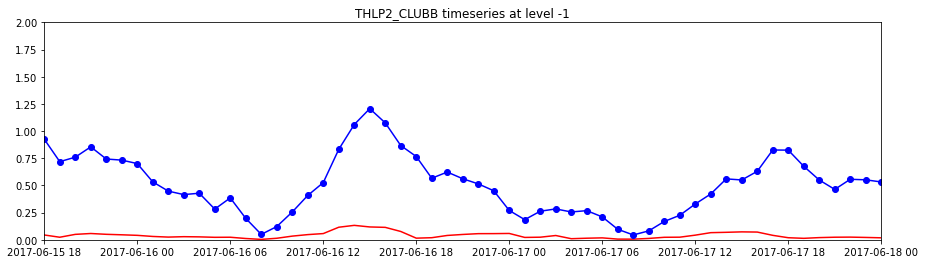

In [27]:
fig,axs = plt.subplots(1,1, figsize=(15,4))

varSel = 'THLP2_CLUBB'
levSel = -1

axs.plot(HMGcamDS_local.time.values, HMGcamDS_local[varSel].values[:,levSel,0,0],'r-')
axs.plot(HTGcamDS_local.time.values, HTGcamDS_local[varSel].values[:,levSel,0,0],'b-o')

startDay   = 15
startMonth = 6
startHr    = 18

endDay     = 18
endMonth   = 6
startYear  = 2017
endYear    = 2017

axs.set_xlim([datetime.datetime(startYear,startMonth,startDay,startHr,0,0), 
              datetime.datetime(endYear,endMonth,endDay,0,0,0)])
    
# Format the date into months & days
axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 

# Set title 
axs.set_title(varSel+' timeseries at level '+str(levSel))
axs.set_ylim([0,2])




(0.0, 16.0)

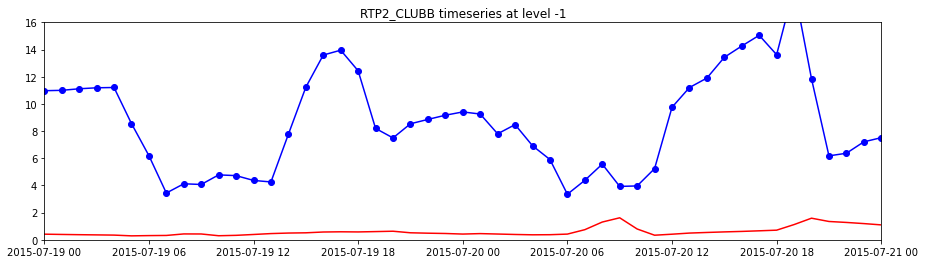

In [28]:
fig,axs = plt.subplots(1,1, figsize=(15,4))

varSel = 'RTP2_CLUBB'
levSel = -1

axs.plot(HMGcamDS_local.time.values, HMGcamDS_local[varSel].values[:,levSel,0,0],'r-')
axs.plot(HTGcamDS_local.time.values, HTGcamDS_local[varSel].values[:,levSel,0,0],'b-o')

startDay   = 19
startMonth = 7
startHr    = 0

endDay     = 21
endMonth   = 7
startYear  = 2015
endYear    = 2015

axs.set_xlim([datetime.datetime(startYear,startMonth,startDay,startHr,0,0), 
              datetime.datetime(endYear,endMonth,endDay,0,0,0)])
    
# Format the date into months & days
axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 

# Set title 
axs.set_title(varSel+' timeseries at level '+str(levSel))
axs.set_ylim([0,16])




In [78]:
## What if we only care about hourly means?


In [83]:
hourlyHMG_local = HMGcamDS_local.resample(time='1H').mean()

In [86]:
hourlyHTG_local = HTGcamDS_local.resample(time='1H').mean()

In [186]:
# Add month_day index
month_day_idx                      = pd.MultiIndex.from_arrays([hourlyHMG_local['time.year'].values,
                                                                hourlyHMG_local['time.month'].values, 
                                                                hourlyHMG_local['time.day'].values])
hourlyHMG_local.coords['year_month_day'] = ('time', month_day_idx)


month_day_idx                      = pd.MultiIndex.from_arrays([hourlyHTG_local['time.year'].values,
                                                                hourlyHTG_local['time.month'].values, 
                                                                hourlyHTG_local['time.day'].values])
hourlyHTG_local.coords['year_month_day'] = ('time', month_day_idx)


(0.0, 16.0)

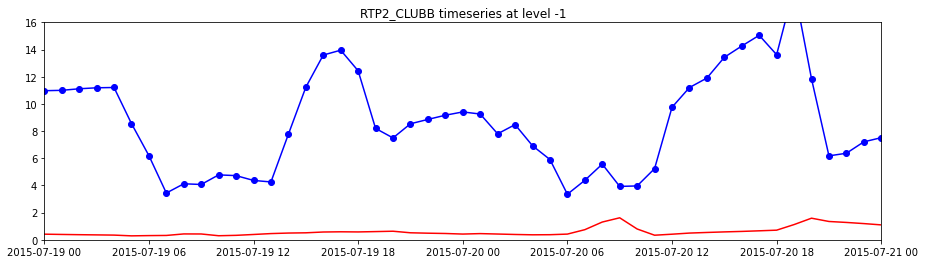

In [88]:
fig,axs = plt.subplots(1,1, figsize=(15,4))

varSel = 'RTP2_CLUBB'
levSel = -1

axs.plot(hourlyHMG_local.time.values, hourlyHMG_local[varSel].values[:,levSel,0,0],'r-')
axs.plot(hourlyHTG_local.time.values, hourlyHTG_local[varSel].values[:,levSel,0,0],'b-o')

startDay   = 19
startMonth = 7
startHr    = 0

endDay     = 21
endMonth   = 7
startYear  = 2015
endYear    = 2015

axs.set_xlim([datetime.datetime(startYear,startMonth,startDay,startHr,0,0), 
              datetime.datetime(endYear,endMonth,endDay,0,0,0)])
    
# Format the date into months & days
axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H')) 

# Set title 
axs.set_title(varSel+' timeseries at level '+str(levSel))
axs.set_ylim([0,16])





## Define wet/dry days (dD/wW especially) 

In [33]:
'''
Function to send back which classification each day falls into, 
based on precipitation amount, similar to Burns et al. (2015; 2018).
This version of the function assumes a single column run/input, 
in that only one dimension exists for precip. 

Inputs: 
   time:   An array of times to worry about. 
           Should be a pandas datetime.
   precip: Daily precipitation (summed). Units can be in mm or m, 
           but need to be consistent with the threshold the user
           defines (i.e., no unit conversions done here).
   wetDef: User-defined threshold for defining days as wet vs. dry. 
Outputs:
    classificationArr: Array with one fewer length than time, where
                       the classification falls into four categories:
                       1 :: wWet   (wet day following a wet day)
                       2 :: wDry   (dry day following a wet day)
                       3 :: dWet   (wet day following a dry day)
                       4 :: dDry   (dry day following a dry day)
                       
                       Difference in length due to the first day not having a 
                       "before" day to reference. So time[0] on the 
                       classification array corresponds to time[1]. 

'''

def classifyPrectDays_SCAM(time,precip,wetDef): 
    
    # Define empty arrays of the appropriate length
    nTimes               = len(time)
    classificationArr    = np.empty([len(time)]).astype('str')
    classificationArr[0] = 'n/a'
    
    for iDay in range(nTimes-1): 
        
        # Wet day...
        if precip[iDay]>=wetDef:
            if precip[iDay+1]>=wetDef:
                classificationArr[iDay+1] = 'wWet'  # Wet day following wet 
            elif precip[iDay+1]<wetDef : 
                classificationArr[iDay+1] = 'wDry' # Dry day following wet 
        # Dry day...
        elif precip[iDay]<wetDef:
            if precip[iDay+1]>=wetDef:
                classificationArr[iDay+1] = 'dWet'  # Wet day following dry 
            elif precip[iDay+1]<wetDef : 
                classificationArr[iDay+1] = 'dDry' # Dry day following dry 

    return(classificationArr)


In [188]:
# ## Use hourly mean data?

# # Get daily means
# HMGcamDS_localDailyMean = hourlyHMG_local.groupby('year_month_day').mean()
# HTGcamDS_localDailyMean = hourlyHTG_local.groupby('year_month_day').mean()

# ## Add in daily total rain for fun... 

# # PRECT defined as mean [m/s] over (now 1 hour) interval, 
# #   so multiply by seconds in an hour and by 1000 mm/m to turn into  [mm/20 min]
# hourlyHMG_local['PRECT_mmPerDT'] = (('time','lat','lon'), hourlyHMG_local.PRECT.values*3600.0*1000.0)
# hourlyHTG_local['PRECT_mmPerDT'] = (('time','lat','lon'), hourlyHTG_local.PRECT.values*3600.0*1000.0)
# # Now sum over the day to get total amount of rainfall
# HMGcamDS_localDailySum = hourlyHMG_local.groupby('year_month_day').sum()
# HTGcamDS_localDailySum = hourlyHTG_local.groupby('year_month_day').sum()

# # Add to daily mean arrays above
# HMGcamDS_localDailyMean['PRECTdailySum'] = (('year_month_day','lat','lon'), HMGcamDS_localDailySum['PRECT_mmPerDT'].values)
# HTGcamDS_localDailyMean['PRECTdailySum'] = (('year_month_day','lat','lon'), HTGcamDS_localDailySum['PRECT_mmPerDT'].values)





In [34]:
# Define classification by day... 

# Define cutoff for classifying a "dry day" [mm/day] 
prectCutoff = 1

## Now get arrays with each day classified as one of four conditions based on wet/dry day preceded by a wet/dry day
classArr_HTG = classifyPrectDays_SCAM(HTGcamDS_localDailySum.year_month_day.values, # Time array 
                                      HTGcamDS_localDailySum.PRECT_mmPerDT.values,  # Precip array 
                                      prectCutoff)                        # Threshold that defines wet/dry days 
classArr_HMG = classifyPrectDays_SCAM(HMGcamDS_localDailySum.year_month_day.values, # Time array 
                                      HMGcamDS_localDailySum.PRECT_mmPerDT.values,  # Precip array 
                                      prectCutoff)                        # Threshold that defines wet/dry days 

## Add that classification to larger datasets
HTGcamDS_localDailySum['dayClass'] = (('year_month_day'), classArr_HTG)
HMGcamDS_localDailySum['dayClass'] = (('year_month_day'), classArr_HMG)

## Find date indices based on each classification:
idDry_HTG = np.where(HTGcamDS_localDailySum['dayClass'].values=='dDry')[0]
idWet_HTG = np.where(HTGcamDS_localDailySum['dayClass'].values=='dWet')[0]
iwDry_HTG = np.where(HTGcamDS_localDailySum['dayClass'].values=='wDry')[0]
iwWet_HTG = np.where(HTGcamDS_localDailySum['dayClass'].values=='wWet')[0]

idDry_HMG = np.where(HMGcamDS_localDailySum['dayClass'].values=='dDry')[0]
idWet_HMG = np.where(HMGcamDS_localDailySum['dayClass'].values=='dWet')[0]
iwDry_HMG = np.where(HMGcamDS_localDailySum['dayClass'].values=='wDry')[0]
iwWet_HMG = np.where(HMGcamDS_localDailySum['dayClass'].values=='wWet')[0]


## Keep only days that agree on classification between HMG and HTG
setHMG_dDry = set(idDry_HMG)
setHTG_dDry = set(idDry_HTG)
iKeep_dDry  = list(setHMG_dDry & setHTG_dDry)
HMG_dDry    = HMGcamDS_localDailySum.isel(year_month_day = iKeep_dDry)
HTG_dDry    = HTGcamDS_localDailySum.isel(year_month_day = iKeep_dDry)


setHMG_dWet = set(idWet_HMG)
setHTG_dWet = set(idWet_HTG)
iKeep_dWet  = list(setHMG_dWet & setHTG_dWet)
HMG_dWet    = HMGcamDS_localDailySum.isel(year_month_day = iKeep_dWet)
HTG_dWet    = HTGcamDS_localDailySum.isel(year_month_day = iKeep_dWet)


setHMG_wDry = set(iwDry_HMG)
setHTG_wDry = set(iwDry_HTG)
iKeep_wDry  = list(setHMG_wDry & setHTG_wDry)
HMG_wDry    = HMGcamDS_localDailySum.isel(year_month_day = iKeep_wDry)
HTG_wDry    = HTGcamDS_localDailySum.isel(year_month_day = iKeep_wDry)


setHMG_wWet = set(iwWet_HMG)
setHTG_wWet = set(iwWet_HTG)
iKeep_wWet  = list(setHMG_wWet & setHTG_wWet)
HMG_wWet    = HMGcamDS_localDailySum.isel(year_month_day = iKeep_wWet)
HTG_wWet    = HTGcamDS_localDailySum.isel(year_month_day = iKeep_wWet)



In [35]:
print('   Number of days in each category   ')
print('         HMG              HTG   ')
print('dDry: %6i %16i' % (len(HMG_dDry.year_month_day.values), len(HTG_dDry.year_month_day.values)) )
print('dWet: %6i %16i' % (len(HMG_dWet.year_month_day.values), len(HTG_dWet.year_month_day.values)) )
print('wDry: %6i %16i' % (len(HMG_wDry.year_month_day.values), len(HTG_wDry.year_month_day.values)) )
print('wWet: %6i %16i' % (len(HMG_wWet.year_month_day.values), len(HTG_wWet.year_month_day.values)) )


   Number of days in each category   
         HMG              HTG   
dDry:     97               97
dWet:     51               51
wDry:     54               54
wWet:    111              111


In [36]:
'''
Find all the times in the full array (20m dt) that line up with the day classifications above. 
'''
def getTimes_basedOnDayClass(fullDS, dayClassDS):
    iTimes = []
    
    for iTime in range(len(dayClassDS.year_month_day.values)):
        iKeepTimes = np.where((fullDS['time.year'] ==dayClassDS.year_month_day_level_0.values[iTime]) &
                              (fullDS['time.month']==dayClassDS.year_month_day_level_1.values[iTime]) & 
                              (fullDS['time.day']  ==dayClassDS.year_month_day_level_2.values[iTime]))[0]    
        iTimes = np.append(iTimes, iKeepTimes).astype(int)
    
    # Now select only those times in the local time array
    DS_dayClass = fullDS.isel(time=iTimes)
    
    return(DS_dayClass)

In [37]:
# Next, get all the times in the full array that line up with each of those classifications above 

dDryDays_HTG = getTimes_basedOnDayClass(HTGcamDS_local, HTG_dDry)
wDryDays_HTG = getTimes_basedOnDayClass(HTGcamDS_local, HTG_wDry)
dWetDays_HTG = getTimes_basedOnDayClass(HTGcamDS_local, HTG_dWet)
wWetDays_HTG = getTimes_basedOnDayClass(HTGcamDS_local, HTG_wWet)

dDryDays_HMG = getTimes_basedOnDayClass(HMGcamDS_local, HMG_dDry)
wDryDays_HMG = getTimes_basedOnDayClass(HMGcamDS_local, HMG_wDry)
dWetDays_HMG = getTimes_basedOnDayClass(HMGcamDS_local, HMG_dWet)
wWetDays_HMG = getTimes_basedOnDayClass(HMGcamDS_local, HMG_wWet)

## Use hourly means 
# dDryDays_HTG = getTimes_basedOnDayClass(hourlyHTG_local, HTG_dDry)
# wDryDays_HTG = getTimes_basedOnDayClass(hourlyHTG_local, HTG_wDry)
# dWetDays_HTG = getTimes_basedOnDayClass(hourlyHTG_local, HTG_dWet)
# wWetDays_HTG = getTimes_basedOnDayClass(hourlyHTG_local, HTG_wWet)

# dDryDays_HMG = getTimes_basedOnDayClass(hourlyHMG_local, HMG_dDry)
# wDryDays_HMG = getTimes_basedOnDayClass(hourlyHMG_local, HMG_wDry)
# dWetDays_HMG = getTimes_basedOnDayClass(hourlyHMG_local, HMG_dWet)
# wWetDays_HMG = getTimes_basedOnDayClass(hourlyHMG_local, HMG_wWet)


In [38]:
# Next, get all the times in the full array that line up with each of those classifications above 

dDryDaysCLM_HTG = getTimes_basedOnDayClass(HTGclmDS_local, HTG_dDry)
wDryDaysCLM_HTG = getTimes_basedOnDayClass(HTGclmDS_local, HTG_wDry)
dWetDaysCLM_HTG = getTimes_basedOnDayClass(HTGclmDS_local, HTG_dWet)
wWetDaysCLM_HTG = getTimes_basedOnDayClass(HTGclmDS_local, HTG_wWet)

dDryDaysCLM_HMG = getTimes_basedOnDayClass(HMGclmDS_local, HMG_dDry)
wDryDaysCLM_HMG = getTimes_basedOnDayClass(HMGclmDS_local, HMG_wDry)
dWetDaysCLM_HMG = getTimes_basedOnDayClass(HMGclmDS_local, HMG_dWet)
wWetDaysCLM_HMG = getTimes_basedOnDayClass(HMGclmDS_local, HMG_wWet)

In [39]:
# Next, get all the times in the full array that line up with each of those classifications above 

dDryDaysPatch_HTG = getTimes_basedOnDayClass(HTGclmDS_patch_local, HTG_dDry)
wDryDaysPatch_HTG = getTimes_basedOnDayClass(HTGclmDS_patch_local, HTG_wDry)
dWetDaysPatch_HTG = getTimes_basedOnDayClass(HTGclmDS_patch_local, HTG_dWet)
wWetDaysPatch_HTG = getTimes_basedOnDayClass(HTGclmDS_patch_local, HTG_wWet)

dDryDaysPatch_HMG = getTimes_basedOnDayClass(HMGclmDS_patch_local, HMG_dDry)
wDryDaysPatch_HMG = getTimes_basedOnDayClass(HMGclmDS_patch_local, HMG_wDry)
dWetDaysPatch_HMG = getTimes_basedOnDayClass(HMGclmDS_patch_local, HMG_dWet)
wWetDaysPatch_HMG = getTimes_basedOnDayClass(HMGclmDS_patch_local, HMG_wWet)

In [40]:
## Add wind speed to underlying DS

windSpeed_dDryDays_HMG = np.sqrt((dDryDays_HMG.U.values**2.0) + (dDryDays_HMG.V.values**2.0))
windSpeed_dDryDays_HTG = np.sqrt((dDryDays_HTG.U.values**2.0) + (dDryDays_HTG.V.values**2.0))

windSpeed_wDryDays_HMG = np.sqrt((wDryDays_HMG.U.values**2.0) + (wDryDays_HMG.V.values**2.0))
windSpeed_wDryDays_HTG = np.sqrt((wDryDays_HTG.U.values**2.0) + (wDryDays_HTG.V.values**2.0))

windSpeed_dWetDays_HMG = np.sqrt((dWetDays_HMG.U.values**2.0) + (dWetDays_HMG.V.values**2.0))
windSpeed_dWetDays_HTG = np.sqrt((dWetDays_HTG.U.values**2.0) + (dWetDays_HTG.V.values**2.0))

windSpeed_wWetDays_HMG = np.sqrt((wWetDays_HMG.U.values**2.0) + (wWetDays_HMG.V.values**2.0))
windSpeed_wWetDays_HTG = np.sqrt((wWetDays_HTG.U.values**2.0) + (wWetDays_HTG.V.values**2.0))


dDryDays_HMG['WindMagnitude'] = (('time','lev'), np.squeeze(windSpeed_dDryDays_HMG))
dDryDays_HTG['WindMagnitude'] = (('time','lev'), np.squeeze(windSpeed_dDryDays_HTG))

wDryDays_HMG['WindMagnitude'] = (('time','lev'), np.squeeze(windSpeed_wDryDays_HMG))
wDryDays_HTG['WindMagnitude'] = (('time','lev'), np.squeeze(windSpeed_wDryDays_HTG))

dWetDays_HMG['WindMagnitude'] = (('time','lev'), np.squeeze(windSpeed_dWetDays_HMG))
dWetDays_HTG['WindMagnitude'] = (('time','lev'), np.squeeze(windSpeed_dWetDays_HTG))

wWetDays_HMG['WindMagnitude'] = (('time','lev'), np.squeeze(windSpeed_wWetDays_HMG))
wWetDays_HTG['WindMagnitude'] = (('time','lev'), np.squeeze(windSpeed_wWetDays_HTG))



In [41]:
# Get means a function of hour of day within each dry/wet day category
hourlyMean_dDry_HMG = dDryDays_HMG.groupby("time.hour").mean()
hourlyMean_dDry_HTG = dDryDays_HTG.groupby("time.hour").mean()

hourlyMean_wDry_HMG = wDryDays_HMG.groupby("time.hour").mean()
hourlyMean_wDry_HTG = wDryDays_HTG.groupby("time.hour").mean()

hourlyMean_dWet_HMG = dWetDays_HMG.groupby("time.hour").mean()
hourlyMean_dWet_HTG = dWetDays_HTG.groupby("time.hour").mean()

hourlyMean_wWet_HMG = wWetDays_HMG.groupby("time.hour").mean()
hourlyMean_wWet_HTG = wWetDays_HTG.groupby("time.hour").mean()

# Get std as function of hour of day too
hourlyStd_dDry_HMG = dDryDays_HMG.groupby("time.hour").std(dim='time')
hourlyStd_dDry_HTG = dDryDays_HTG.groupby("time.hour").std(dim='time')

hourlyStd_wDry_HMG = wDryDays_HMG.groupby("time.hour").std(dim='time')
hourlyStd_wDry_HTG = wDryDays_HTG.groupby("time.hour").std(dim='time')

hourlyStd_dWet_HMG = dWetDays_HMG.groupby("time.hour").std(dim='time')
hourlyStd_dWet_HTG = dWetDays_HTG.groupby("time.hour").std(dim='time')

hourlyStd_wWet_HMG = wWetDays_HMG.groupby("time.hour").std(dim='time')
hourlyStd_wWet_HTG = wWetDays_HTG.groupby("time.hour").std(dim='time')

# Get number of obs going into those hourly means (for error bars)
nTimes_dDry = np.full([24], np.nan)
nTimes_wDry = np.full([24], np.nan)
nTimes_dWet = np.full([24], np.nan)
nTimes_wWet = np.full([24], np.nan)

for iHr in range(24): 
    nTimes_dDry[iHr] = len(np.where(dDryDays_HMG["time.hour"]==iHr)[0])
    nTimes_wDry[iHr] = len(np.where(wDryDays_HMG["time.hour"]==iHr)[0])
    nTimes_dWet[iHr] = len(np.where(dWetDays_HMG["time.hour"]==iHr)[0])
    nTimes_wWet[iHr] = len(np.where(wWetDays_HMG["time.hour"]==iHr)[0])
    
hourlyMean_dDry_HMG['SampleCount']         = (('hour'), nTimes_dDry)
hourlyMean_dDry_HTG['SampleCount']         = (('hour'), nTimes_dDry)

hourlyMean_wDry_HMG['SampleCount']         = (('hour'), nTimes_wDry)
hourlyMean_wDry_HTG['SampleCount']         = (('hour'), nTimes_wDry)

hourlyMean_dWet_HMG['SampleCount']         = (('hour'), nTimes_dWet)
hourlyMean_dWet_HTG['SampleCount']         = (('hour'), nTimes_dWet)

hourlyMean_wWet_HMG['SampleCount']         = (('hour'), nTimes_wWet)
hourlyMean_wWet_HTG['SampleCount']         = (('hour'), nTimes_wWet)




In [42]:
# Get means a function of hour of day for CLM variables too 
hourlyMeanCLM_dDry_HMG = dDryDaysCLM_HMG.groupby("time.hour").mean()
hourlyMeanCLM_dDry_HTG = dDryDaysCLM_HTG.groupby("time.hour").mean()

hourlyMeanCLM_wDry_HMG = wDryDaysCLM_HMG.groupby("time.hour").mean()
hourlyMeanCLM_wDry_HTG = wDryDaysCLM_HTG.groupby("time.hour").mean()

hourlyMeanCLM_dWet_HMG = dWetDaysCLM_HMG.groupby("time.hour").mean()
hourlyMeanCLM_dWet_HTG = dWetDaysCLM_HTG.groupby("time.hour").mean()

hourlyMeanCLM_wWet_HMG = wWetDaysCLM_HMG.groupby("time.hour").mean()
hourlyMeanCLM_wWet_HTG = wWetDaysCLM_HTG.groupby("time.hour").mean()


# And patch-specific variables 
hourlyMeanPatch_dDry_HMG = dDryDaysPatch_HMG.groupby("time.hour").mean()
hourlyMeanPatch_dDry_HTG = dDryDaysPatch_HTG.groupby("time.hour").mean()

hourlyMeanPatch_wDry_HMG = wDryDaysPatch_HMG.groupby("time.hour").mean()
hourlyMeanPatch_wDry_HTG = wDryDaysPatch_HTG.groupby("time.hour").mean()

hourlyMeanPatch_dWet_HMG = dWetDaysPatch_HMG.groupby("time.hour").mean()
hourlyMeanPatch_dWet_HTG = dWetDaysPatch_HTG.groupby("time.hour").mean()

hourlyMeanPatch_wWet_HMG = wWetDaysPatch_HMG.groupby("time.hour").mean()
hourlyMeanPatch_wWet_HTG = wWetDaysPatch_HTG.groupby("time.hour").mean()



### Now look at some plots!

In [43]:
## Print some summary daily means for each case 

print('                   dDry      wDry      dWet      wWet')
print('                   -----     -----     -----     -----')
print('Daily rain (HMG): %6.2f %8.2f %9.2f %9.2f' % (np.nanmean(HMG_dDry.PRECT_mmPerDT.values), 
                                                     np.nanmean(HMG_wDry.PRECT_mmPerDT.values),
                                                     np.nanmean(HMG_dWet.PRECT_mmPerDT.values),
                                                     np.nanmean(HMG_wWet.PRECT_mmPerDT.values)))
print('           (HTG): %6.2f %8.2f %9.2f %9.2f' % (np.nanmean(HTG_dDry.PRECT_mmPerDT.values), 
                                                     np.nanmean(HTG_wDry.PRECT_mmPerDT.values),
                                                     np.nanmean(HTG_dWet.PRECT_mmPerDT.values),
                                                     np.nanmean(HTG_wWet.PRECT_mmPerDT.values)))
print()
varSel = 'TGCLDLWP'
print('Daily TGCLDLWP (HMG): %4.2e %8.2e %9.2e %9.2e' % (np.nanmean(hourlyMean_dDry_HMG[varSel].values), 
                                                       np.nanmean(hourlyMean_wDry_HMG[varSel].values),
                                                       np.nanmean(hourlyMean_dWet_HMG[varSel].values),
                                                       np.nanmean(hourlyMean_wWet_HMG[varSel].values)))
print('               (HTG): %4.2e %8.2e %9.2e %9.2e' % (np.nanmean(hourlyMean_dDry_HTG[varSel].values), 
                                                       np.nanmean(hourlyMean_wDry_HTG[varSel].values),
                                                       np.nanmean(hourlyMean_dWet_HTG[varSel].values),
                                                       np.nanmean(hourlyMean_wWet_HTG[varSel].values)))

print()
varSel = 'CLDTOT'
print('Daily CLDTOT (HMG): %4.2f %8.2f %9.2f %9.2f' % (np.nanmean(hourlyMean_dDry_HMG[varSel].values), 
                                                       np.nanmean(hourlyMean_wDry_HMG[varSel].values),
                                                       np.nanmean(hourlyMean_dWet_HMG[varSel].values),
                                                       np.nanmean(hourlyMean_wWet_HMG[varSel].values)))
print('             (HTG): %4.2f %8.2f %9.2f %9.2f' % (np.nanmean(hourlyMean_dDry_HTG[varSel].values), 
                                                       np.nanmean(hourlyMean_wDry_HTG[varSel].values),
                                                       np.nanmean(hourlyMean_dWet_HTG[varSel].values),
                                                       np.nanmean(hourlyMean_wWet_HTG[varSel].values)))

print()
varSel = 'CLDLOW'
print('Daily CLDLOW (HMG): %4.2f %8.2f %9.2f %9.2f' % (np.nanmean(hourlyMean_dDry_HMG[varSel].values), 
                                                       np.nanmean(hourlyMean_wDry_HMG[varSel].values),
                                                       np.nanmean(hourlyMean_dWet_HMG[varSel].values),
                                                       np.nanmean(hourlyMean_wWet_HMG[varSel].values)))
print('             (HTG): %4.2f %8.2f %9.2f %9.2f' % (np.nanmean(hourlyMean_dDry_HTG[varSel].values), 
                                                       np.nanmean(hourlyMean_wDry_HTG[varSel].values),
                                                       np.nanmean(hourlyMean_dWet_HTG[varSel].values),
                                                       np.nanmean(hourlyMean_wWet_HTG[varSel].values)))

print()
varSel = 'CLDMED'
print('Daily CLDMED (HMG): %4.2f %8.2f %9.2f %9.2f' % (np.nanmean(hourlyMean_dDry_HMG[varSel].values), 
                                                       np.nanmean(hourlyMean_wDry_HMG[varSel].values),
                                                       np.nanmean(hourlyMean_dWet_HMG[varSel].values),
                                                       np.nanmean(hourlyMean_wWet_HMG[varSel].values)))
print('             (HTG): %4.2f %8.2f %9.2f %9.2f' % (np.nanmean(hourlyMean_dDry_HTG[varSel].values), 
                                                       np.nanmean(hourlyMean_wDry_HTG[varSel].values),
                                                       np.nanmean(hourlyMean_dWet_HTG[varSel].values),
                                                       np.nanmean(hourlyMean_wWet_HTG[varSel].values)))
print()
varSel = 'CLDHGH'
print('Daily CLDHGH (HMG): %4.2f %8.2f %9.2f %9.2f' % (np.nanmean(hourlyMean_dDry_HMG[varSel].values), 
                                                       np.nanmean(hourlyMean_wDry_HMG[varSel].values),
                                                       np.nanmean(hourlyMean_dWet_HMG[varSel].values),
                                                       np.nanmean(hourlyMean_wWet_HMG[varSel].values)))
print('             (HTG): %4.2f %8.2f %9.2f %9.2f' % (np.nanmean(hourlyMean_dDry_HTG[varSel].values), 
                                                       np.nanmean(hourlyMean_wDry_HTG[varSel].values),
                                                       np.nanmean(hourlyMean_dWet_HTG[varSel].values),
                                                       np.nanmean(hourlyMean_wWet_HTG[varSel].values)))
print()
varSel = 'QFLX_EVAP_TOT'
print('Daily ET (HMG): %9.2e %10.2e %10.2e %10.2e' % (np.nanmean(hourlyMeanCLM_dDry_HMG[varSel].values), 
                                                       np.nanmean(hourlyMeanCLM_wDry_HMG[varSel].values),
                                                       np.nanmean(hourlyMeanCLM_dWet_HMG[varSel].values),
                                                       np.nanmean(hourlyMeanCLM_wWet_HMG[varSel].values)))
print('         (HTG): %9.2e %10.2e %10.2e %10.2e' % (np.nanmean(hourlyMeanCLM_dDry_HTG[varSel].values), 
                                                       np.nanmean(hourlyMeanCLM_wDry_HTG[varSel].values),
                                                       np.nanmean(hourlyMeanCLM_dWet_HTG[varSel].values),
                                                       np.nanmean(hourlyMeanCLM_wWet_HTG[varSel].values)))
print()
varSel = 'FSH'
print('Daily SHFLX (HMG): %9.2e %10.2e %10.2e %10.2e' % (np.nanmean(hourlyMeanCLM_dDry_HMG[varSel].values), 
                                                       np.nanmean(hourlyMeanCLM_wDry_HMG[varSel].values),
                                                       np.nanmean(hourlyMeanCLM_dWet_HMG[varSel].values),
                                                       np.nanmean(hourlyMeanCLM_wWet_HMG[varSel].values)))
print('            (HTG): %9.2e %10.2e %10.2e %10.2e' % (np.nanmean(hourlyMeanCLM_dDry_HTG[varSel].values), 
                                                       np.nanmean(hourlyMeanCLM_wDry_HTG[varSel].values),
                                                       np.nanmean(hourlyMeanCLM_dWet_HTG[varSel].values),
                                                       np.nanmean(hourlyMeanCLM_wWet_HTG[varSel].values)))

print()
varSel = 'SOILWATER_10CM'
print('Daily SM_10CM (HMG): %4.2f %8.2f %8.2f %8.2f' % (np.nanmean(hourlyMeanCLM_dDry_HMG[varSel].values), 
                                                       np.nanmean(hourlyMeanCLM_wDry_HMG[varSel].values),
                                                       np.nanmean(hourlyMeanCLM_dWet_HMG[varSel].values),
                                                       np.nanmean(hourlyMeanCLM_wWet_HMG[varSel].values)))
print('              (HTG): %4.2f %8.2f %8.2f %8.2f' % (np.nanmean(hourlyMeanCLM_dDry_HTG[varSel].values), 
                                                       np.nanmean(hourlyMeanCLM_wDry_HTG[varSel].values),
                                                       np.nanmean(hourlyMeanCLM_dWet_HTG[varSel].values),
                                                       np.nanmean(hourlyMeanCLM_wWet_HTG[varSel].values)))


                   dDry      wDry      dWet      wWet
                   -----     -----     -----     -----
Daily rain (HMG):   0.16     0.34      5.38      8.91
           (HTG):   0.15     0.28      5.10      8.31

Daily TGCLDLWP (HMG): 1.23e-02 3.72e-02  8.94e-02  1.18e-01
               (HTG): 1.24e-02 3.64e-02  8.11e-02  1.16e-01

Daily CLDTOT (HMG): 0.52     0.74      0.86      0.94
             (HTG): 0.51     0.73      0.89      0.94

Daily CLDLOW (HMG): 0.02     0.05      0.07      0.15
             (HTG): 0.01     0.04      0.07      0.15

Daily CLDMED (HMG): 0.14     0.25      0.51      0.48
             (HTG): 0.16     0.27      0.55      0.48

Daily CLDHGH (HMG): 0.47     0.67      0.80      0.92
             (HTG): 0.45     0.66      0.82      0.92

Daily ET (HMG):  3.83e-05   3.52e-05   4.00e-05   3.64e-05
         (HTG):  3.72e-05   3.34e-05   3.88e-05   3.46e-05

Daily SHFLX (HMG):  6.27e+01   5.28e+01   2.63e+01   2.36e+01
            (HTG):  6.30e+01   5.45e+01   2.

**Mean diurnal cycles near the surface**

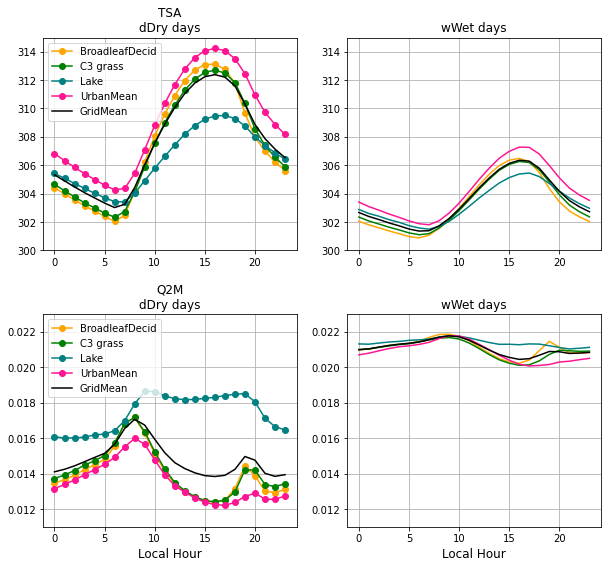

In [45]:
## Figure for manuscript

varSel = np.asarray(['TSA','Q2M'])
patchLabels[0] = 'BroadleafDecid'

fig,axs = plt.subplots(len(varSel),2, figsize=(10,9))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.3)


yMax = np.asarray([315, 0.023])
yMin = np.asarray([300, 0.011])

iPlot=0
for iVar in range(len(varSel)):
    ## Get urban mean
    iUrban = np.where((colType>=70) & (colType<80))[0]

    varSel_urban_dDry = np.nansum(hourlyMeanPatch_dDry_HTG[varSel[iVar]].values[:, iUrban]*PFTwgt[iUrban], axis=1)/np.nansum(PFTwgt[iUrban])
    varSel_urban_wWet = np.nansum(hourlyMeanPatch_wWet_HTG[varSel[iVar]].values[:, iUrban]*PFTwgt[iUrban], axis=1)/np.nansum(PFTwgt[iUrban])

    ## dDry days 
    axs[iPlot].plot(hourlyMeanPatch_dDry_HTG.hour.values, np.squeeze(hourlyMeanPatch_dDry_HTG[varSel[iVar]].values[:, 0]),
             'o-', color='orange', label=patchLabels[0])
    axs[iPlot].plot(hourlyMeanPatch_dDry_HTG.hour.values, np.squeeze(hourlyMeanPatch_dDry_HTG[varSel[iVar]].values[:, 1]),
             'o-',color='green', label=patchLabels[1])
    axs[iPlot].plot(hourlyMeanPatch_dDry_HTG.hour.values, np.squeeze(hourlyMeanPatch_dDry_HTG[varSel[iVar]].values[:, -1]),
             'o-',color='teal',label=patchLabels[-1])
    axs[iPlot].plot(hourlyMeanCLM_dDry_HTG.hour.values, varSel_urban_dDry,
             'o-',color='deeppink',label='UrbanMean')
    axs[iPlot].plot(hourlyMeanCLM_dDry_HTG.hour.values, hourlyMeanCLM_dDry_HTG[varSel[iVar]].values, 'k-',label='GridMean')
    axs[iPlot].legend(loc='upper left',fontsize=10)
#     axs[iPlot].set_title(HTGclmDS_patch_local[varSel[iVar]].long_name+'\ndDry days')
    axs[iPlot].set_title(varSel[iVar]+'\ndDry days')
    axs[iPlot].set_ylim([yMin[iVar], yMax[iVar]])


    ## wWet days 
    axs[iPlot+1].plot(hourlyMeanPatch_wWet_HTG.hour.values, np.squeeze(hourlyMeanPatch_wWet_HTG[varSel[iVar]].values[:, 0]),
             color='orange',label=patchLabels[0])
    axs[iPlot+1].plot(hourlyMeanPatch_wWet_HTG.hour.values, np.squeeze(hourlyMeanPatch_wWet_HTG[varSel[iVar]].values[:, 1]),
             color='green',label=patchLabels[1])
    axs[iPlot+1].plot(hourlyMeanPatch_wWet_HTG.hour.values, np.squeeze(hourlyMeanPatch_wWet_HTG[varSel[iVar]].values[:, -1]),
             color='teal',label=patchLabels[-1])
    axs[iPlot+1].plot(hourlyMeanCLM_wWet_HTG.hour.values, varSel_urban_wWet,
             color='deeppink',label='UrbanMean')
    axs[iPlot+1].plot(hourlyMeanCLM_wWet_HTG.hour.values, hourlyMeanCLM_wWet_HTG[varSel[iVar]].values, 'k-',label='GridMean')
    axs[iPlot+1].set_title('\nwWet days')
    axs[iPlot+1].set_ylim([yMin[iVar], yMax[iVar]])

#     axs[iPlot+0].grid()
#     axs[iPlot+1].grid()
    
    if iVar==(len(varSel)-1):
        axs[iPlot].set_xlabel('Local Hour', fontsize=12)
        axs[iPlot+1].set_xlabel('Local Hour', fontsize=12)

    iPlot = iPlot+2


axs[0].grid()
axs[1].grid()
axs[2].grid()
axs[3].grid()


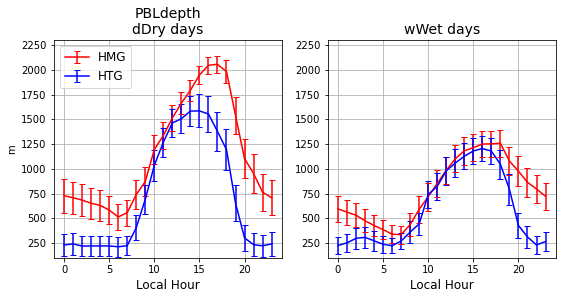

In [47]:
## Fig for manuscript 

# varSel = np.asarray(['PBLdepth','CLDTOT','TREFHT','QREFHT'])
varSel = np.asarray(['PBLdepth'])

fig,axs = plt.subplots(len(varSel),2, figsize=(9,4))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.5)

# yMax = np.asarray([2600, 1.05,  315, 0.0240])
# yMin = np.asarray([ 200, 0.3,   298, 0.0120])
yMax = np.asarray([2300])
yMin = np.asarray([ 100])

iPlot=0
for iVar in range(len(varSel)):
    axs[iPlot+0].errorbar(hourlyMean_dDry_HMG.hour.values, np.squeeze(hourlyMean_dDry_HMG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HMG[varSel[iVar]].values)/np.sqrt(hourlyMean_dDry_HMG['SampleCount'].values),
                          fmt='r-', capsize=3, label='HMG')
    axs[iPlot+0].errorbar(hourlyMean_dDry_HTG.hour.values, np.squeeze(hourlyMean_dDry_HTG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HTG[varSel[iVar]].values)/np.sqrt(hourlyMean_dDry_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    if iVar==0:
        axs[iPlot+0].legend(loc='upper left',fontsize=12)
    axs[iPlot+0].set_title(varSel[iVar]+'\ndDry days', fontsize=14)
    if varSel[iVar]=='PBLdepth':
#         axs[iPlot].set_ylabel(HTGcamDS_local['PBLH'].units)
        axs[iPlot].set_ylabel('m')
    else: 
        axs[iPlot].set_ylabel(HTGcamDS_local[varSel[iVar]].units, fontsize=12)
 

    axs[iPlot+1].errorbar(hourlyMean_wWet_HMG.hour.values, np.squeeze(hourlyMean_wWet_HMG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HMG[varSel[iVar]].values)/np.sqrt(hourlyMean_wWet_HMG['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+1].errorbar(hourlyMean_wWet_HTG.hour.values, np.squeeze(hourlyMean_wWet_HTG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HTG[varSel[iVar]].values)/np.sqrt(hourlyMean_wWet_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+1].set_title('\nwWet days', fontsize=14)  
    
    axs[iPlot+0].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+1].set_ylim([yMin[iVar],yMax[iVar]])
    
    axs[iPlot+0].grid()
    axs[iPlot+1].grid()
    
    if iVar==(len(varSel)-1):
        axs[iPlot].set_xlabel('Local Hour', fontsize=12)
        axs[iPlot+1].set_xlabel('Local Hour', fontsize=12)

    iPlot = iPlot+2

    

In [36]:
startHr = 15
endHr   = 18
iTimeSel_dDryHMG = np.where((dDryDays_HMG["time.hour"].values>=startHr) & 
                            (dDryDays_HMG["time.hour"].values<=endHr))[0]
iTimeSel_dDryHTG = np.where((dDryDays_HTG["time.hour"].values>=startHr) & 
                            (dDryDays_HTG["time.hour"].values<=endHr))[0]

hourlyMean_dDryTimeSel_HMG = dDryDays_HMG.isel(time=iTimeSel_dDryHMG).mean(dim='time')
hourlyMean_dDryTimeSel_HTG = dDryDays_HTG.isel(time=iTimeSel_dDryHTG).mean(dim='time')

print('Mean PBLdepth_HMG from %i to %i hrs: %.3f' % (startHr, endHr, hourlyMean_dDryTimeSel_HMG.PBLdepth.values))
print('Mean PBLdepth_HTG from %i to %i hrs: %.3f' % (startHr, endHr, hourlyMean_dDryTimeSel_HTG.PBLdepth.values))

Mean PBLdepth_HMG from 15 to 18 hrs: 2014.342
Mean PBLdepth_HTG from 15 to 18 hrs: 1438.555


AttributeError: 'DataArray' object has no attribute 'units'

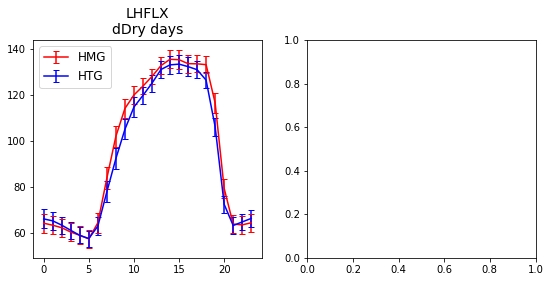

In [48]:
## Fig for manuscript 

# varSel = np.asarray(['PBLdepth','CLDTOT','TREFHT','QREFHT'])
varSel = np.asarray(['LHFLX'])

fig,axs = plt.subplots(len(varSel),2, figsize=(9,4))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.5)

# yMax = np.asarray([2600, 1.05,  315, 0.0240])
# yMin = np.asarray([ 200, 0.3,   298, 0.0120])
yMax = np.asarray([180])
yMin = np.asarray([ 30])

iPlot=0
for iVar in range(len(varSel)):
    axs[iPlot+0].errorbar(hourlyMean_dDry_HMG.hour.values, np.squeeze(hourlyMean_dDry_HMG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HMG[varSel[iVar]].values)/np.sqrt(hourlyMean_dDry_HMG['SampleCount'].values),
                          fmt='r-', capsize=3, label='HMG')
    axs[iPlot+0].errorbar(hourlyMean_dDry_HTG.hour.values, np.squeeze(hourlyMean_dDry_HTG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HTG[varSel[iVar]].values)/np.sqrt(hourlyMean_dDry_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    if iVar==0:
        axs[iPlot+0].legend(loc='upper left',fontsize=12)
    axs[iPlot+0].set_title(varSel[iVar]+'\ndDry days', fontsize=14)
    if varSel[iVar]=='PBLdepth':
        axs[iPlot].set_ylabel(HTGcamDS_local['PBLH'].units)
    else: 
        axs[iPlot].set_ylabel(HTGcamDS_local[varSel[iVar]].units, fontsize=12)
 

    axs[iPlot+1].errorbar(hourlyMean_wWet_HMG.hour.values, np.squeeze(hourlyMean_wWet_HMG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HMG[varSel[iVar]].values)/np.sqrt(hourlyMean_wWet_HMG['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+1].errorbar(hourlyMean_wWet_HTG.hour.values, np.squeeze(hourlyMean_wWet_HTG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HTG[varSel[iVar]].values)/np.sqrt(hourlyMean_wWet_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+1].set_title('\nwWet days', fontsize=14)  
    
    axs[iPlot+0].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+1].set_ylim([yMin[iVar],yMax[iVar]])
    
#     axs[iPlot+0].grid()
#     axs[iPlot+1].grid()
    
    if iVar==(len(varSel)-1):
        axs[iPlot].set_xlabel('Local Hour', fontsize=12)
        axs[iPlot+1].set_xlabel('Local Hour', fontsize=12)

    iPlot = iPlot+2



AttributeError: 'DataArray' object has no attribute 'units'

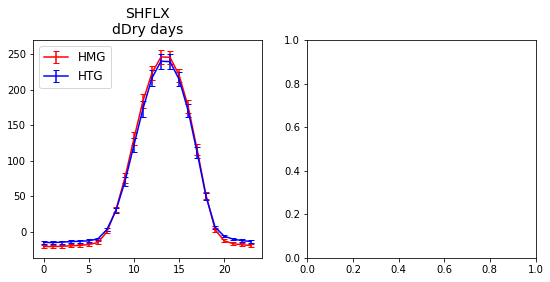

In [49]:
## Fig for manuscript 

# varSel = np.asarray(['PBLdepth','CLDTOT','TREFHT','QREFHT'])
varSel = np.asarray(['SHFLX'])

fig,axs = plt.subplots(len(varSel),2, figsize=(9,4))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.5)

# yMax = np.asarray([2600, 1.05,  315, 0.0240])
# yMin = np.asarray([ 200, 0.3,   298, 0.0120])
yMax = np.asarray([260])
yMin = np.asarray([ -50])

iPlot=0
for iVar in range(len(varSel)):
    axs[iPlot+0].errorbar(hourlyMean_dDry_HMG.hour.values, np.squeeze(hourlyMean_dDry_HMG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HMG[varSel[iVar]].values)/np.sqrt(hourlyMean_dDry_HMG['SampleCount'].values),
                          fmt='r-', capsize=3, label='HMG')
    axs[iPlot+0].errorbar(hourlyMean_dDry_HTG.hour.values, np.squeeze(hourlyMean_dDry_HTG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HTG[varSel[iVar]].values)/np.sqrt(hourlyMean_dDry_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    if iVar==0:
        axs[iPlot+0].legend(loc='upper left',fontsize=12)
    axs[iPlot+0].set_title(varSel[iVar]+'\ndDry days', fontsize=14)
    if varSel[iVar]=='PBLdepth':
        axs[iPlot].set_ylabel(HTGcamDS_local['PBLH'].units)
    else: 
        axs[iPlot].set_ylabel(HTGcamDS_local[varSel[iVar]].units, fontsize=12)
 

    axs[iPlot+1].errorbar(hourlyMean_wWet_HMG.hour.values, np.squeeze(hourlyMean_wWet_HMG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HMG[varSel[iVar]].values)/np.sqrt(hourlyMean_wWet_HMG['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+1].errorbar(hourlyMean_wWet_HTG.hour.values, np.squeeze(hourlyMean_wWet_HTG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HTG[varSel[iVar]].values)/np.sqrt(hourlyMean_wWet_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+1].set_title('\nwWet days', fontsize=14)  
    
    axs[iPlot+0].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+1].set_ylim([yMin[iVar],yMax[iVar]])
    
#     axs[iPlot+0].grid()
#     axs[iPlot+1].grid()
    
    if iVar==(len(varSel)-1):
        axs[iPlot].set_xlabel('Local Hour', fontsize=12)
        axs[iPlot+1].set_xlabel('Local Hour', fontsize=12)

    iPlot = iPlot+2


AttributeError: 'DataArray' object has no attribute 'long_name'

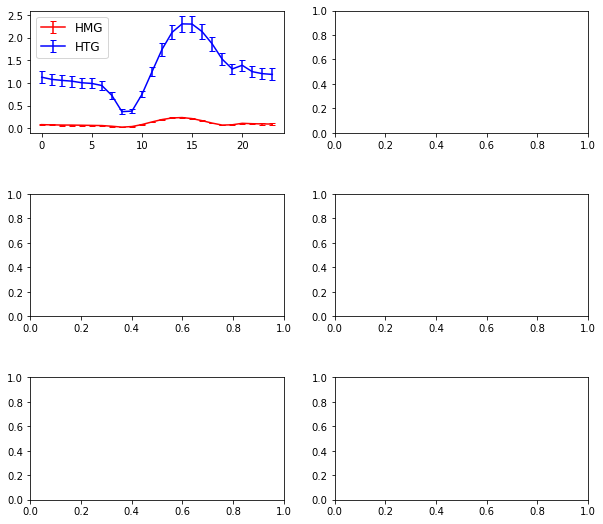

In [50]:
## Fig for manuscript 

varSel = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB'])

fig,axs = plt.subplots(len(varSel),2, figsize=(10,9))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.5)

# yMax = np.asarray([2600, 280, 250, 314, 0.0210, 1.05, 0.3, 1.0])
# yMin = np.asarray([ 200, -50, -10, 295, 0.0120, 0.3, 0.0, 0.0])
yMax = np.asarray([3.0, 9.0,  0.2])
yMin = np.asarray([0.0, 0.0, -4.0])

iPlot=0
for iVar in range(len(varSel)):
    axs[iPlot+0].errorbar(hourlyMean_dDry_HMG.hour.values, np.squeeze(hourlyMean_dDry_HMG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HMG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_dDry_HMG['SampleCount'].values),
                          fmt='r-', capsize=3, label='HMG')
    axs[iPlot+0].errorbar(hourlyMean_dDry_HTG.hour.values, np.squeeze(hourlyMean_dDry_HTG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HTG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_dDry_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    if iVar==0:
        axs[iPlot+0].legend(loc='upper left',fontsize=12)
    axs[iPlot+0].set_title(HMGcamDS_local[varSel[iVar]].long_name+'\ndDry days', fontsize=14)
    if varSel[iVar]=='PBLdepth':
        axs[iPlot].set_ylabel(HTGcamDS_local['PBLH'].units)
    else: 
        axs[iPlot].set_ylabel(HTGcamDS_local[varSel[iVar]].units, fontsize=12)
 

    axs[iPlot+1].errorbar(hourlyMean_wWet_HMG.hour.values, np.squeeze(hourlyMean_wWet_HMG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HMG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_wWet_HMG['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+1].errorbar(hourlyMean_wWet_HTG.hour.values, np.squeeze(hourlyMean_wWet_HTG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HTG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_wWet_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+1].set_title('\nwWet days', fontsize=14)  
    
    axs[iPlot+0].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+1].set_ylim([yMin[iVar],yMax[iVar]])
    
#     axs[iPlot+0].grid()
#     axs[iPlot+1].grid()
    
    if iVar==(len(varSel)-1):
        axs[iPlot].set_xlabel('Local Hour', fontsize=12)
        axs[iPlot+1].set_xlabel('Local Hour', fontsize=12)

    iPlot = iPlot+2



AttributeError: 'DataArray' object has no attribute 'long_name'

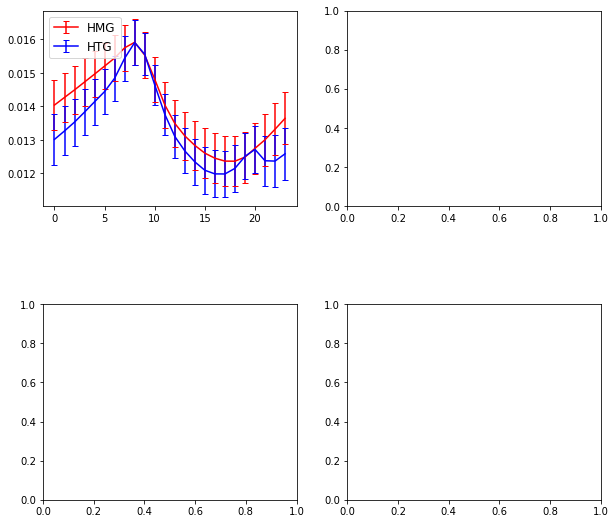

In [51]:
## Fig for manuscript 

varSel = np.asarray(['Q','T'])

fig,axs = plt.subplots(len(varSel),2, figsize=(10,9))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.5)

# yMax = np.asarray([2600, 280, 250, 314, 0.0210, 1.05, 0.3, 1.0])
# yMin = np.asarray([ 200, -50, -10, 295, 0.0120, 0.3, 0.0, 0.0])
yMax = np.asarray([0.025, 320])
yMin = np.asarray([0.01,  300])

iPlot=0
for iVar in range(len(varSel)):
    axs[iPlot+0].errorbar(hourlyMean_dDry_HMG.hour.values, np.squeeze(hourlyMean_dDry_HMG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HMG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_dDry_HMG['SampleCount'].values),
                          fmt='r-', capsize=3, label='HMG')
    axs[iPlot+0].errorbar(hourlyMean_dDry_HTG.hour.values, np.squeeze(hourlyMean_dDry_HTG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HTG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_dDry_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    if iVar==0:
        axs[iPlot+0].legend(loc='upper left',fontsize=12)
    axs[iPlot+0].set_title(HMGcamDS_local[varSel[iVar]].long_name+'\ndDry days', fontsize=14)
    if varSel[iVar]=='PBLdepth':
        axs[iPlot].set_ylabel(HTGcamDS_local['PBLH'].units)
    else: 
        axs[iPlot].set_ylabel(HTGcamDS_local[varSel[iVar]].units, fontsize=12)
 

    axs[iPlot+1].errorbar(hourlyMean_wWet_HMG.hour.values, np.squeeze(hourlyMean_wWet_HMG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HMG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_wWet_HMG['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+1].errorbar(hourlyMean_wWet_HTG.hour.values, np.squeeze(hourlyMean_wWet_HTG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HTG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_wWet_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+1].set_title('\nwWet days', fontsize=14)  
    
    axs[iPlot+0].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+1].set_ylim([yMin[iVar],yMax[iVar]])
    
#     axs[iPlot+0].grid()
#     axs[iPlot+1].grid()
    
    if iVar==(len(varSel)-1):
        axs[iPlot].set_xlabel('Local Hour', fontsize=12)
        axs[iPlot+1].set_xlabel('Local Hour', fontsize=12)

    iPlot = iPlot+2


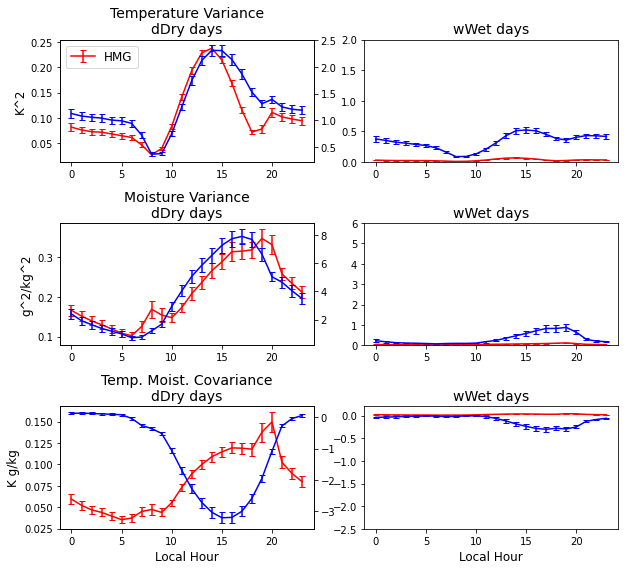

In [45]:
## Plot moments diuranl cycle with two y-axes for dry days

varSel = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB'])

fig,axs = plt.subplots(len(varSel),2, figsize=(10,9))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.5)

# yMax = np.asarray([2600, 280, 250, 314, 0.0210, 1.05, 0.3, 1.0])
# yMin = np.asarray([ 200, -50, -10, 295, 0.0120, 0.3, 0.0, 0.0])
yMax = np.asarray([2.0, 6.0,  0.2])
yMin = np.asarray([0.0, 0.0, -2.5])

iPlot=0
for iVar in range(len(varSel)):
    axs[iPlot+0].errorbar(hourlyMean_dDry_HMG.hour.values, np.squeeze(hourlyMean_dDry_HMG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HMG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_dDry_HMG['SampleCount'].values),
                          fmt='r-', capsize=3, label='HMG')
    axs2 = axs[iPlot+0].twinx()
    axs2.errorbar(hourlyMean_dDry_HTG.hour.values, np.squeeze(hourlyMean_dDry_HTG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_dDry_HTG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_dDry_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    
    if iVar==0:
        axs[iPlot+0].legend(loc='upper left',fontsize=12)
    axs[iPlot+0].set_title(HMGcamDS_local[varSel[iVar]].long_name+'\ndDry days', fontsize=14)
    if varSel[iVar]=='PBLdepth':
        axs[iPlot].set_ylabel(HTGcamDS_local['PBLH'].units)
    else: 
        axs[iPlot].set_ylabel(HTGcamDS_local[varSel[iVar]].units, fontsize=12)
 

    axs[iPlot+1].errorbar(hourlyMean_wWet_HMG.hour.values, np.squeeze(hourlyMean_wWet_HMG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HMG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_wWet_HMG['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+1].errorbar(hourlyMean_wWet_HTG.hour.values, np.squeeze(hourlyMean_wWet_HTG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_wWet_HTG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_wWet_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+1].set_title('\nwWet days', fontsize=14)  
    
#     axs[iPlot+0].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+1].set_ylim([yMin[iVar],yMax[iVar]])
    
#     axs[iPlot+0].grid()
#     axs[iPlot+1].grid()
    
    if iVar==(len(varSel)-1):
        axs[iPlot].set_xlabel('Local Hour', fontsize=12)
        axs[iPlot+1].set_xlabel('Local Hour', fontsize=12)

    iPlot = iPlot+2





**Come up with a way to look at time/height profiles with significance**

In [171]:
def plotTimeHeightDifference_meanDiurnalCycle(varSel,minLev,maxLev,cMin,cMax): 
    
    diffVar_dry = np.squeeze(hourlyMean_dDry_HTG[varSel].values - hourlyMean_dDry_HMG[varSel].values)
    diffVar_wet = np.squeeze(hourlyMean_wWet_HTG[varSel].values - hourlyMean_wWet_HMG[varSel].values)
 
    ## Select which levels array to use
    if np.shape(hourlyMean_dDry_HTG[varSel].values)[1]==len(hourlyMean_dDry_HTG.ilev.values): 
        levSel = 'ilev'
    elif np.shape(hourlyMean_dDry_HTG[varSel].values)[1]==len(hourlyMean_dDry_HTG.lev.values):
        levSel = 'lev'
    
    ## Set up figure
    fig,axs = plt.subplots(1,2, figsize=(10,4))
    axs     = axs.ravel()
    
    # Plot dry day difference 
    contour_plot = axs[0].pcolormesh(hourlyMean_dDry_HTG.hour.values, hourlyMean_dDry_HTG[levSel].values, 
                                     diffVar_dry.transpose(),
                                     vmin=cMin, vmax=cMax, cmap='bwr')
    
    # Add contours of theta
    def fmt(x):
        s = f"{x:.1f}"
        if s.endswith("0"):
            s = f"{x:.0f}"
        return rf"{s} \K" if plt.rcParams["text.usetex"] else f"{s} K"

    cT = axs[0].contour(hourlyMean_dDry_HTG.hour.values, hourlyMean_dDry_HTG['lev'].values, 
                        np.squeeze(hourlyMean_dDry_HTG['T'].values).transpose(),
                        np.arange(298,312,2), colors='darkgrey')
    axs[0].clabel(cT, cT.levels, inline=True, fmt=fmt, fontsize=10)
    
    
    
    # Plot wet day difference 
    contour_plot = axs[1].pcolormesh(hourlyMean_wWet_HTG.hour.values, hourlyMean_wWet_HTG[levSel].values, 
                                     diffVar_wet.transpose(),
                                     vmin=cMin, vmax=cMax, cmap='bwr')
    # Add colorbar
    ax_position = axs[1].get_position()
    cbar_ax = fig.add_axes([ax_position.x0-0.3, ax_position.y0-0.2, ax_position.width+0.15, 0.03])
    cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
    if varSel=='WindMagnitude':
        cbar.set_label('m/s',fontsize=11)
    elif varSel=='TKE':
        cbar.set_label('m2/s2',fontsize=11)
    elif varSel=='Skw_W':
        cbar.set_label('',fontsize=11)
    else:
        cbar.set_label(HTGcamDS_all[varSel].units,fontsize=11)
    
    ## Add markers of significant differences 
    for il in range(len(hourlyMean_wWet_HTG[levSel].values)):
        stdErr_dDry_HMG = np.squeeze(hourlyStd_dDry_HMG[varSel].values)[:,il]/np.sqrt(hourlyMean_dDry_HMG['SampleCount'].values)
        stdErr_dDry_HTG = np.squeeze(hourlyStd_dDry_HTG[varSel].values)[:,il]/np.sqrt(hourlyMean_dDry_HTG['SampleCount'].values)
       
        stdErr_wWet_HMG = np.squeeze(hourlyStd_wWet_HMG[varSel].values)[:,il]/np.sqrt(hourlyMean_wWet_HMG['SampleCount'].values)
        stdErr_wWet_HTG = np.squeeze(hourlyStd_wWet_HTG[varSel].values)[:,il]/np.sqrt(hourlyMean_wWet_HTG['SampleCount'].values)
        
    
        xmax1_dry = np.squeeze(hourlyMean_dDry_HMG[varSel].values)[:,il] + (2*stdErr_dDry_HMG)
        xmin1_dry = np.squeeze(hourlyMean_dDry_HMG[varSel].values)[:,il] - (2*stdErr_dDry_HMG)
        xmax2_dry = np.squeeze(hourlyMean_dDry_HTG[varSel].values)[:,il] + (2*stdErr_dDry_HTG)
        xmin2_dry = np.squeeze(hourlyMean_dDry_HTG[varSel].values)[:,il] - (2*stdErr_dDry_HTG)
        
        xmax1_wet = np.squeeze(hourlyMean_wWet_HMG[varSel].values)[:,il] + (2*stdErr_wWet_HMG)
        xmin1_wet = np.squeeze(hourlyMean_wWet_HMG[varSel].values)[:,il] - (2*stdErr_wWet_HMG)
        xmax2_wet = np.squeeze(hourlyMean_wWet_HTG[varSel].values)[:,il] + (2*stdErr_wWet_HTG)
        xmin2_wet = np.squeeze(hourlyMean_wWet_HTG[varSel].values)[:,il] - (2*stdErr_wWet_HTG)
        
        levSig_dry = np.ones([24])
        levSig_wet = np.ones([24])
        for iHr in range(24):
            # Dry days
            if ((abs(xmin1_dry[iHr])>=abs(xmin2_dry[iHr])) & (abs(xmin1_dry[iHr])<=abs(xmax2_dry[iHr]))):
                levSig_dry[iHr] = 0
            elif ((abs(xmin2_dry[iHr])>=abs(xmin1_dry[iHr])) & (abs(xmin2_dry[iHr])<=abs(xmax1_dry[iHr]))):
                levSig_dry[iHr] = 0
        
            if levSig_dry[iHr]==1:
                axs[0].plot(hourlyMean_dDry_HTG['hour'].values[iHr], 
                        hourlyMean_dDry_HTG[levSel].values[il], 
                        'ko',alpha=0.3,markersize=2)
            
            # Wet days
            if ((abs(xmin1_wet[iHr])>=abs(xmin2_wet[iHr])) & (abs(xmin1_wet[iHr])<=abs(xmax2_wet[iHr]))):
                levSig_wet[iHr] = 0
            elif ((abs(xmin2_wet[iHr])>=abs(xmin1_wet[iHr])) & (abs(xmin2_wet[iHr])<=abs(xmax1_wet[iHr]))):
                levSig_wet[iHr] = 0
        
            if levSig_wet[iHr]==1:
                axs[1].plot(hourlyMean_wWet_HTG['hour'].values[iHr], 
                        hourlyMean_wWet_HTG[levSel].values[il], 
                        'ko',alpha=0.3,markersize=2)


    
    
    # Other plot options
    axs[0].invert_yaxis()
    axs[1].invert_yaxis()
    
    axs[0].set_ylim([minLev, maxLev])
    axs[1].set_ylim([minLev, maxLev])
    
    axs[0].set_title(varSel+' Difference (HTG-HMG)\nDry Days')
    axs[1].set_title('\nWet Days')
    
    axs[0].set_xlabel('Local Hour')
    axs[1].set_xlabel('Local Hour')
    axs[0].set_ylabel('hPa (model hybrid coord)')
    
    return

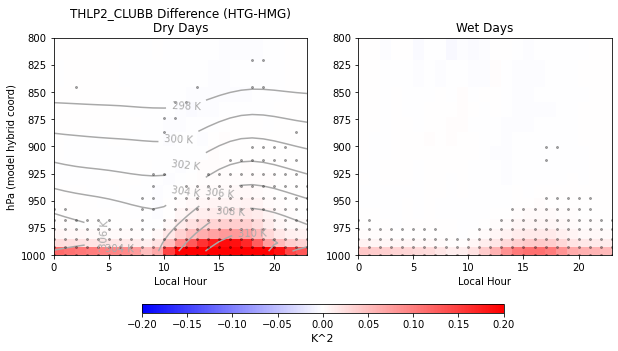

In [172]:
plotTimeHeightDifference_meanDiurnalCycle('THLP2_CLUBB',1000,800,-0.2,0.2)

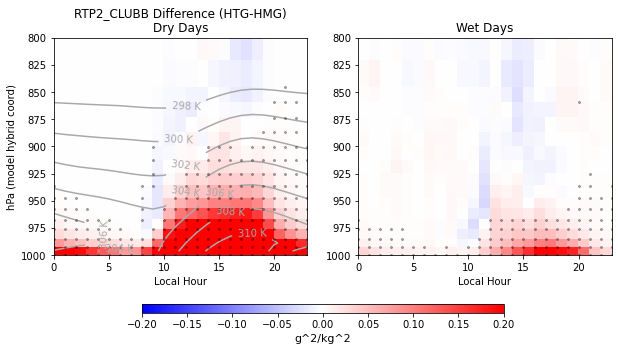

In [173]:
plotTimeHeightDifference_meanDiurnalCycle('RTP2_CLUBB',1000,800,-0.2,0.2)

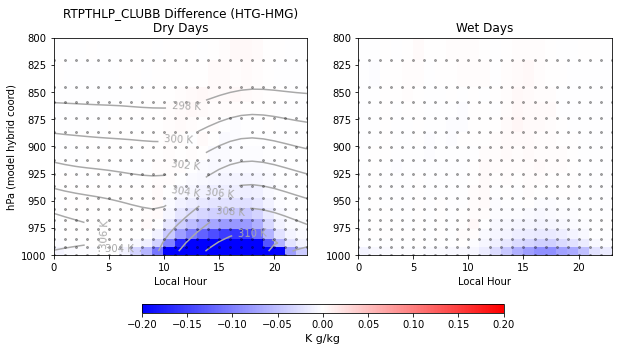

In [174]:
plotTimeHeightDifference_meanDiurnalCycle('RTPTHLP_CLUBB',1000,800,-0.2,0.2)

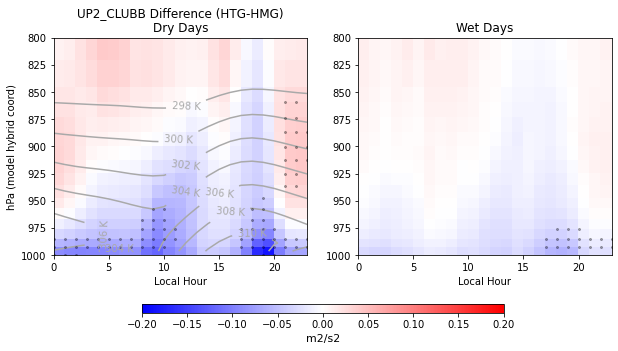

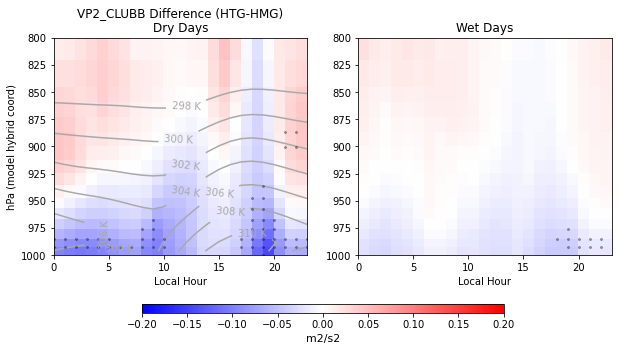

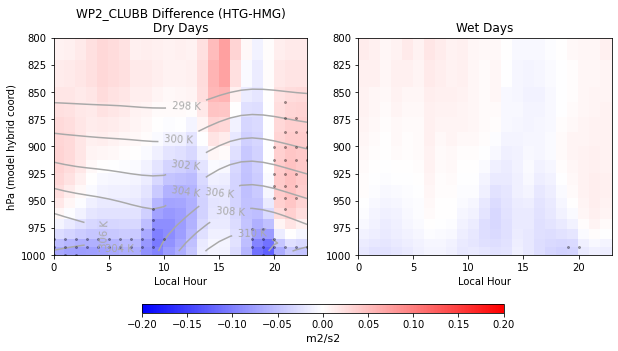

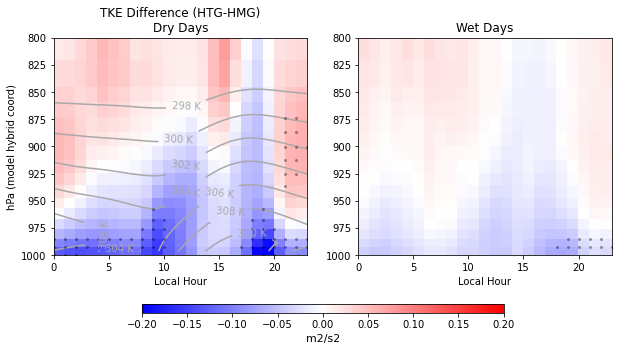

In [175]:
plotTimeHeightDifference_meanDiurnalCycle('UP2_CLUBB',1000,800,-0.2,0.2)
plotTimeHeightDifference_meanDiurnalCycle('VP2_CLUBB',1000,800,-0.2,0.2)
plotTimeHeightDifference_meanDiurnalCycle('WP2_CLUBB',1000,800,-0.2,0.2)
plotTimeHeightDifference_meanDiurnalCycle('TKE',1000,800,-0.2,0.2)


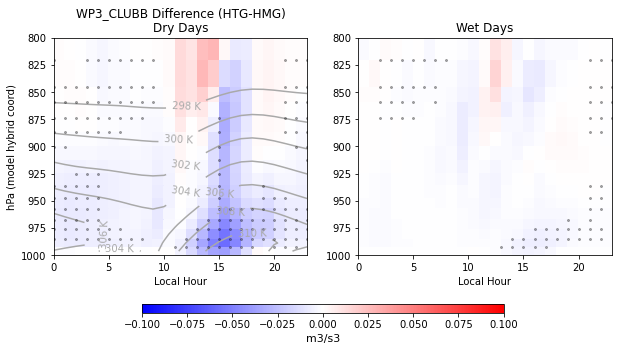

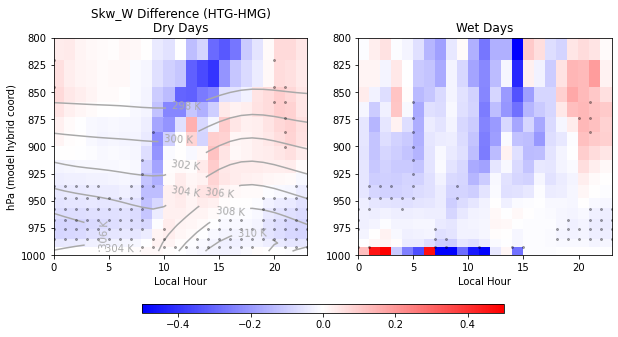

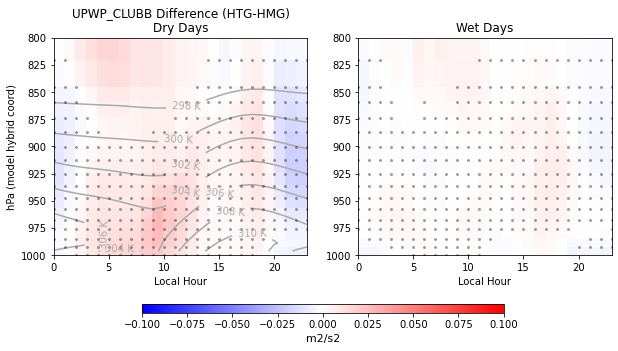

In [176]:
plotTimeHeightDifference_meanDiurnalCycle('WP3_CLUBB',1000,800,-0.1,0.1)
plotTimeHeightDifference_meanDiurnalCycle('Skw_W',1000,800,-0.5,0.5)
plotTimeHeightDifference_meanDiurnalCycle('UPWP_CLUBB',1000,800,-0.1,0.1)

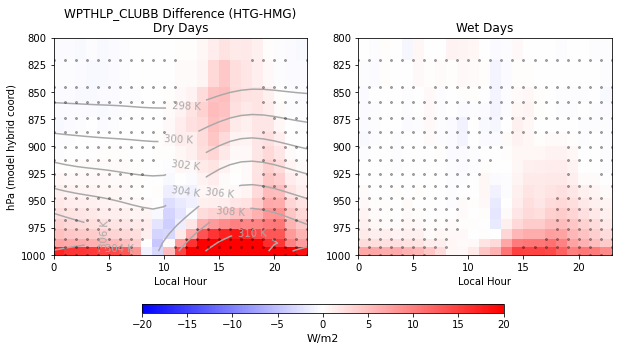

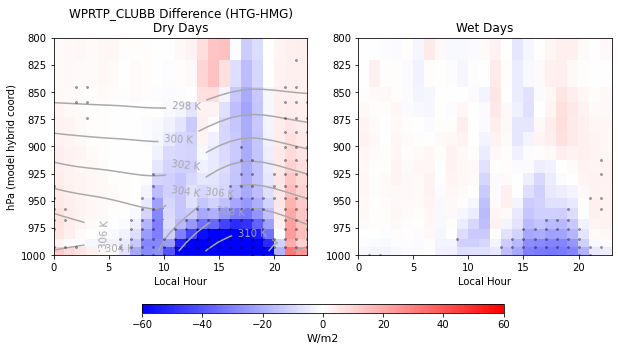

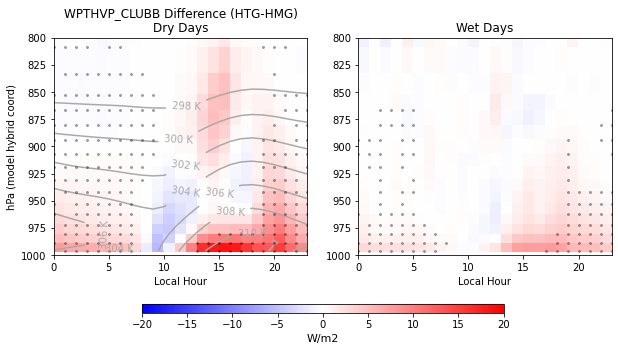

In [177]:
plotTimeHeightDifference_meanDiurnalCycle('WPTHLP_CLUBB',1000,800,-20,20)
plotTimeHeightDifference_meanDiurnalCycle('WPRTP_CLUBB', 1000,800,-60,60)
plotTimeHeightDifference_meanDiurnalCycle('WPTHVP_CLUBB',1000,800,-20,20)

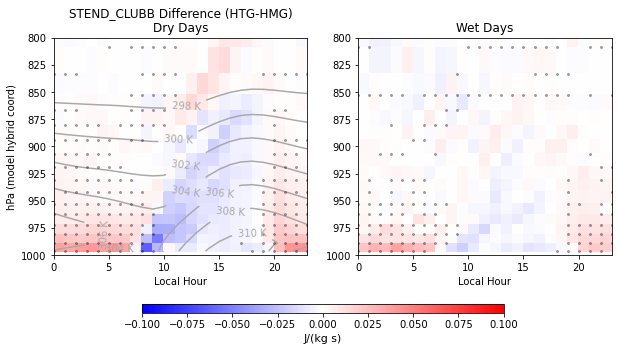

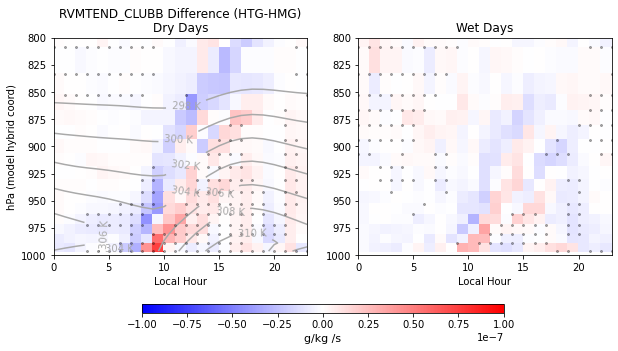

In [178]:
plotTimeHeightDifference_meanDiurnalCycle('STEND_CLUBB',1000,800,-0.1,0.1)
plotTimeHeightDifference_meanDiurnalCycle('RVMTEND_CLUBB',1000,800,-1e-7,1e-7)

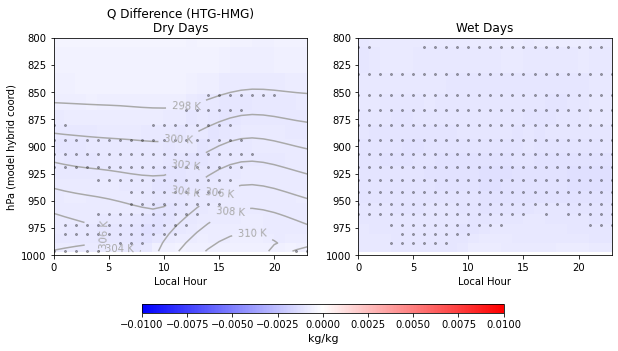

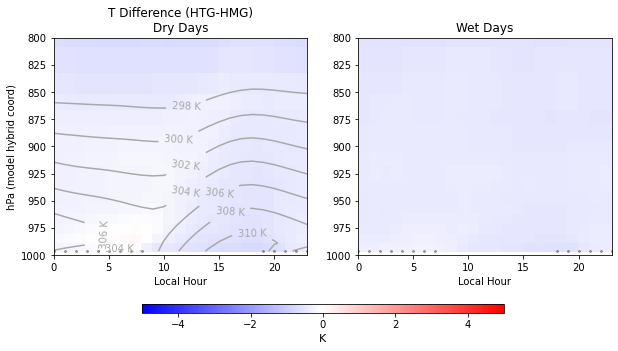

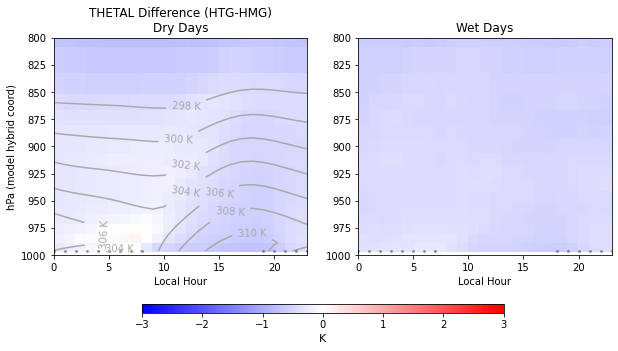

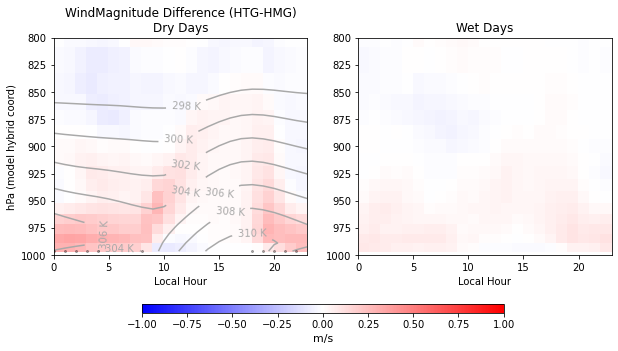

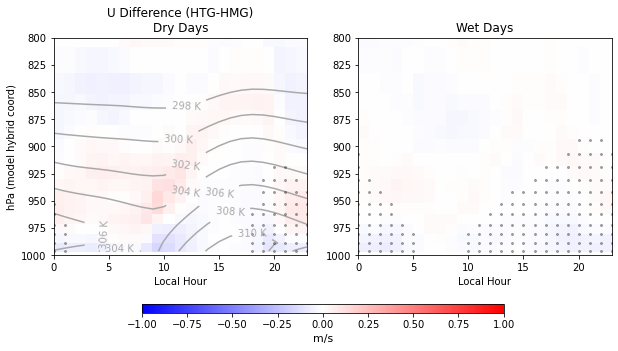

In [179]:
plotTimeHeightDifference_meanDiurnalCycle('Q',1000,800,-0.01,0.01)
plotTimeHeightDifference_meanDiurnalCycle('T',1000,800,-5,5)
plotTimeHeightDifference_meanDiurnalCycle('THETAL',1000,800,-3,3)
plotTimeHeightDifference_meanDiurnalCycle('WindMagnitude',1000,800,-1,1)
plotTimeHeightDifference_meanDiurnalCycle('U',1000,800,-1,1)

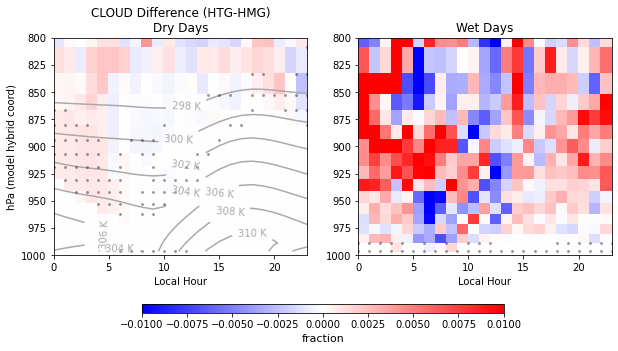

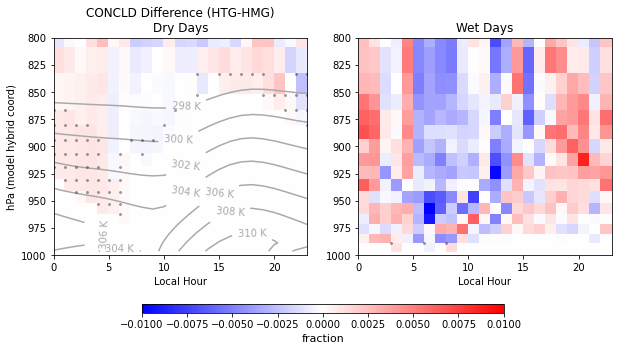

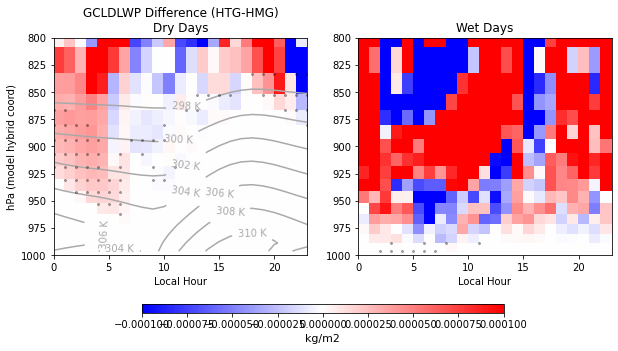

In [180]:
plotTimeHeightDifference_meanDiurnalCycle('CLOUD',1000,800,-0.01,0.01)
plotTimeHeightDifference_meanDiurnalCycle('CONCLD',1000,800,-0.01,0.01)
plotTimeHeightDifference_meanDiurnalCycle('GCLDLWP',1000,800,-1e-4,1e-4)


Q tendency due to moist processes


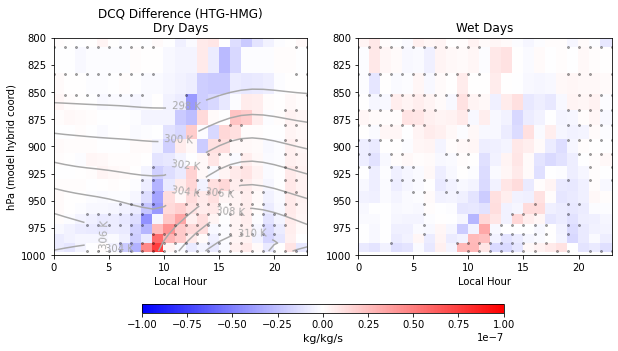

In [181]:
plotTimeHeightDifference_meanDiurnalCycle('DCQ',1000,800,-1e-7,1e-7)
print(HTGcamDS_all['DCQ'].long_name)

Longwave heating rate


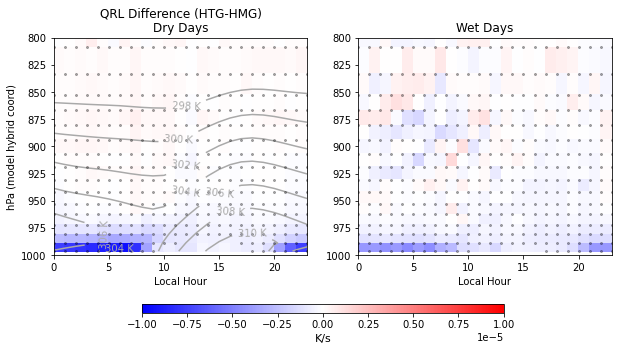

In [182]:
plotTimeHeightDifference_meanDiurnalCycle('QRL',1000,800,-1e-5,1e-5)
print(HTGcamDS_all['QRL'].long_name)

Solar heating rate


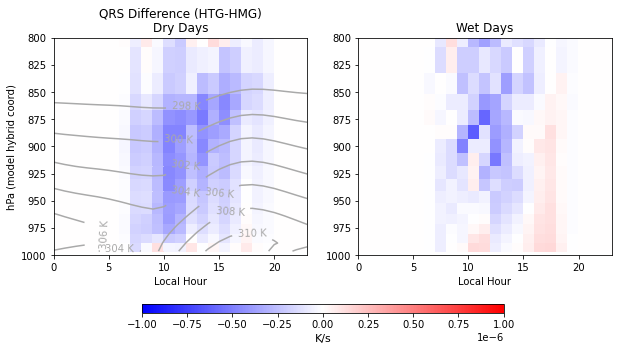

In [183]:
plotTimeHeightDifference_meanDiurnalCycle('QRS',1000,800,-1e-6,1e-6)
print(HTGcamDS_all['QRS'].long_name)

**Now look at vertical profiles, averaged over some selection of hours**

In [66]:
'''
Plot mean vertical profiles over various time means (inclusive)
startHr and endHr are entered as 0-23
'''
def plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, varSel, minLev, maxLev, xMin, xMax):
    
    ## First, get mean over those hours 
    
    # ------- dDry days ----------
    iTimeSel_dDryHMG = np.where((dDryDays_HMG["time.hour"].values>=startHr) & 
                                (dDryDays_HMG["time.hour"].values<=endHr))[0]
    iTimeSel_dDryHTG = np.where((dDryDays_HTG["time.hour"].values>=startHr) & 
                                (dDryDays_HTG["time.hour"].values<=endHr))[0]
    

    hourlyMean_dDryTimeSel_HMG = dDryDays_HMG.isel(time=iTimeSel_dDryHMG).mean(dim='time')
    hourlyMean_dDryTimeSel_HTG = dDryDays_HTG.isel(time=iTimeSel_dDryHTG).mean(dim='time')
    
    hourlyStd_dDryTimeSel_HMG = dDryDays_HMG.isel(time=iTimeSel_dDryHMG).std(dim='time')
    hourlyStd_dDryTimeSel_HTG = dDryDays_HTG.isel(time=iTimeSel_dDryHTG).std(dim='time')
    
    stdErr_dDry_HMG = np.squeeze(hourlyStd_dDryTimeSel_HMG[varSel].values)/np.sqrt(len(iTimeSel_dDryHMG))
    stdErr_dDry_HTG = np.squeeze(hourlyStd_dDryTimeSel_HTG[varSel].values)/np.sqrt(len(iTimeSel_dDryHTG))
    

    # ------- wWet days ----------
    iTimeSel_wWetHMG = np.where((wWetDays_HMG["time.hour"].values>=startHr) & 
                                (wWetDays_HMG["time.hour"].values<=endHr))[0]
    iTimeSel_wWetHTG = np.where((wWetDays_HTG["time.hour"].values>=startHr) & 
                                (wWetDays_HTG["time.hour"].values<=endHr))[0]
    

    hourlyMean_wWetTimeSel_HMG = wWetDays_HMG.isel(time=iTimeSel_wWetHMG).mean(dim='time')
    hourlyMean_wWetTimeSel_HTG = wWetDays_HTG.isel(time=iTimeSel_wWetHTG).mean(dim='time')
    
    hourlyStd_wWetTimeSel_HMG = wWetDays_HMG.isel(time=iTimeSel_wWetHMG).std(dim='time')
    hourlyStd_wWetTimeSel_HTG = wWetDays_HTG.isel(time=iTimeSel_wWetHTG).std(dim='time')
    
    stdErr_wWet_HMG = np.squeeze(hourlyStd_wWetTimeSel_HMG[varSel].values)/np.sqrt(len(iTimeSel_wWetHMG))
    stdErr_wWet_HTG = np.squeeze(hourlyStd_wWetTimeSel_HTG[varSel].values)/np.sqrt(len(iTimeSel_wWetHTG))

    print('Means computed over the inclusive period of %i to %i.' % (startHr, endHr))
    
    
    ## Now we can figure out how to plot! 
    fig,axs = plt.subplots(1,2, figsize=(10,4))
    axs     = axs.ravel()
    
    # Select which levels array to use
    if np.shape(hourlyMean_wWetTimeSel_HMG[varSel].values)[0]==len(hourlyMean_wWetTimeSel_HMG.ilev.values): 
        levSel = 'ilev'
    elif np.shape(hourlyMean_wWetTimeSel_HMG[varSel].values)[0]==len(hourlyMean_wWetTimeSel_HMG.lev.values):
        levSel = 'lev'
        
    if varSel=='WindMagnitude':
        unitLabel  = HTGcamDS_local['U'].units
        titleStr   = varSel
    elif varSel=='theta':
        unitLabel = HTGcamDS_local['T'].units
        titleStr   = varSel
    elif varSel=='Skw_W':
        unitLabel = ' '
        titleStr   = varSel
    elif varSel=='TKE':
        unitLabel = HTGcamDS_local['UP2_CLUBB'].units
        titleStr = varSel
    else: 
        unitLabel  = HTGcamDS_local[varSel].units
        titleStr   = HTGcamDS_local[varSel].long_name
    
    # Plot dDry days 
#     axs[0].errorbar(np.squeeze(hourlyMean_dDryTimeSel_HMG[varSel].values), 
#                     hourlyMean_dDryTimeSel_HMG[levSel].values,
#                     xerr = 2*stdErr_dDry_HMG,
#                     fmt='r-', capsize=3, label='HMG')
#     axs[0].errorbar(np.squeeze(hourlyMean_dDryTimeSel_HTG[varSel].values), 
#                     hourlyMean_dDryTimeSel_HTG[levSel].values,
#                     xerr = 2*stdErr_dDry_HTG,
#                     fmt='b', capsize=3, label='HTG')
    axs[0].plot(np.squeeze(hourlyMean_dDryTimeSel_HMG[varSel].values), 
                    hourlyMean_dDryTimeSel_HMG[levSel].values,
                    'r-',  label='HMG')
    axs[0].plot(np.squeeze(hourlyMean_dDryTimeSel_HTG[varSel].values), 
                    hourlyMean_dDryTimeSel_HTG[levSel].values,
                    'b', label='HTG')
    axs[0].legend()
    axs[0].set_title(titleStr+'\ndDry days ('+str(startHr)+'-'+str(endHr)+' mean)')
    axs[0].set_ylabel('m')
    axs[0].set_xlabel(unitLabel)
    # Signal significance more clearly on plots?
    xmax1 = np.squeeze(hourlyMean_dDryTimeSel_HMG[varSel].values) + (2*stdErr_dDry_HMG)
    xmin1 = np.squeeze(hourlyMean_dDryTimeSel_HMG[varSel].values) - (2*stdErr_dDry_HMG)
    xmax2 = np.squeeze(hourlyMean_dDryTimeSel_HTG[varSel].values) + (2*stdErr_dDry_HTG)
    xmin2 = np.squeeze(hourlyMean_dDryTimeSel_HTG[varSel].values) - (2*stdErr_dDry_HTG)

    levSig = np.ones([len(hourlyMean_dDryTimeSel_HMG[levSel].values)])
    for iLev in range(len(hourlyMean_dDryTimeSel_HMG[levSel].values)):
        if ((abs(xmin1[iLev])>=abs(xmin2[iLev])) & (abs(xmin1[iLev])<=abs(xmax2[iLev]))):
            levSig[iLev] = 0
        elif ((abs(xmin2[iLev])>=abs(xmin1[iLev])) & (abs(xmin2[iLev])<=abs(xmax1[iLev]))):
            levSig[iLev] = 0

        if levSig[iLev]==1:
#             if abs(hourlyMean_dDryTimeSel_HMG[varSel].values[iLev])>=abs(hourlyMean_dDryTimeSel_HTG[varSel].values[iLev]):
            axs[0].plot(hourlyMean_dDryTimeSel_HMG[varSel].values[iLev], 
                        hourlyMean_dDryTimeSel_HMG[levSel].values[iLev], 
                        'ro')
#             else:
            axs[0].plot(hourlyMean_dDryTimeSel_HTG[varSel].values[iLev], 
                    hourlyMean_dDryTimeSel_HTG[levSel].values[iLev], 
                    'bo')
    
            

    # Plot wWet days 
#     axs[3].errorbar(np.squeeze(hourlyMean_wWetTimeSel_HMG[varSel].values), 
#                     hourlyMean_wWetTimeSel_HMG[levSel].values,
#                     xerr = 2*stdErr_wWet_HMG,
#                     fmt='r', capsize=3, label='HMG')
#     axs[3].errorbar(np.squeeze(hourlyMean_wWetTimeSel_HTG[varSel].values), 
#                     hourlyMean_wWetTimeSel_HTG[levSel].values,
#                     xerr = 2*stdErr_wWet_HTG,
#                     fmt='b', capsize=3, label='HTG')
    axs[1].plot(np.squeeze(hourlyMean_wWetTimeSel_HMG[varSel].values), 
                    hourlyMean_wWetTimeSel_HMG[levSel].values,
                    'r', label='HMG')
    axs[1].plot(np.squeeze(hourlyMean_wWetTimeSel_HTG[varSel].values), 
                    hourlyMean_wWetTimeSel_HTG[levSel].values,
                    'b', label='HTG')
#     axs[1].legend()
    axs[1].set_title(varSel+'\nwWet days')
    axs[1].set_xlabel(unitLabel)
    # Signal significance more clearly on plots?
    xmax1 = np.squeeze(hourlyMean_wWetTimeSel_HMG[varSel].values) + (2*stdErr_wWet_HMG)
    xmin1 = np.squeeze(hourlyMean_wWetTimeSel_HMG[varSel].values) - (2*stdErr_wWet_HMG)
    xmax2 = np.squeeze(hourlyMean_wWetTimeSel_HTG[varSel].values) + (2*stdErr_wWet_HTG)
    xmin2 = np.squeeze(hourlyMean_wWetTimeSel_HTG[varSel].values) - (2*stdErr_wWet_HTG)

    levSig = np.ones([len(hourlyMean_wWetTimeSel_HMG[levSel].values)])
    for iLev in range(len(hourlyMean_wWetTimeSel_HMG[levSel].values)):
        if ((abs(xmin1[iLev])>=abs(xmin2[iLev])) & (abs(xmin1[iLev])<=abs(xmax2[iLev]))):
            levSig[iLev] = 0
        elif ((abs(xmin2[iLev])>=abs(xmin1[iLev])) & (abs(xmin2[iLev])<=abs(xmax1[iLev]))):
            levSig[iLev] = 0

        if levSig[iLev]==1:
#             if abs(hourlyMean_wWetTimeSel_HMG[varSel].values[iLev])>=abs(hourlyMean_wWetTimeSel_HTG[varSel].values[iLev]):
            axs[1].plot(hourlyMean_wWetTimeSel_HMG[varSel].values[iLev], 
                        hourlyMean_wWetTimeSel_HMG[levSel].values[iLev], 
                        'ro')
#             else:
            axs[1].plot(hourlyMean_wWetTimeSel_HTG[varSel].values[iLev], 
                        hourlyMean_wWetTimeSel_HTG[levSel].values[iLev], 
                        'bo')

    # Consistent settings across subplots 
    axs[0].set_ylim([minLev,maxLev])
    axs[1].set_ylim([minLev,maxLev])
    
    axs[0].set_xlim([xMin,xMax])
    axs[1].set_xlim([xMin,xMax])
    
    axs[0].invert_yaxis()
    axs[1].invert_yaxis()

    
    return

In [70]:
startHr = 15
endHr   = 18
# startHr = 7
# endHr   = 10
# maxLev  = 2000
# minLev  = 0
maxLev  = 1000
minLev  = 800



Means computed over the inclusive period of 15 to 18.
Means computed over the inclusive period of 15 to 18.
Means computed over the inclusive period of 15 to 18.


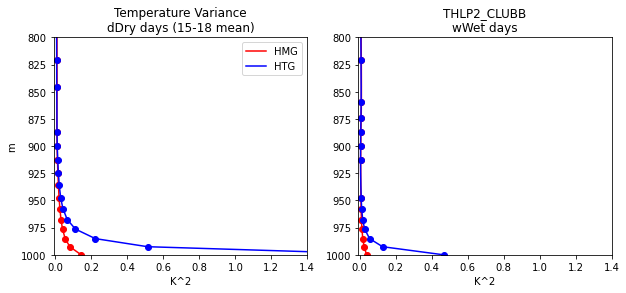

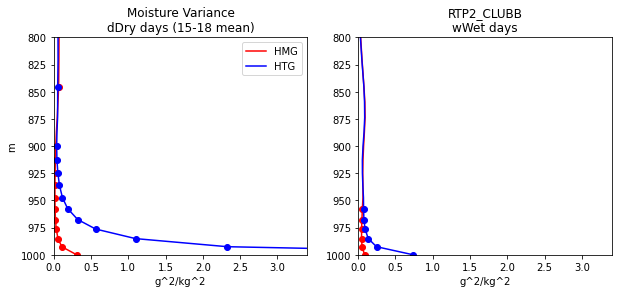

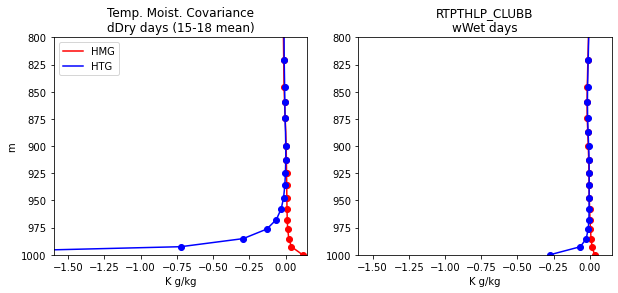

In [71]:
plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'THLP2_CLUBB', minLev, maxLev, 
#                            -0.01, 0.6)  # 8-10a
                             -0.01, 1.4)  # 3-5p

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'RTP2_CLUBB', minLev, maxLev,
#                            0.0, 1.75)
                             0.0, 3.4)

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'RTPTHLP_CLUBB', minLev, maxLev,
#                            -0.75, 0.15)
                             -1.6, 0.15)

Means computed over the inclusive period of 15 to 18.
Means computed over the inclusive period of 15 to 18.
Means computed over the inclusive period of 15 to 18.
Means computed over the inclusive period of 15 to 18.


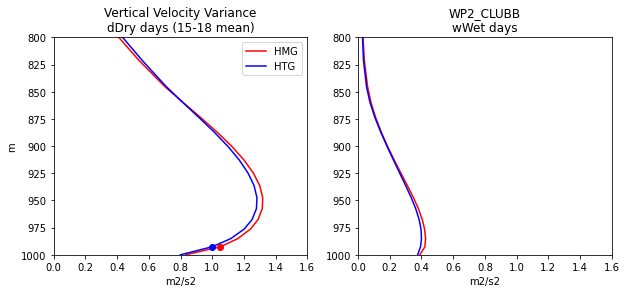

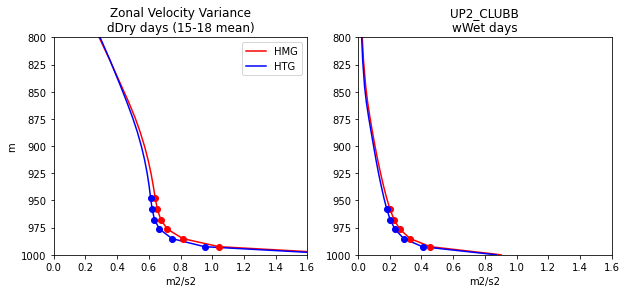

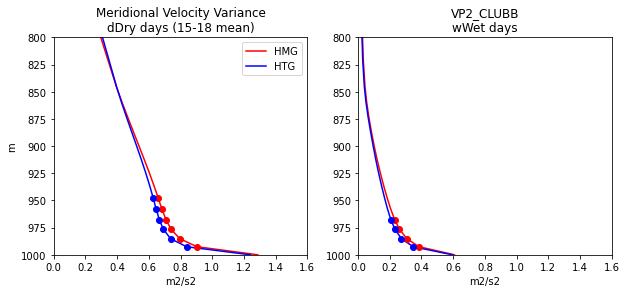

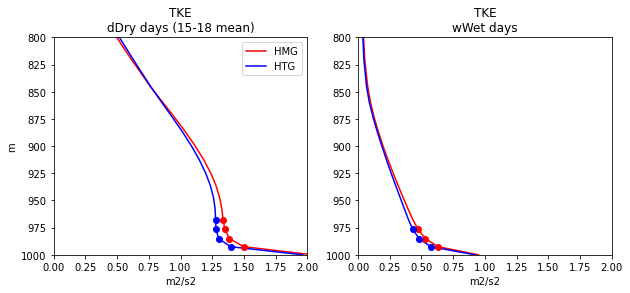

In [72]:
plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'WP2_CLUBB', minLev, maxLev, 
#                            -0.01, 0.6)  # 8-10a
                             0.0, 1.6)  # 3-5p

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'UP2_CLUBB', minLev, maxLev,
#                            0.0, 1.75)
                             0.0, 1.6)

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'VP2_CLUBB', minLev, maxLev,
#                            -0.75, 0.15)
                             0.0, 1.6)

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'TKE', minLev, maxLev,
#                            -0.75, 0.15)
                             0.0, 2.0)


Means computed over the inclusive period of 15 to 18.


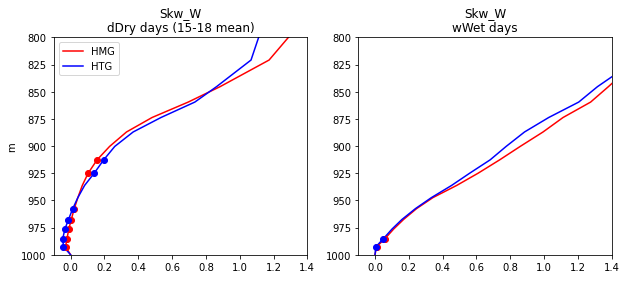

In [73]:

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'Skw_W', minLev, maxLev,
#                            -0.02, 0.1)
                           -0.1, 1.4)



Means computed over the inclusive period of 15 to 18.
Means computed over the inclusive period of 15 to 18.
Means computed over the inclusive period of 15 to 18.
Means computed over the inclusive period of 15 to 18.
Means computed over the inclusive period of 15 to 18.
Means computed over the inclusive period of 15 to 18.


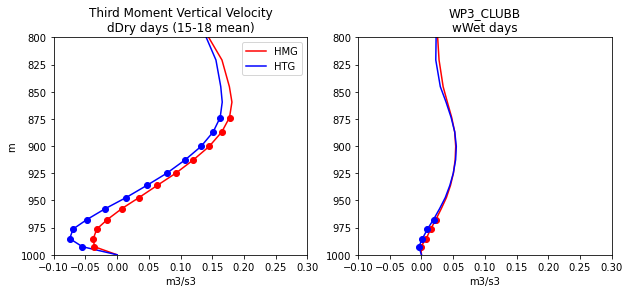

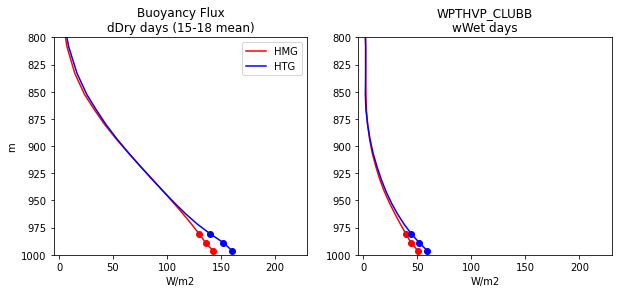

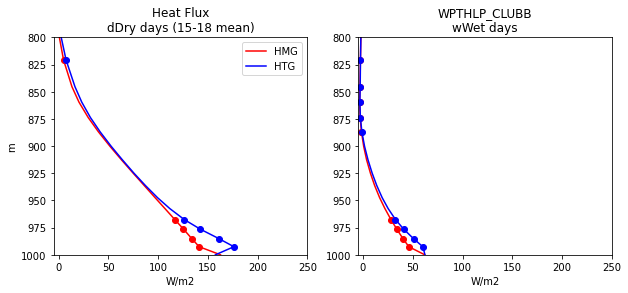

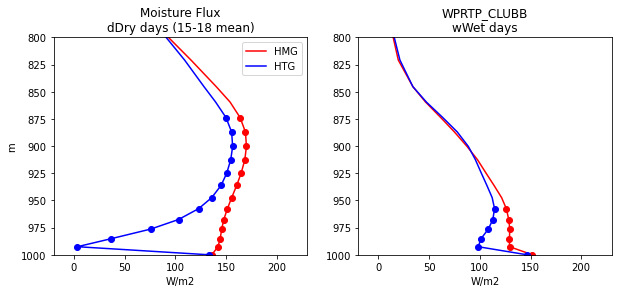

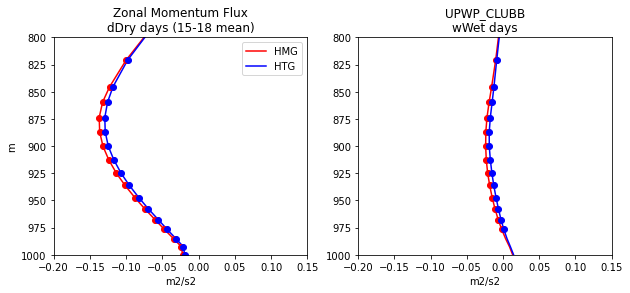

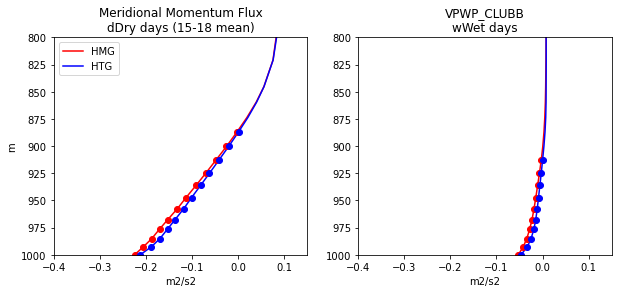

In [74]:
#maxLev=800

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'WP3_CLUBB', minLev, maxLev,
#                            -0.02, 0.1)
                           -0.1, 0.3)


plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'WPTHVP_CLUBB', minLev, maxLev,
#                            -5, 60)
                           -5, 230)

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'WPTHLP_CLUBB', minLev, maxLev,
#                            -5, 80)
                           -5, 250)

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'WPRTP_CLUBB', minLev, maxLev,
#                            -10, 120)
                            -20, 230)       

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'UPWP_CLUBB', minLev, maxLev,
#                            0.0, 2.0)
                             -0.2, 0.15)

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'VPWP_CLUBB', minLev, maxLev,
#                            0.0, 2.0)
                             -0.4, 0.15)


**Digging into some fo the flux differences more**

In [75]:
## Is bottom level actually zero flux?

# ------- dDry days ----------
iTimeSel_dDryHMG = np.where((dDryDays_HMG["time.hour"].values>=startHr) & 
                            (dDryDays_HMG["time.hour"].values<=endHr))[0]
iTimeSel_dDryHTG = np.where((dDryDays_HTG["time.hour"].values>=startHr) & 
                            (dDryDays_HTG["time.hour"].values<=endHr))[0]


hourlyMean_dDryTimeSel_HMG = dDryDays_HMG.isel(time=iTimeSel_dDryHMG).mean(dim='time')
hourlyMean_dDryTimeSel_HTG = dDryDays_HTG.isel(time=iTimeSel_dDryHTG).mean(dim='time')

hourlyStd_dDryTimeSel_HMG = dDryDays_HMG.isel(time=iTimeSel_dDryHMG).std(dim='time')
hourlyStd_dDryTimeSel_HTG = dDryDays_HTG.isel(time=iTimeSel_dDryHTG).std(dim='time')

stdErr_dDry_HMG = np.squeeze(hourlyStd_dDryTimeSel_HMG['WPRTP_CLUBB'].values)/np.sqrt(len(iTimeSel_dDryHMG))
stdErr_dDry_HTG = np.squeeze(hourlyStd_dDryTimeSel_HTG['WPRTP_CLUBB'].values)/np.sqrt(len(iTimeSel_dDryHTG))

# print('Dry day mean WPRTP_CLUBB from hours %i to %i:' % (startHr,endHr))
# print('ilev (hPa)     HMG     HTG')
# print('---------     ----    -----')
# for il in range(len(hourlyStd_dDryTimeSel_HMG['ilev'].values-1)):
#     levInterest = il+1
#     print('%.2f %14.2e %10.2e' % (hourlyStd_dDryTimeSel_HMG['ilev'].values[-levInterest], 
#           np.squeeze(hourlyMean_dDryTimeSel_HMG['WPRTP_CLUBB'].values[-levInterest]),
#           np.squeeze(hourlyMean_dDryTimeSel_HTG['WPRTP_CLUBB'].values[-levInterest])))

Text(0.5, 1.0, 'Timeseries of difference (HTG-HMG) wprtp_clubb at ilev=-1 (dry days only)')

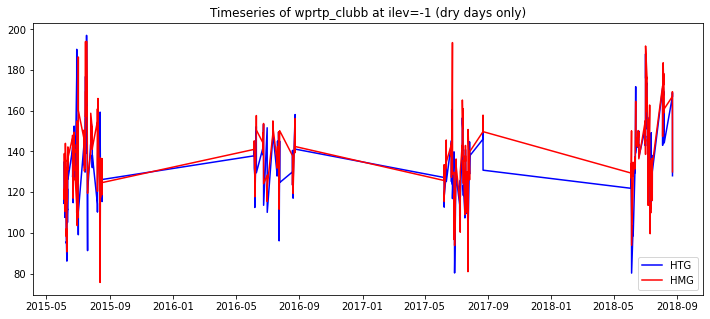

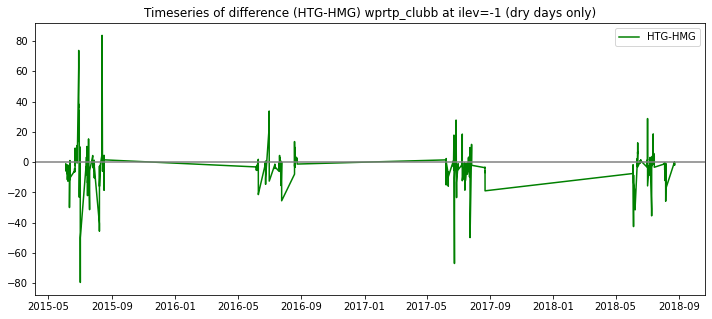

In [76]:
dry_wprtpHTG = dDryDays_HTG.isel(time=iTimeSel_dDryHTG)['WPRTP_CLUBB']
dry_wprtpHMG = dDryDays_HMG.isel(time=iTimeSel_dDryHMG)['WPRTP_CLUBB']

fig,axs = plt.subplots(1,1, figsize=(12,5))
axs.plot(dry_wprtpHTG.time, dry_wprtpHTG.values[:,-1,0,0],'b',label='HTG')
axs.plot(dry_wprtpHTG.time, dry_wprtpHMG.values[:,-1,0,0],'r',label='HMG')
axs.legend()
# axs.axhline(0,color='grey')
axs.set_title('Timeseries of wprtp_clubb at ilev=-1 (dry days only)')

fig,axs = plt.subplots(1,1, figsize=(12,5))
axs.plot(dry_wprtpHTG.time, dry_wprtpHTG.values[:,-1,0,0]-dry_wprtpHMG.values[:,-1,0,0],'g',label='HTG-HMG')
axs.legend()
axs.axhline(0,color='grey')
axs.set_title('Timeseries of difference (HTG-HMG) wprtp_clubb at ilev=-1 (dry days only)')


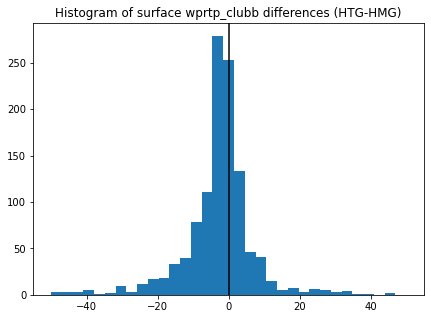

In [77]:
bins = np.linspace(-50,50, np.floor(np.sqrt(len(iTimeSel_dDryHTG))).astype('int'))

fig,axs = plt.subplots(1,1, figsize=(7,5))
axs.hist(dry_wprtpHTG.values[:,-1,0,0]-dry_wprtpHMG.values[:,-1,0,0], bins=bins)
axs.set_title('Histogram of surface wprtp_clubb differences (HTG-HMG)')
axs.axvline(0,color='k')

Text(0.5, 1.0, 'Timeseries of wprtp_clubb at ilev=-2 (dry days only)')

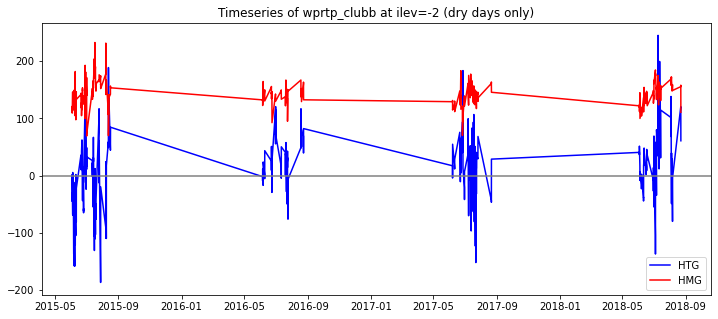

In [78]:
dry_wprtpHTG = dDryDays_HTG.isel(time=iTimeSel_dDryHTG)['WPRTP_CLUBB']
dry_wprtpHMG = dDryDays_HMG.isel(time=iTimeSel_dDryHMG)['WPRTP_CLUBB']

fig,axs = plt.subplots(1,1, figsize=(12,5))
axs.plot(dry_wprtpHTG.time, dry_wprtpHTG.values[:,-2,0,0],'b',label='HTG')
axs.plot(dry_wprtpHTG.time, dry_wprtpHMG.values[:,-2,0,0],'r',label='HMG')
axs.legend()
axs.axhline(0,color='grey')
axs.set_title('Timeseries of wprtp_clubb at ilev=-2 (dry days only)')

Means computed over the inclusive period of 15 to 18.
Means computed over the inclusive period of 15 to 18.
Means computed over the inclusive period of 15 to 18.
Means computed over the inclusive period of 15 to 18.
Means computed over the inclusive period of 15 to 18.
Means computed over the inclusive period of 15 to 18.


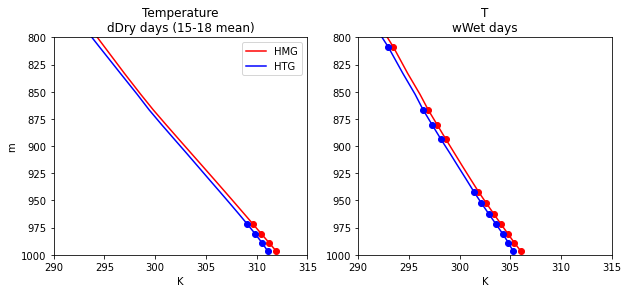

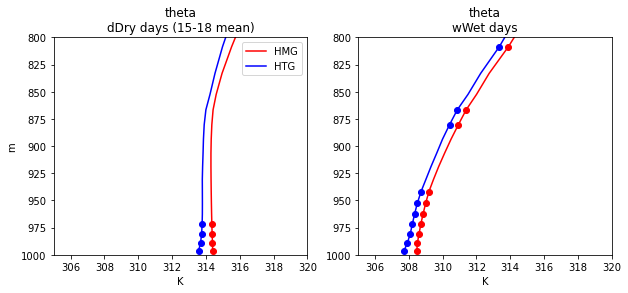

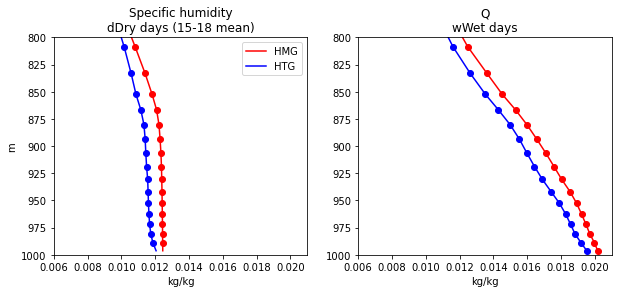

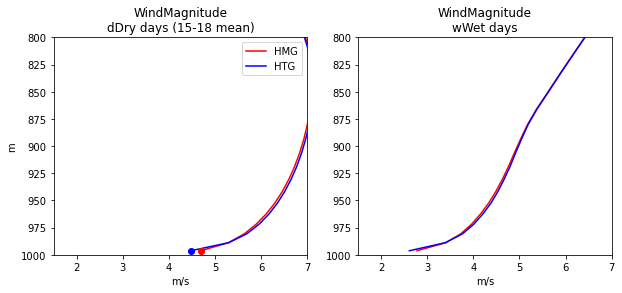

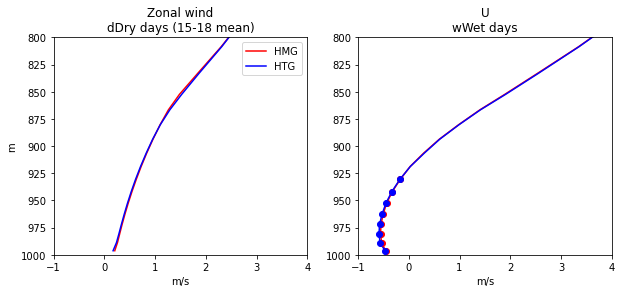

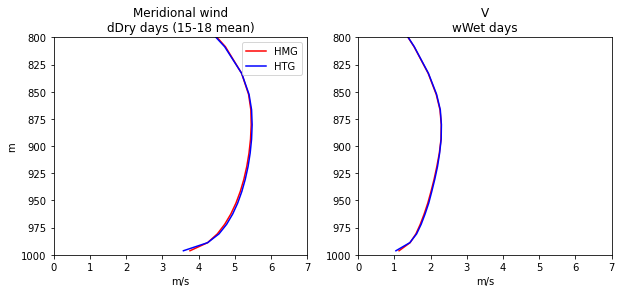

In [79]:

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'T', minLev, maxLev,
#                            280, 310)
                           290, 315)

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'theta', minLev, maxLev,
#                            280, 310)
                           305, 320)

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'Q', minLev, maxLev,
#                            0.006, 0.022)
                           0.006, 0.021)

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'WindMagnitude', minLev, maxLev,
#                            0.006, 0.022)
                           1.5, 7)

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'U', minLev, maxLev,
#                            0.006, 0.022)
                           -1, 4)

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'V', minLev, maxLev,
#                            0.006, 0.022)
                           0, 7)


Means computed over the inclusive period of 15 to 18.
Means computed over the inclusive period of 15 to 18.
Means computed over the inclusive period of 15 to 18.


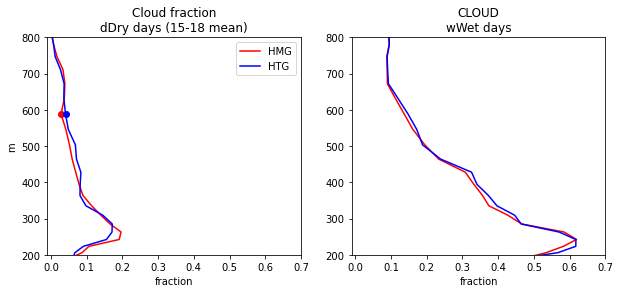

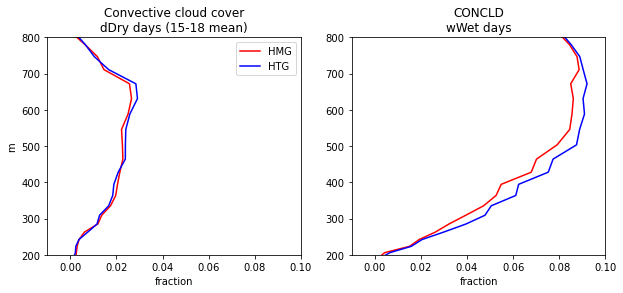

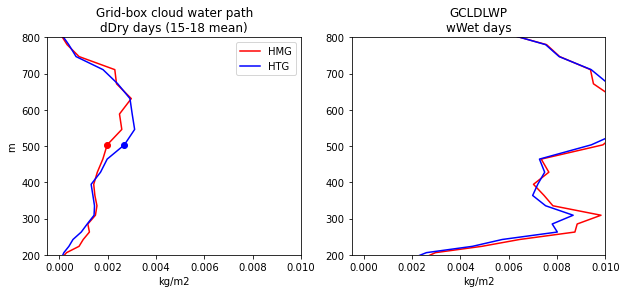

In [80]:
plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'CLOUD', minLev, 200,
#                            -0.01, 0.3)
                           -0.01, 0.7)

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'CONCLD', minLev, 200,
                           -0.01, 0.1)

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'GCLDLWP', minLev, 200,
                           -0.0005, 0.010)


Means computed over the inclusive period of 15 to 18.
Means computed over the inclusive period of 15 to 18.
Means computed over the inclusive period of 15 to 18.


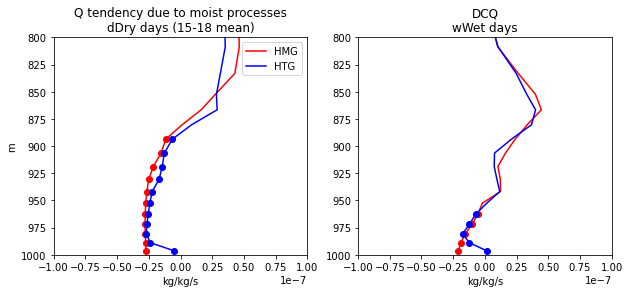

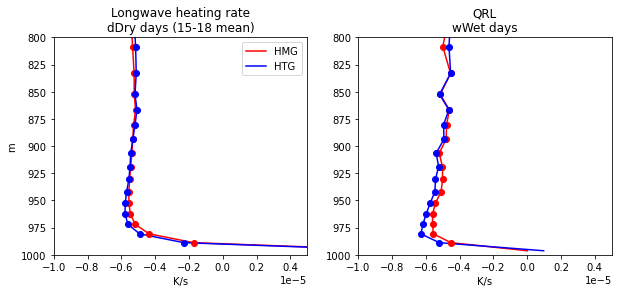

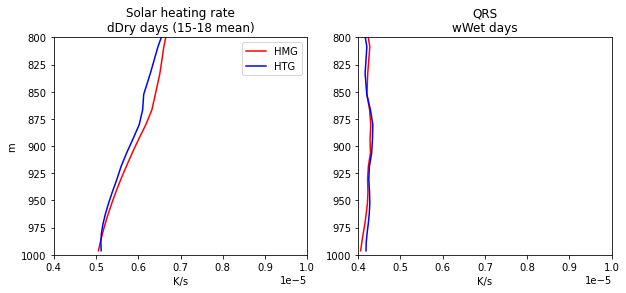

In [81]:
plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'DCQ', minLev, maxLev,
                           -0.1e-6, 0.1e-6) 

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'QRL', minLev, maxLev,
                           -1e-5, 0.5e-5) 

plotProfiles_WithErrBar_timeOfDayMean_manuscriptVersion(startHr, endHr, 'QRS', minLev, maxLev,
                           0.4e-5, 1e-5) 



**Might be easier to isolate cause of dry day PBL depth change if we have all the dry day vertical profiles in just a single figure...**

Taking means over 15-18 h (local time)


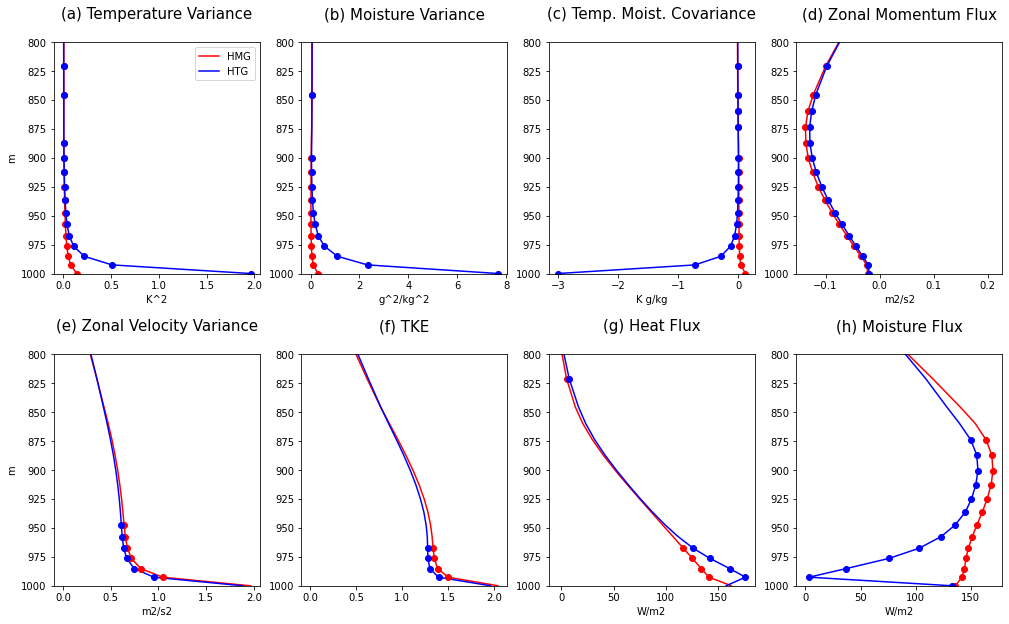

In [84]:
## How about plotting a final manuscript-worth yfigure with dry day info only?

def getMeanProfiles(startHr,endHr,varSel):
    # ------- dDry days ----------
    iTimeSel_dDryHMG = np.where((dDryDays_HMG["time.hour"].values>=startHr) & 
                                (dDryDays_HMG["time.hour"].values<=endHr))[0]
    iTimeSel_dDryHTG = np.where((dDryDays_HTG["time.hour"].values>=startHr) & 
                                (dDryDays_HTG["time.hour"].values<=endHr))[0]
    

    hourlyMean_dDryTimeSel_HMG = dDryDays_HMG.isel(time=iTimeSel_dDryHMG).mean(dim='time')
    hourlyMean_dDryTimeSel_HTG = dDryDays_HTG.isel(time=iTimeSel_dDryHTG).mean(dim='time')
    
    hourlyStd_dDryTimeSel_HMG = dDryDays_HMG.isel(time=iTimeSel_dDryHMG).std(dim='time')
    hourlyStd_dDryTimeSel_HTG = dDryDays_HTG.isel(time=iTimeSel_dDryHTG).std(dim='time')
    
    varProfile_HMG  = np.squeeze(hourlyMean_dDryTimeSel_HMG[varSel].values)
    varProfile_HTG  = np.squeeze(hourlyMean_dDryTimeSel_HTG[varSel].values)
    
    stdErr_dDry_HMG = np.squeeze(hourlyStd_dDryTimeSel_HMG[varSel].values)/np.sqrt(len(iTimeSel_dDryHMG))
    stdErr_dDry_HTG = np.squeeze(hourlyStd_dDryTimeSel_HTG[varSel].values)/np.sqrt(len(iTimeSel_dDryHTG))

    return(varProfile_HMG, varProfile_HTG, stdErr_dDry_HMG,stdErr_dDry_HTG)



#### THIS IS THE SECTION TO EDIT:
## Set variables to plot and hours to average over
varList = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB','UPWP_CLUBB',
                      'UP2_CLUBB','TKE','WPTHLP_CLUBB','WPRTP_CLUBB'])
#                        'WP3_CLUBB','Skw_W','RVMTEND_CLUBB','STEND_CLUBB'])
startHr = 15
endHr   = 18
##### Main section of editing ends here 

print('Taking means over %i-%i h (local time)' % (startHr, endHr))

fig,axs = plt.subplots(2,4, figsize=(17,10))
axs     = axs.ravel() 
fig.subplots_adjust(hspace=0.35)

subpanel_labels = np.asarray(['(a) ','(b) ','(c) ','(d) ','(e) ','(f) ','(g) ','(h) '])

for iPlot in range(len(varList)):
    # Get mean profiles and error estiamtes 
    varProfile_HMG,varProfile_HTG, stdErr_dDry_HMG,stdErr_dDry_HTG = getMeanProfiles(startHr, endHr, varList[iPlot])
    
    # Set title for plots 
    if varList[iPlot]=='Skw_W':
        axs[iPlot].set_title(subpanel_labels[iPlot]+'Vertical Velocity Skew\n', fontsize=15)
        unitLabel = 'm/s'
    elif varList[iPlot]=='TKE':
        axs[iPlot].set_title(subpanel_labels[iPlot]+'TKE\n', fontsize=15)
        unitLabel = ''
    else:
        axs[iPlot].set_title(subpanel_labels[iPlot]+HTGcamDS_local[varList[iPlot]].long_name+'\n', fontsize=15)
        unitLabel = HTGcamDS_local[varList[iPlot]].units
        
    # Set which heights to use (interface vs. midpoint)
    if np.shape(varProfile_HMG)[0]==len(HMGcamDS_local.ilev.values): 
        levSel = 'ilev'
    elif np.shape(varProfile_HMG)[0]==len(HMGcamDS_local.lev.values):
        levSel = 'lev'

    # Now do the actual plotting
    axs[iPlot].plot(varProfile_HMG, 
                    HMGcamDS_local[levSel].values,
                    'r-',  label='HMG')
    axs[iPlot].plot(varProfile_HTG, 
                    HMGcamDS_local[levSel].values,
                    'b', label='HTG')
    axs[iPlot].set_xlabel(unitLabel)
    
    # Control labels more
    if iPlot==0:
        axs[iPlot].legend()
        axs[iPlot].set_ylabel('m')
    elif iPlot==4:
        axs[iPlot].set_ylabel('m')

    
    # Signal significance more clearly on plots
    xmax1 = np.squeeze(varProfile_HMG) + (2*stdErr_dDry_HMG)
    xmin1 = np.squeeze(varProfile_HMG) - (2*stdErr_dDry_HMG)
    xmax2 = np.squeeze(varProfile_HTG) + (2*stdErr_dDry_HTG)
    xmin2 = np.squeeze(varProfile_HTG) - (2*stdErr_dDry_HTG)

    levSig = np.ones([len(varProfile_HMG)])
    for iLev in range(len(varProfile_HMG)):
        if ((abs(xmin1[iLev])>=abs(xmin2[iLev])) & (abs(xmin1[iLev])<=abs(xmax2[iLev]))):
            levSig[iLev] = 0
        elif ((abs(xmin2[iLev])>=abs(xmin1[iLev])) & (abs(xmin2[iLev])<=abs(xmax1[iLev]))):
            levSig[iLev] = 0

        if levSig[iLev]==1:
            axs[iPlot].plot(varProfile_HMG[iLev], 
                        HMGcamDS_local[levSel].values[iLev], 
                        'ro')
            axs[iPlot].plot(varProfile_HTG[iLev], 
                        HMGcamDS_local[levSel].values[iLev], 
                    'bo')
                
    axs[iPlot].set_ylim([800,1000])
    axs[iPlot].invert_yaxis()
    
# Remove last plot panel
# fig.delaxes(axs[7])





Taking means over 15-18 h (local time)


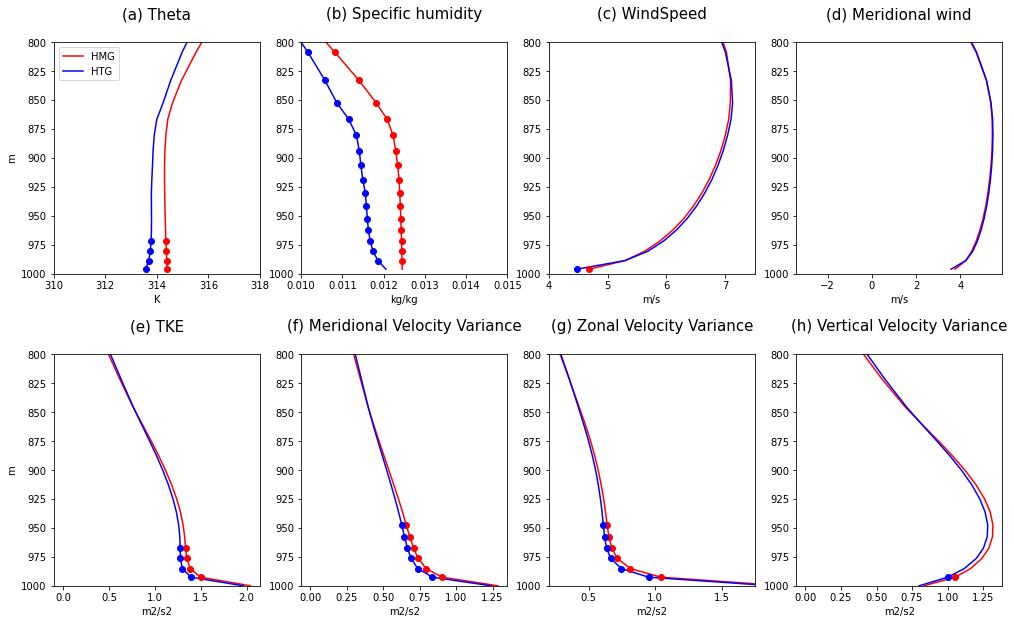

In [85]:
#### THIS IS THE SECTION TO EDIT:
## Set variables to plot and hours to average over
# varList = np.asarray(['T','Q','WindMagnitude','U','VP2_CLUBB','UP2_CLUBB','WP2_CLUBB','TKE'])
varList = np.asarray(['theta','Q','WindMagnitude','V','TKE','VP2_CLUBB','UP2_CLUBB','WP2_CLUBB'])
startHr = 15
endHr   = 18
#### Main section to edit ends here 
print('Taking means over %i-%i h (local time)' % (startHr, endHr))

fig,axs = plt.subplots(2,4, figsize=(17,10))
axs     = axs.ravel() 
fig.subplots_adjust(hspace=0.35)

subpanel_labels = np.asarray(['(a) ','(b) ','(c) ','(d) ','(e) ','(f) ','(g) ','(h) '])

for iPlot in range(len(varList)):
    # Get mean profiles and error estiamtes 
    varProfile_HMG,varProfile_HTG, stdErr_dDry_HMG,stdErr_dDry_HTG = getMeanProfiles(startHr, endHr, varList[iPlot])
    
    # Set title for plots and x-axis units. 
    #   Important for variables 
    if varList[iPlot]=='WindMagnitude':
        axs[iPlot].set_title(subpanel_labels[iPlot]+'WindSpeed\n', fontsize=15)
        unitLabel = 'm/s'
    elif varList[iPlot]=='TKE':
        axs[iPlot].set_title(subpanel_labels[iPlot]+'TKE\n', fontsize=15)
        unitLabel = 'm2/s2'
    elif varList[iPlot]=='theta':
        axs[iPlot].set_title(subpanel_labels[iPlot]+'Theta\n', fontsize=15)
        unitLabel = 'K'
    else:
        axs[iPlot].set_title(subpanel_labels[iPlot]+HTGcamDS_local[varList[iPlot]].long_name+'\n', fontsize=15)
        unitLabel = HTGcamDS_local[varList[iPlot]].units
        
    # Set which heights to use (interface vs. midpoint)
    if np.shape(varProfile_HMG)[0]==len(HMGcamDS_local.ilev.values): 
        levSel = 'ilev'
    elif np.shape(varProfile_HMG)[0]==len(HMGcamDS_local.lev.values):
        levSel = 'lev'

    # Now do the actual plotting
    axs[iPlot].plot(varProfile_HMG, 
                    HMGcamDS_local[levSel].values,
                    'r-',  label='HMG')
    axs[iPlot].plot(varProfile_HTG, 
                    HMGcamDS_local[levSel].values,
                    'b', label='HTG')
    axs[iPlot].set_xlabel(unitLabel)
    
    # Control plot labels 
    if iPlot==0:
        axs[iPlot].legend()
        axs[iPlot].set_ylabel('m')
    elif iPlot==4:
        axs[iPlot].set_ylabel('m')

    
    # Signal significance more clearly on plots
    #   Plot a line marker (circle) if diff is significant at that level
    xmax1 = np.squeeze(varProfile_HMG) + (2*stdErr_dDry_HMG)
    xmin1 = np.squeeze(varProfile_HMG) - (2*stdErr_dDry_HMG)
    xmax2 = np.squeeze(varProfile_HTG) + (2*stdErr_dDry_HTG)
    xmin2 = np.squeeze(varProfile_HTG) - (2*stdErr_dDry_HTG)

    levSig = np.ones([len(varProfile_HMG)])
    for iLev in range(len(varProfile_HMG)):
        if ((abs(xmin1[iLev])>=abs(xmin2[iLev])) & (abs(xmin1[iLev])<=abs(xmax2[iLev]))):
            levSig[iLev] = 0
        elif ((abs(xmin2[iLev])>=abs(xmin1[iLev])) & (abs(xmin2[iLev])<=abs(xmax1[iLev]))):
            levSig[iLev] = 0

        if levSig[iLev]==1:
            axs[iPlot].plot(varProfile_HMG[iLev], 
                        HMGcamDS_local[levSel].values[iLev], 
                        'ro')
            axs[iPlot].plot(varProfile_HTG[iLev], 
                        HMGcamDS_local[levSel].values[iLev], 
                    'bo')
                
    # Set y-axis limit (how high above the surface to plot)
    axs[iPlot].set_ylim([800,1000])
    axs[iPlot].invert_yaxis()
    
    # Set some xaxis limits depending on variable chosen
    if varList[iPlot]=='T':
        axs[iPlot].set_xlim([290,315])
    elif varList[iPlot]=='Q':
        axs[iPlot].set_xlim([0.01, 0.015])
    elif varList[iPlot]=='WindMagnitude':
        axs[iPlot].set_xlim([4,7.5])
    elif varList[iPlot]=='theta':
        axs[iPlot].set_xlim([310,318])
    elif varList[iPlot]=='UP2_CLUBB':
        axs[iPlot].set_xlim([0.2,1.75])

    # Add gridlines 
    #axs[iPlot].grid()


Out of curiousity - what happens in the morning?

Taking means over 7-10 h (local time)


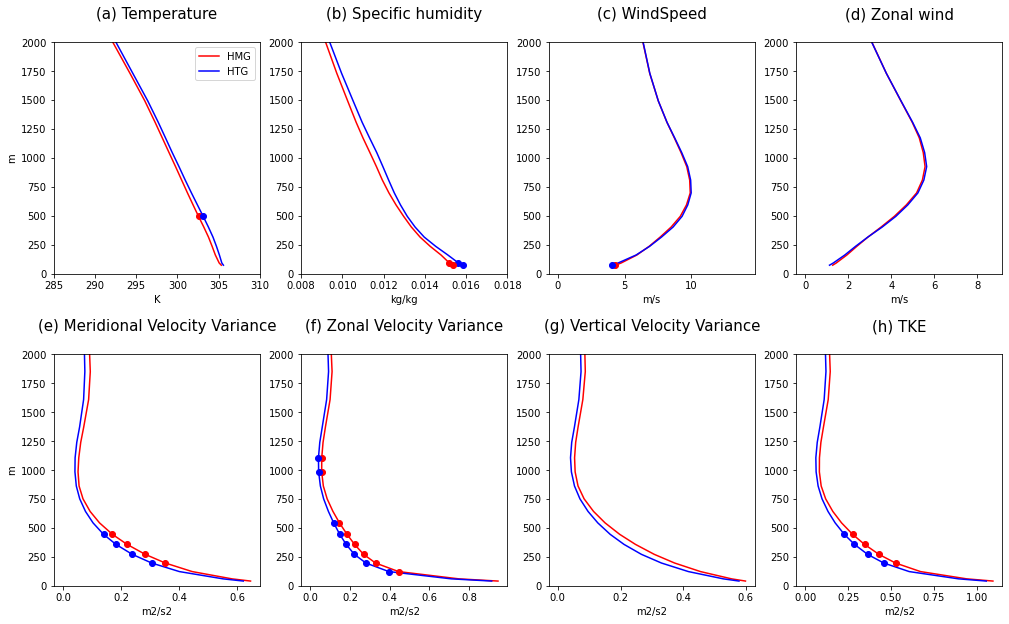

In [56]:
 ## How about plotting a final manuscript-worth yfigure with dry day info only?

def getMeanProfiles(startHr,endHr,varSel):
    # ------- dDry days ----------
    iTimeSel_dDryHMG = np.where((dDryDays_HMG["time.hour"].values>=startHr) & 
                                (dDryDays_HMG["time.hour"].values<=endHr))[0]
    iTimeSel_dDryHTG = np.where((dDryDays_HTG["time.hour"].values>=startHr) & 
                                (dDryDays_HTG["time.hour"].values<=endHr))[0]
    

    hourlyMean_dDryTimeSel_HMG = dDryDays_HMG.isel(time=iTimeSel_dDryHMG).mean(dim='time')
    hourlyMean_dDryTimeSel_HTG = dDryDays_HTG.isel(time=iTimeSel_dDryHTG).mean(dim='time')
    
    hourlyStd_dDryTimeSel_HMG = dDryDays_HMG.isel(time=iTimeSel_dDryHMG).std(dim='time')
    hourlyStd_dDryTimeSel_HTG = dDryDays_HTG.isel(time=iTimeSel_dDryHTG).std(dim='time')
    
    varProfile_HMG  = np.squeeze(hourlyMean_dDryTimeSel_HMG[varSel].values)
    varProfile_HTG  = np.squeeze(hourlyMean_dDryTimeSel_HTG[varSel].values)
    
    stdErr_dDry_HMG = np.squeeze(hourlyStd_dDryTimeSel_HMG[varSel].values)/np.sqrt(len(iTimeSel_dDryHMG))
    stdErr_dDry_HTG = np.squeeze(hourlyStd_dDryTimeSel_HTG[varSel].values)/np.sqrt(len(iTimeSel_dDryHTG))

    return(varProfile_HMG, varProfile_HTG, stdErr_dDry_HMG,stdErr_dDry_HTG)


varList = np.asarray(['T','Q','WindMagnitude','U','VP2_CLUBB','UP2_CLUBB','WP2_CLUBB','TKE'])
startHr = 7
endHr   = 10
print('Taking means over %i-%i h (local time)' % (startHr, endHr))

fig,axs = plt.subplots(2,4, figsize=(17,10))
axs     = axs.ravel() 
fig.subplots_adjust(hspace=0.35)

subpanel_labels = np.asarray(['(a) ','(b) ','(c) ','(d) ','(e) ','(f) ','(g) ','(h) '])

for iPlot in range(len(varList)):
    # Get mean profiles and error estiamtes 
    varProfile_HMG,varProfile_HTG, stdErr_dDry_HMG,stdErr_dDry_HTG = getMeanProfiles(startHr, endHr, varList[iPlot])
    
    # Set title for plots 
    if varList[iPlot]=='WindMagnitude':
        axs[iPlot].set_title(subpanel_labels[iPlot]+'WindSpeed\n', fontsize=15)
        unitLabel = 'm/s'
    elif varList[iPlot]=='TKE':
        axs[iPlot].set_title(subpanel_labels[iPlot]+'TKE\n', fontsize=15)
        unitLabel = 'm2/s2'
    else:
        axs[iPlot].set_title(subpanel_labels[iPlot]+HTGcamDS_local[varList[iPlot]].long_name+'\n', fontsize=15)
        unitLabel = HTGcamDS_local[varList[iPlot]].units
        
    # Set which heights to use (interface vs. midpoint)
    if np.shape(varProfile_HMG)[0]==len(HMGcamDS_local.ilev.values): 
        levSel = 'ilev'
    elif np.shape(varProfile_HMG)[0]==len(HMGcamDS_local.lev.values):
        levSel = 'lev'

    # Now do the actual plotting
    axs[iPlot].plot(varProfile_HMG, 
                    HMGcamDS_local[levSel].values,
                    'r-',  label='HMG')
    axs[iPlot].plot(varProfile_HTG, 
                    HMGcamDS_local[levSel].values,
                    'b', label='HTG')
    axs[iPlot].set_xlabel(unitLabel)
    
    # Control labels more
    if iPlot==0:
        axs[iPlot].legend()
        axs[iPlot].set_ylabel('m')
    elif iPlot==4:
        axs[iPlot].set_ylabel('m')

    
    # Signal significance more clearly on plots
    xmax1 = np.squeeze(varProfile_HMG) + (2*stdErr_dDry_HMG)
    xmin1 = np.squeeze(varProfile_HMG) - (2*stdErr_dDry_HMG)
    xmax2 = np.squeeze(varProfile_HTG) + (2*stdErr_dDry_HTG)
    xmin2 = np.squeeze(varProfile_HTG) - (2*stdErr_dDry_HTG)

    levSig = np.ones([len(varProfile_HMG)])
    for iLev in range(len(varProfile_HMG)):
        if ((abs(xmin1[iLev])>=abs(xmin2[iLev])) & (abs(xmin1[iLev])<=abs(xmax2[iLev]))):
            levSig[iLev] = 0
        elif ((abs(xmin2[iLev])>=abs(xmin1[iLev])) & (abs(xmin2[iLev])<=abs(xmax1[iLev]))):
            levSig[iLev] = 0

        if levSig[iLev]==1:
            axs[iPlot].plot(varProfile_HMG[iLev], 
                        HMGcamDS_local[levSel].values[iLev], 
                        'ro')
            axs[iPlot].plot(varProfile_HTG[iLev], 
                        HMGcamDS_local[levSel].values[iLev], 
                    'bo')
                
    axs[iPlot].set_ylim([0,2000])

    if varList[iPlot]=='T':
        axs[iPlot].set_xlim([285,310])
    elif varList[iPlot]=='Q':
        axs[iPlot].set_xlim([0.008, 0.018])


## Test out different lengths of wet/dry periods required to precede a 'dry' or 'wet' day

In [28]:
# Define cutoff for classifying a "dry day" [mm/day] 
prectCutoff = 1

print('Number of total days in record:   %i' % (len(HMGcamDS_localDailySum.year_month_day.values)) )


iSelDryDays = np.where((HMGcamDS_localDailySum.PRECT_mmPerDT.values<prectCutoff)&
                       (HTGcamDS_localDailySum.PRECT_mmPerDT.values<prectCutoff))[0]
iSelWetDays = np.where((HMGcamDS_localDailySum.PRECT_mmPerDT.values>=prectCutoff) &
                       (HTGcamDS_localDailySum.PRECT_mmPerDT.values>=prectCutoff))[0]

print('Number of dry days (< %.3f):     %i' % (prectCutoff, len(iSelDryDays)))
print('Number of wet days (>= %.3f):    %i' % (prectCutoff, len(iSelWetDays)))


dayClass = np.full([len(HMGcamDS_localDailySum.year_month_day.values)], 'Mismatch')
dayClass[iSelDryDays] = 'Dry'
dayClass[iSelWetDays] = 'Wet'



Number of total days in record:   352
Number of dry days (< 1.000):     161
Number of wet days (>= 1.000):    167


In [173]:
# Number of days before current one that have to match wet/dry classification to count 
numPrevDays = 5

# Get index of that current day 
idryDates = []
iwetDates = []

for iDay in range(len(dayClass)-numPrevDays):
    i_cDay = iDay+numPrevDays
    
    currentDayClass = dayClass[i_cDay]
    prevDays        = dayClass[i_cDay-numPrevDays:i_cDay]
    
    if len(np.unique(prevDays))==1:
        if (np.unique(prevDays)==currentDayClass) & (currentDayClass=='Wet'):
            iwetDates = np.append(iwetDates, i_cDay)
        elif (np.unique(prevDays)==currentDayClass) & (currentDayClass=='Dry'):
            idryDates = np.append(idryDates, i_cDay)
    

In [174]:
HMG_dryPeriods    = HMGcamDS_localDailySum.isel(year_month_day = idryDates.astype(int))
HTG_dryPeriods    = HTGcamDS_localDailySum.isel(year_month_day = idryDates.astype(int))

HMG_wetPeriods    = HMGcamDS_localDailySum.isel(year_month_day = iwetDates.astype(int))
HTG_wetPeriods    = HTGcamDS_localDailySum.isel(year_month_day = iwetDates.astype(int))

print('# of dry days (based on requirement of %i previous dry days): %i' % (numPrevDays, len(idryDates)))
print('# of wet days (based on requirement of %i previous wet days): %i' % (numPrevDays, len(iwetDates)))


# of dry days (based on requirement of 5 previous dry days): 22
# of wet days (based on requirement of 5 previous wet days): 11


Text(0.5, 1.0, 'Dry days by month')

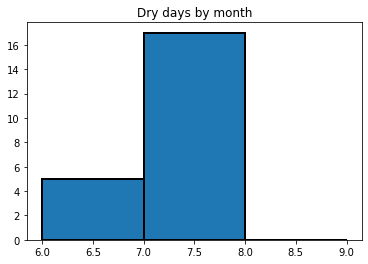

In [175]:
## Seasonality? 
plt.hist(HMG_dryPeriods.year_month_day_level_1.values, bins=[6,7,8,9], edgecolor='k', linewidth=2)
plt.title('Dry days by month')

Text(0.5, 1.0, 'Wet days by month')

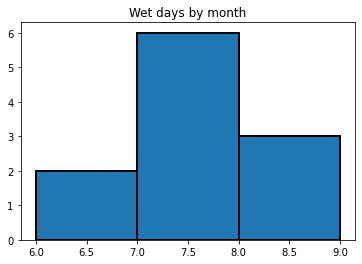

In [176]:
plt.hist(HMG_wetPeriods.year_month_day_level_1.values, bins=[6,7,8,9], edgecolor='k', linewidth=2)
plt.title('Wet days by month')

In [177]:
# Next, get all the times in the full array that line up with each of those classifications above 

## CAM
dryDays_HTG = getTimes_basedOnDayClass(HTGcamDS_local, HTG_dryPeriods)
wetDays_HTG = getTimes_basedOnDayClass(HTGcamDS_local, HTG_wetPeriods)

dryDays_HMG = getTimes_basedOnDayClass(HMGcamDS_local, HMG_dryPeriods)
wetDays_HMG = getTimes_basedOnDayClass(HMGcamDS_local, HMG_wetPeriods)

## CLM 
dryDaysCLM_HTG = getTimes_basedOnDayClass(HTGclmDS_local, HTG_dryPeriods)
wetDaysCLM_HTG = getTimes_basedOnDayClass(HTGclmDS_local, HTG_wetPeriods)

dryDaysCLM_HMG = getTimes_basedOnDayClass(HMGclmDS_local, HMG_dryPeriods)
wetDaysCLM_HMG = getTimes_basedOnDayClass(HMGclmDS_local, HMG_wetPeriods)

## Patch 
dryDaysPatch_HTG = getTimes_basedOnDayClass(HTGclmDS_patch_local, HTG_dryPeriods)
wetDaysPatch_HTG = getTimes_basedOnDayClass(HTGclmDS_patch_local, HTG_wetPeriods)

dryDaysPatch_HMG = getTimes_basedOnDayClass(HMGclmDS_patch_local, HMG_dryPeriods)
wetDaysPatch_HMG = getTimes_basedOnDayClass(HMGclmDS_patch_local, HMG_wetPeriods)



In [178]:
## Add wind speed to underlying DS

windSpeed_dryDays_HMG = np.sqrt((dryDays_HMG.U.values**2.0) + (dryDays_HMG.V.values**2.0))
windSpeed_dryDays_HTG = np.sqrt((dryDays_HTG.U.values**2.0) + (dryDays_HTG.V.values**2.0))

windSpeed_wetDays_HMG = np.sqrt((wetDays_HMG.U.values**2.0) + (wetDays_HMG.V.values**2.0))
windSpeed_wetDays_HTG = np.sqrt((wetDays_HTG.U.values**2.0) + (wetDays_HTG.V.values**2.0))


dryDays_HMG['WindMagnitude'] = (('time','lev'), np.squeeze(windSpeed_dryDays_HMG))
dryDays_HTG['WindMagnitude'] = (('time','lev'), np.squeeze(windSpeed_dryDays_HTG))

wetDays_HMG['WindMagnitude'] = (('time','lev'), np.squeeze(windSpeed_wetDays_HMG))
wetDays_HTG['WindMagnitude'] = (('time','lev'), np.squeeze(windSpeed_wetDays_HTG))



In [179]:
## Now get daily means/std 

# Get means a function of hour of day
hourlyMean_dryDays_HMG = dryDays_HMG.groupby("time.hour").mean()
hourlyMean_dryDays_HTG = dryDays_HTG.groupby("time.hour").mean()

hourlyMean_wetDays_HMG = wetDays_HMG.groupby("time.hour").mean()
hourlyMean_wetDays_HTG = wetDays_HTG.groupby("time.hour").mean()


# Get std as function of hour of day
hourlyStd_dryDays_HMG = dryDays_HMG.groupby("time.hour").std(dim='time')
hourlyStd_dryDays_HTG = dryDays_HTG.groupby("time.hour").std(dim='time')

hourlyStd_wetDays_HMG = wetDays_HMG.groupby("time.hour").std(dim='time')
hourlyStd_wetDays_HTG = wetDays_HTG.groupby("time.hour").std(dim='time')


# Get number of obs going into those hourly means (for error bars)
nTimes_dry = np.full([24], np.nan)
nTimes_wet = np.full([24], np.nan)

for iHr in range(24): 
    nTimes_dry[iHr] = len(np.where(dryDays_HMG["time.hour"]==iHr)[0])
    nTimes_wet[iHr] = len(np.where(wetDays_HMG["time.hour"]==iHr)[0])
    
hourlyMean_dryDays_HMG['SampleCount']         = (('hour'), nTimes_dry)
hourlyMean_dryDays_HTG['SampleCount']         = (('hour'), nTimes_dry)

hourlyMean_wetDays_HMG['SampleCount']         = (('hour'), nTimes_wet)
hourlyMean_wetDays_HTG['SampleCount']         = (('hour'), nTimes_wet)


In [180]:
# Get means a function of hour of day for CLM vars 
hourlyMeanCLM_dryDays_HMG = dryDaysCLM_HMG.groupby("time.hour").mean()
hourlyMeanCLM_dryDays_HTG = dryDaysCLM_HTG.groupby("time.hour").mean()

hourlyMeanCLM_wetDays_HMG = wetDaysCLM_HMG.groupby("time.hour").mean()
hourlyMeanCLM_wetDays_HTG = wetDaysCLM_HTG.groupby("time.hour").mean()


hourlyMeanPatch_dryDays_HMG = dryDaysPatch_HMG.groupby("time.hour").mean()
hourlyMeanPatch_dryDays_HTG = dryDaysPatch_HTG.groupby("time.hour").mean()

hourlyMeanPatch_wetDays_HMG = wetDaysPatch_HMG.groupby("time.hour").mean()
hourlyMeanPatch_wetDays_HTG = wetDaysPatch_HTG.groupby("time.hour").mean()




**Now make some plots**

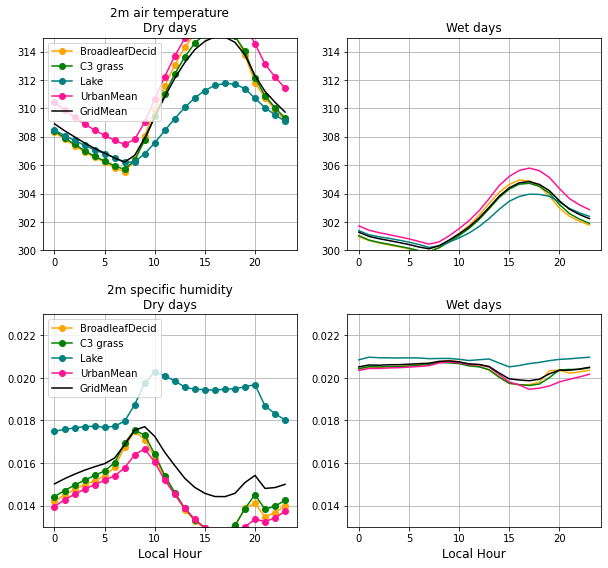

In [181]:
## Figure for manuscript

varSel = np.asarray(['TSA','Q2M'])
patchLabels[0] = 'BroadleafDecid'

fig,axs = plt.subplots(len(varSel),2, figsize=(10,9))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.3)


yMax = np.asarray([315, 0.023])
yMin = np.asarray([300, 0.013])

iPlot=0
for iVar in range(len(varSel)):
    ## Get urban mean
    iUrban = np.where((colType>=70) & (colType<80))[0]

    varSel_urban_dDry = np.nansum(hourlyMeanPatch_dryDays_HTG[varSel[iVar]].values[:, iUrban]*PFTwgt[iUrban], axis=1)/np.nansum(PFTwgt[iUrban])
    varSel_urban_wWet = np.nansum(hourlyMeanPatch_wetDays_HTG[varSel[iVar]].values[:, iUrban]*PFTwgt[iUrban], axis=1)/np.nansum(PFTwgt[iUrban])

    ## dDry days 
    axs[iPlot].plot(hourlyMeanPatch_dryDays_HTG.hour.values, np.squeeze(hourlyMeanPatch_dryDays_HTG[varSel[iVar]].values[:, 0]),
             'o-', color='orange', label=patchLabels[0])
    axs[iPlot].plot(hourlyMeanPatch_dryDays_HTG.hour.values, np.squeeze(hourlyMeanPatch_dryDays_HTG[varSel[iVar]].values[:, 1]),
             'o-',color='green', label=patchLabels[1])
    axs[iPlot].plot(hourlyMeanPatch_dryDays_HTG.hour.values, np.squeeze(hourlyMeanPatch_dryDays_HTG[varSel[iVar]].values[:, -1]),
             'o-',color='teal',label=patchLabels[-1])
    axs[iPlot].plot(hourlyMeanCLM_dryDays_HTG.hour.values, varSel_urban_dDry,
             'o-',color='deeppink',label='UrbanMean')
    axs[iPlot].plot(hourlyMeanCLM_dryDays_HTG.hour.values, hourlyMeanCLM_dryDays_HTG[varSel[iVar]].values, 'k-',label='GridMean')
    axs[iPlot].legend(loc='upper left',fontsize=10)
    axs[iPlot].set_title(HTGclmDS_patch_local[varSel[iVar]].long_name+'\nDry days')
    axs[iPlot].set_ylim([yMin[iVar], yMax[iVar]])


    ## wWet days 
    axs[iPlot+1].plot(hourlyMeanPatch_wetDays_HTG.hour.values, np.squeeze(hourlyMeanPatch_wetDays_HTG[varSel[iVar]].values[:, 0]),
             color='orange',label=patchLabels[0])
    axs[iPlot+1].plot(hourlyMeanPatch_wetDays_HTG.hour.values, np.squeeze(hourlyMeanPatch_wetDays_HTG[varSel[iVar]].values[:, 1]),
             color='green',label=patchLabels[1])
    axs[iPlot+1].plot(hourlyMeanPatch_wetDays_HTG.hour.values, np.squeeze(hourlyMeanPatch_wetDays_HTG[varSel[iVar]].values[:, -1]),
             color='teal',label=patchLabels[-1])
    axs[iPlot+1].plot(hourlyMeanCLM_wetDays_HTG.hour.values, varSel_urban_wWet,
             color='deeppink',label='UrbanMean')
    axs[iPlot+1].plot(hourlyMeanCLM_wetDays_HTG.hour.values, hourlyMeanCLM_wetDays_HTG[varSel[iVar]].values, 'k-',label='GridMean')
    axs[iPlot+1].set_title('\nWet days')
    axs[iPlot+1].set_ylim([yMin[iVar], yMax[iVar]])

#     axs[iPlot+0].grid()
#     axs[iPlot+1].grid()
    
    if iVar==(len(varSel)-1):
        axs[iPlot].set_xlabel('Local Hour', fontsize=12)
        axs[iPlot+1].set_xlabel('Local Hour', fontsize=12)

    iPlot = iPlot+2


axs[0].grid()
axs[1].grid()
axs[2].grid()
axs[3].grid()



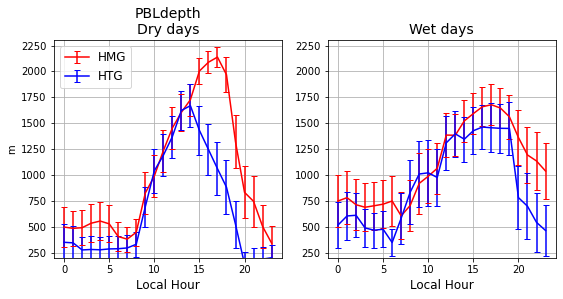

In [182]:
## Fig for manuscript 

# varSel = np.asarray(['PBLdepth','CLDTOT','TREFHT','QREFHT'])
varSel = np.asarray(['PBLdepth'])

fig,axs = plt.subplots(len(varSel),2, figsize=(9,4))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.5)

# yMax = np.asarray([2600, 1.05,  315, 0.0240])
# yMin = np.asarray([ 200, 0.3,   298, 0.0120])
yMax = np.asarray([2300])
yMin = np.asarray([ 200])

iPlot=0
for iVar in range(len(varSel)):
    axs[iPlot+0].errorbar(hourlyMean_dryDays_HMG.hour.values, np.squeeze(hourlyMean_dryDays_HMG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_dryDays_HMG[varSel[iVar]].values)/np.sqrt(hourlyMean_dryDays_HMG['SampleCount'].values),
                          fmt='r-', capsize=3, label='HMG')
    axs[iPlot+0].errorbar(hourlyMean_dryDays_HTG.hour.values, np.squeeze(hourlyMean_dryDays_HTG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_dryDays_HTG[varSel[iVar]].values)/np.sqrt(hourlyMean_dryDays_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    if iVar==0:
        axs[iPlot+0].legend(loc='upper left',fontsize=12)
    axs[iPlot+0].set_title(varSel[iVar]+'\nDry days', fontsize=14)
    if varSel[iVar]=='PBLdepth':
        axs[iPlot].set_ylabel(HTGcamDS_local['PBLH'].units)
    else: 
        axs[iPlot].set_ylabel(HTGcamDS_local[varSel[iVar]].units, fontsize=12)
 

    axs[iPlot+1].errorbar(hourlyMean_wetDays_HMG.hour.values, np.squeeze(hourlyMean_wetDays_HMG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_wetDays_HMG[varSel[iVar]].values)/np.sqrt(hourlyMean_wetDays_HMG['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+1].errorbar(hourlyMean_wetDays_HTG.hour.values, np.squeeze(hourlyMean_wetDays_HTG[varSel[iVar]].values), 
                          yerr =2*np.squeeze(hourlyStd_wetDays_HTG[varSel[iVar]].values)/np.sqrt(hourlyMean_wetDays_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+1].set_title('\nWet days', fontsize=14)  
    
    axs[iPlot+0].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+1].set_ylim([yMin[iVar],yMax[iVar]])
    
    axs[iPlot+0].grid()
    axs[iPlot+1].grid()
    
    if iVar==(len(varSel)-1):
        axs[iPlot].set_xlabel('Local Hour', fontsize=12)
        axs[iPlot+1].set_xlabel('Local Hour', fontsize=12)

    iPlot = iPlot+2

    

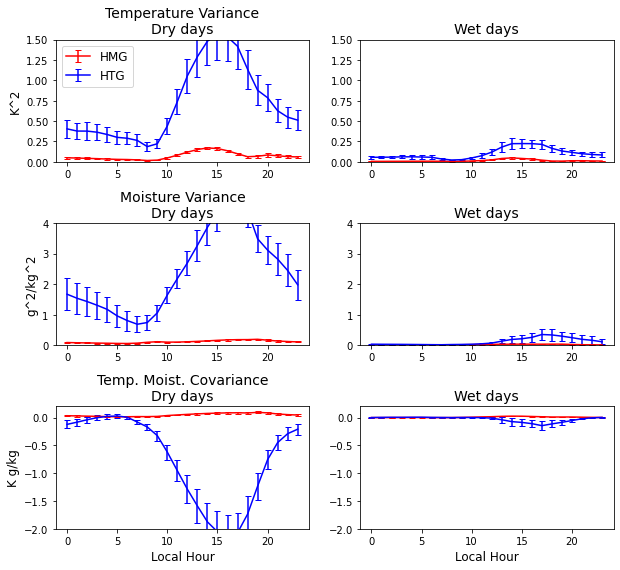

In [183]:
## Fig for manuscript 

varSel = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB'])

fig,axs = plt.subplots(len(varSel),2, figsize=(10,9))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.5)

# yMax = np.asarray([2600, 280, 250, 314, 0.0210, 1.05, 0.3, 1.0])
# yMin = np.asarray([ 200, -50, -10, 295, 0.0120, 0.3, 0.0, 0.0])
yMax = np.asarray([1.5, 4.0,  0.2])
yMin = np.asarray([0.0, 0.0, -2.0])

iPlot=0
for iVar in range(len(varSel)):
    axs[iPlot+0].errorbar(hourlyMean_dryDays_HMG.hour.values, np.squeeze(hourlyMean_dryDays_HMG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_dryDays_HMG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_dryDays_HMG['SampleCount'].values),
                          fmt='r-', capsize=3, label='HMG')
    axs[iPlot+0].errorbar(hourlyMean_dryDays_HTG.hour.values, np.squeeze(hourlyMean_dryDays_HTG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_dryDays_HTG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_dryDays_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    if iVar==0:
        axs[iPlot+0].legend(loc='upper left',fontsize=12)
    axs[iPlot+0].set_title(HMGcamDS_local[varSel[iVar]].long_name+'\nDry days', fontsize=14)
    if varSel[iVar]=='PBLdepth':
        axs[iPlot].set_ylabel(HTGcamDS_local['PBLH'].units)
    else: 
        axs[iPlot].set_ylabel(HTGcamDS_local[varSel[iVar]].units, fontsize=12)
 

    axs[iPlot+1].errorbar(hourlyMean_wetDays_HMG.hour.values, np.squeeze(hourlyMean_wetDays_HMG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_wetDays_HMG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_wetDays_HMG['SampleCount'].values),
                          fmt='r', capsize=3, label='HMG')
    axs[iPlot+1].errorbar(hourlyMean_wetDays_HTG.hour.values, np.squeeze(hourlyMean_wetDays_HTG[varSel[iVar]].values[:,-1,:,:]), 
                          yerr =2*np.squeeze(hourlyStd_wetDays_HTG[varSel[iVar]].values[:,-1,:,:])/np.sqrt(hourlyMean_wetDays_HTG['SampleCount'].values),
                          fmt='b', capsize=3, label='HTG')
    axs[iPlot+1].set_title('\nWet days', fontsize=14)  
    
    axs[iPlot+0].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+1].set_ylim([yMin[iVar],yMax[iVar]])
    
#     axs[iPlot+0].grid()
#     axs[iPlot+1].grid()
    
    if iVar==(len(varSel)-1):
        axs[iPlot].set_xlabel('Local Hour', fontsize=12)
        axs[iPlot+1].set_xlabel('Local Hour', fontsize=12)

    iPlot = iPlot+2




Taking means over 15-18 h (local time)


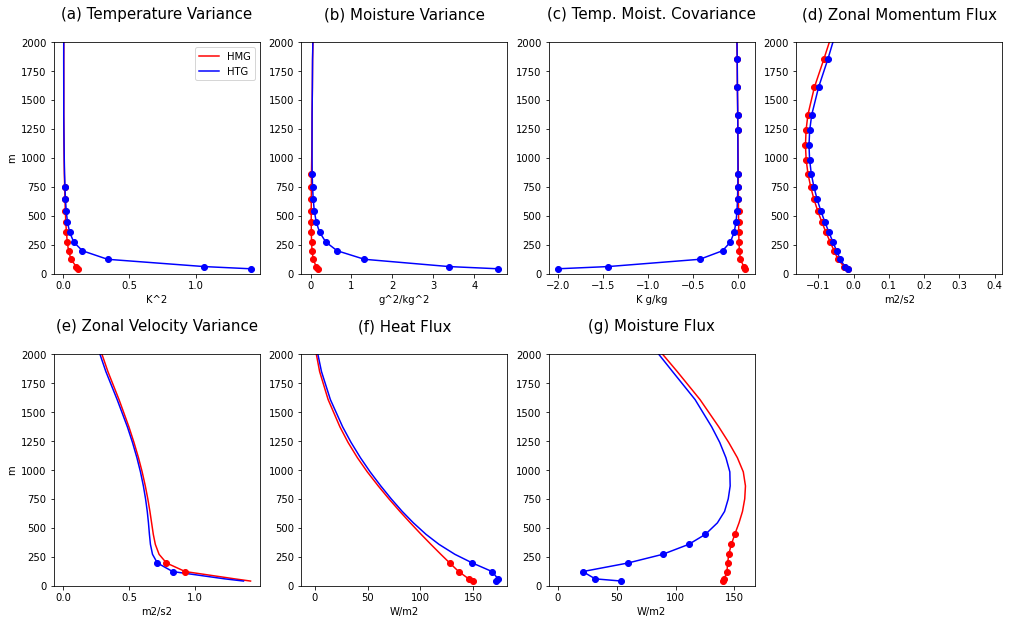

In [184]:
## How about plotting a final manuscript-worth yfigure with dry day info only?

def getMeanProfiles(startHr,endHr,varSel):
    # ------- dDry days ----------
    iTimeSel_dryHMG = np.where((dryDays_HMG["time.hour"].values>=startHr) & 
                               (dryDays_HMG["time.hour"].values<=endHr))[0]
    iTimeSel_dryHTG = np.where((dryDays_HTG["time.hour"].values>=startHr) & 
                               (dryDays_HTG["time.hour"].values<=endHr))[0]
    

    hourlyMean_dryTimeSel_HMG = dryDays_HMG.isel(time=iTimeSel_dryHMG).mean(dim='time')
    hourlyMean_dryTimeSel_HTG = dryDays_HTG.isel(time=iTimeSel_dryHTG).mean(dim='time')
    
    hourlyStd_dryTimeSel_HMG = dryDays_HMG.isel(time=iTimeSel_dryHMG).std(dim='time')
    hourlyStd_dryTimeSel_HTG = dryDays_HTG.isel(time=iTimeSel_dryHTG).std(dim='time')
    
    varProfile_HMG  = np.squeeze(hourlyMean_dryTimeSel_HMG[varSel].values)
    varProfile_HTG  = np.squeeze(hourlyMean_dryTimeSel_HTG[varSel].values)
    
    stdErr_dry_HMG = np.squeeze(hourlyStd_dryTimeSel_HMG[varSel].values)/np.sqrt(len(iTimeSel_dryHMG))
    stdErr_dry_HTG = np.squeeze(hourlyStd_dryTimeSel_HTG[varSel].values)/np.sqrt(len(iTimeSel_dryHTG))

    return(varProfile_HMG, varProfile_HTG, stdErr_dry_HMG,stdErr_dry_HTG)



#### THIS IS THE SECTION TO EDIT:
## Set variables to plot and hours to average over
varList = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB','UPWP_CLUBB',
                      'UP2_CLUBB','WPTHLP_CLUBB','WPRTP_CLUBB'])
#                        'WP3_CLUBB','Skw_W','RVMTEND_CLUBB','STEND_CLUBB'])
startHr = 15
endHr   = 18
##### Main section of editing ends here 

print('Taking means over %i-%i h (local time)' % (startHr, endHr))

fig,axs = plt.subplots(2,4, figsize=(17,10))
axs     = axs.ravel() 
fig.subplots_adjust(hspace=0.35)

subpanel_labels = np.asarray(['(a) ','(b) ','(c) ','(d) ','(e) ','(f) ','(g) ','(h) '])

for iPlot in range(len(varList)):
    # Get mean profiles and error estiamtes 
    varProfile_HMG,varProfile_HTG, stdErr_dry_HMG,stdErr_dry_HTG = getMeanProfiles(startHr, endHr, varList[iPlot])
    
    # Set title for plots 
    if varList[iPlot]=='Skw_W':
        axs[iPlot].set_title(subpanel_labels[iPlot]+'Vertical Velocity Skew\n', fontsize=15)
        unitLabel = 'm/s'
    else:
        axs[iPlot].set_title(subpanel_labels[iPlot]+HTGcamDS_local[varList[iPlot]].long_name+'\n', fontsize=15)
        unitLabel = HTGcamDS_local[varList[iPlot]].units
        
    # Set which heights to use (interface vs. midpoint)
    if np.shape(varProfile_HMG)[0]==len(HMGcamDS_local.ilev.values): 
        levSel = 'ilev'
    elif np.shape(varProfile_HMG)[0]==len(HMGcamDS_local.lev.values):
        levSel = 'lev'

    # Now do the actual plotting
    axs[iPlot].plot(varProfile_HMG, 
                    HMGcamDS_local[levSel].values,
                    'r-',  label='HMG')
    axs[iPlot].plot(varProfile_HTG, 
                    HMGcamDS_local[levSel].values,
                    'b', label='HTG')
    axs[iPlot].set_xlabel(unitLabel)
    
    # Control labels more
    if iPlot==0:
        axs[iPlot].legend()
        axs[iPlot].set_ylabel('m')
    elif iPlot==4:
        axs[iPlot].set_ylabel('m')

    
    # Signal significance more clearly on plots
    xmax1 = np.squeeze(varProfile_HMG) + (2*stdErr_dry_HMG)
    xmin1 = np.squeeze(varProfile_HMG) - (2*stdErr_dry_HMG)
    xmax2 = np.squeeze(varProfile_HTG) + (2*stdErr_dry_HTG)
    xmin2 = np.squeeze(varProfile_HTG) - (2*stdErr_dry_HTG)

    levSig = np.ones([len(varProfile_HMG)])
    for iLev in range(len(varProfile_HMG)):
        if ((abs(xmin1[iLev])>=abs(xmin2[iLev])) & (abs(xmin1[iLev])<=abs(xmax2[iLev]))):
            levSig[iLev] = 0
        elif ((abs(xmin2[iLev])>=abs(xmin1[iLev])) & (abs(xmin2[iLev])<=abs(xmax1[iLev]))):
            levSig[iLev] = 0

        if levSig[iLev]==1:
            axs[iPlot].plot(varProfile_HMG[iLev], 
                        HMGcamDS_local[levSel].values[iLev], 
                        'ro')
            axs[iPlot].plot(varProfile_HTG[iLev], 
                        HMGcamDS_local[levSel].values[iLev], 
                    'bo')
                
    axs[iPlot].set_ylim([0,2000])
    
# Remove last plot panel
fig.delaxes(axs[7])




Taking means over 15-18 h (local time)


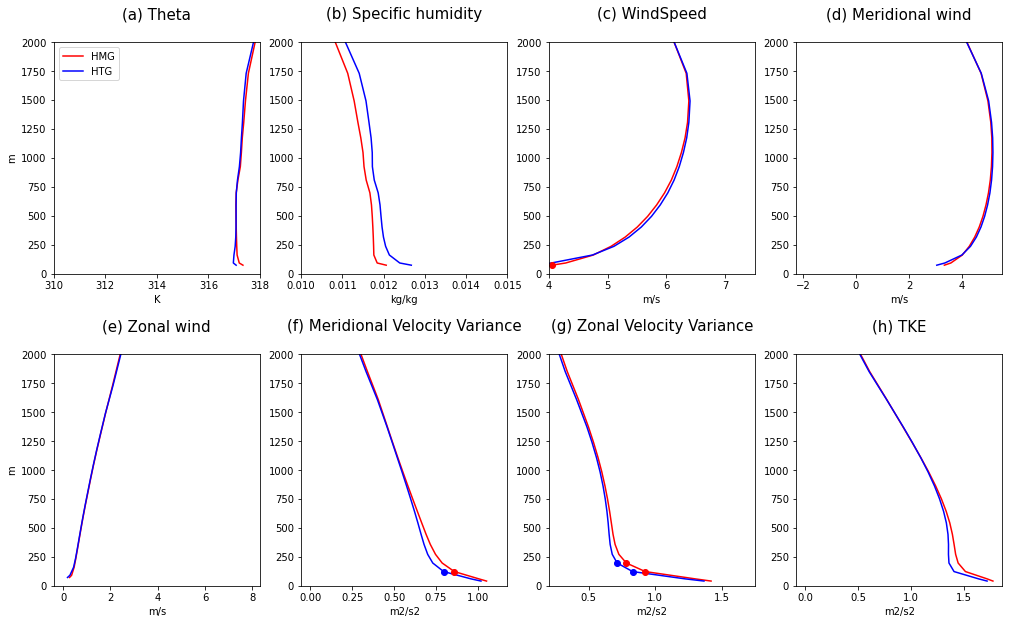

In [185]:
#### THIS IS THE SECTION TO EDIT:
## Set variables to plot and hours to average over
# varList = np.asarray(['T','Q','WindMagnitude','U','VP2_CLUBB','UP2_CLUBB','WP2_CLUBB','TKE'])
varList = np.asarray(['theta','Q','WindMagnitude','V','U','VP2_CLUBB','UP2_CLUBB','TKE'])
startHr = 15
endHr   = 18
#### Main section to edit ends here 
print('Taking means over %i-%i h (local time)' % (startHr, endHr))

fig,axs = plt.subplots(2,4, figsize=(17,10))
axs     = axs.ravel() 
fig.subplots_adjust(hspace=0.35)

subpanel_labels = np.asarray(['(a) ','(b) ','(c) ','(d) ','(e) ','(f) ','(g) ','(h) '])

for iPlot in range(len(varList)):
    # Get mean profiles and error estiamtes 
    varProfile_HMG,varProfile_HTG, stdErr_dDry_HMG,stdErr_dDry_HTG = getMeanProfiles(startHr, endHr, varList[iPlot])
    
    # Set title for plots and x-axis units. 
    #   Important for variables 
    if varList[iPlot]=='WindMagnitude':
        axs[iPlot].set_title(subpanel_labels[iPlot]+'WindSpeed\n', fontsize=15)
        unitLabel = 'm/s'
    elif varList[iPlot]=='TKE':
        axs[iPlot].set_title(subpanel_labels[iPlot]+'TKE\n', fontsize=15)
        unitLabel = 'm2/s2'
    elif varList[iPlot]=='theta':
        axs[iPlot].set_title(subpanel_labels[iPlot]+'Theta\n', fontsize=15)
        unitLabel = 'K'
    else:
        axs[iPlot].set_title(subpanel_labels[iPlot]+HTGcamDS_local[varList[iPlot]].long_name+'\n', fontsize=15)
        unitLabel = HTGcamDS_local[varList[iPlot]].units
        
    # Set which heights to use (interface vs. midpoint)
    if np.shape(varProfile_HMG)[0]==len(HMGcamDS_local.ilev.values): 
        levSel = 'ilev'
    elif np.shape(varProfile_HMG)[0]==len(HMGcamDS_local.lev.values):
        levSel = 'lev'

    # Now do the actual plotting
    axs[iPlot].plot(varProfile_HMG, 
                    HMGcamDS_local[levSel].values,
                    'r-',  label='HMG')
    axs[iPlot].plot(varProfile_HTG, 
                    HMGcamDS_local[levSel].values,
                    'b', label='HTG')
    axs[iPlot].set_xlabel(unitLabel)
    
    # Control plot labels 
    if iPlot==0:
        axs[iPlot].legend()
        axs[iPlot].set_ylabel('m')
    elif iPlot==4:
        axs[iPlot].set_ylabel('m')

    
    # Signal significance more clearly on plots
    #   Plot a line marker (circle) if diff is significant at that level
    xmax1 = np.squeeze(varProfile_HMG) + (2*stdErr_dDry_HMG)
    xmin1 = np.squeeze(varProfile_HMG) - (2*stdErr_dDry_HMG)
    xmax2 = np.squeeze(varProfile_HTG) + (2*stdErr_dDry_HTG)
    xmin2 = np.squeeze(varProfile_HTG) - (2*stdErr_dDry_HTG)

    levSig = np.ones([len(varProfile_HMG)])
    for iLev in range(len(varProfile_HMG)):
        if ((abs(xmin1[iLev])>=abs(xmin2[iLev])) & (abs(xmin1[iLev])<=abs(xmax2[iLev]))):
            levSig[iLev] = 0
        elif ((abs(xmin2[iLev])>=abs(xmin1[iLev])) & (abs(xmin2[iLev])<=abs(xmax1[iLev]))):
            levSig[iLev] = 0

        if levSig[iLev]==1:
            axs[iPlot].plot(varProfile_HMG[iLev], 
                        HMGcamDS_local[levSel].values[iLev], 
                        'ro')
            axs[iPlot].plot(varProfile_HTG[iLev], 
                        HMGcamDS_local[levSel].values[iLev], 
                    'bo')
                
    # Set y-axis limit (how high above the surface to plot)
    axs[iPlot].set_ylim([0,2000])
    
    # Set some xaxis limits depending on variable chosen
    if varList[iPlot]=='T':
        axs[iPlot].set_xlim([290,315])
    elif varList[iPlot]=='Q':
        axs[iPlot].set_xlim([0.01, 0.015])
    elif varList[iPlot]=='WindMagnitude':
        axs[iPlot].set_xlim([4,7.5])
    elif varList[iPlot]=='theta':
        axs[iPlot].set_xlim([310,318])
    elif varList[iPlot]=='UP2_CLUBB':
        axs[iPlot].set_xlim([0.2,1.75])

    # Add gridlines 
    #axs[iPlot].grid()

